In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

In [20]:


def catmull_rom_spline(P0, P1, P2, P3, n_points=100):
    """
    P0, P1, P2, and P3 should be (x,y,z)-tuples that are knots defining the Catmull-Rom spline.
    nPoints is the number of points to include in this curve segment.
    Modified from https://en.wikipedia.org/wiki/Centripetal_Catmull%E2%80%93Rom_spline#Code_example_in_Python to be 
    independent of Numpy
    """
    # Calculate t0 to t4
    alpha = 0.5 # 0: uniform sampling; 0.5: centripetal sampling; 1: chordal sampling
    def tj(ti, Pi, Pj):
        xi, yi, zi = Pi
        xj, yj, zj = Pj
        return ( ( (xj-xi)**2 + (yj-yi)**2 + (zj-zi)**2)**0.5 )**alpha + ti

    t0 = 0
    t1 = tj(t0, P0, P1)
    t2 = tj(t1, P1, P2)
    t3 = tj(t2, P2, P3)

    # Only calculate points between P1 and P2
    t = [t1+(t2-t1)*float(idx)/(n_points-1) for idx in range(n_points)];

    # Reshape so that we can multiply by the points P0 to P3
    # and get a point for each value of t.
    A1 = [[(t1-tt)/(t1-t0)*P0[idx] + (tt-t0)/(t1-t0)*P1[idx] for idx in range(3)] for tt in t];
    A2 = [[(t2-tt)/(t2-t1)*P1[idx] + (tt-t1)/(t2-t1)*P2[idx] for idx in range(3)] for tt in t];
    A3 = [[(t3-tt)/(t3-t2)*P2[idx] + (tt-t2)/(t3-t2)*P3[idx] for idx in range(3)] for tt in t];
    B1 = [[(t2-tt)/(t2-t0)*A1[tidx][idx] + (tt-t0)/(t2-t0)*A2[tidx][idx] for idx in range(3)] for tidx, tt in enumerate(t)];
    B2 = [[(t3-tt)/(t3-t1)*A2[tidx][idx] + (tt-t1)/(t3-t1)*A3[tidx][idx] for idx in range(3)] for tidx, tt in enumerate(t)];
    C  = [[(t2-tt)/(t2-t1)*B1[tidx][idx] + (tt-t1)/(t2-t1)*B2[tidx][idx] for idx in range(3)] for tidx, tt in enumerate(t)];
    return C

def linear_interp(p0, p1, n_points=100):
    """
    Return linear interpolation for the segment between knots P0 and P1
    """
    t = [float(idx)/(n_points - 1) for idx in range(n_points)];
    c = [[p0[idx] + tt*(p1[idx] - p0[idx]) for idx in range(3)] for tt in t];
    return c;

def catmull_rom_chain(p):
    """
    Calculate Catmull Rom for a list of (x, y, z)-tuples and return the combined curve, adding linear segments at start
    and end. 
    """
    sz = len(p)

    # The curve C will contain an array of (x,y) points.
    c = []
    c.extend(linear_interp(p[0], p[1]));
    for i in range(sz-3):
        cc = catmull_rom_spline(p[i], p[i+1], p[i+2], p[i+3])
        c.extend(cc)
    c.extend(linear_interp(p[-2], p[-1]));
    return c;

def resample_z(catmull_rom_points, z_points):
    """
    Resample the interpolated list of points at given z-points
    EITHER remove interpolated points before first identified index to ensure that path doesn't jump around, 
    OR just do linear interpolation and smoothing...
    """
    _,_,z = zip(*catmull_rom_points);
    unique_z = list(set(z));
    print("len(unique_z) = {}".format(len(unique_z)));
    unique_z_catmull_rom = [catmull_rom_point for catmull_rom_point in catmull_rom_points if catmull_rom_point[2] in unique_z];
    out_points = [];
    for ztarget in z_points:
#         print("ztarget = {}".format(ztarget));
        loss_function = [abs(zz-ztarget) for zz in unique_z];
#         print("loss_function = {}".format(loss_function));
        out_idx1 = loss_function.index(min(loss_function));
#         print("out_idx1 = {}".format(out_idx1));
#         print("unique_z_catmull_rom[out_idx1] = {}".format(unique_z_catmull_rom[out_idx1]));
        if out_idx1 == 0:
            out_coords = (unique_z_catmull_rom[out_idx1][0], unique_z_catmull_rom[out_idx1][1], ztarget);
            out_points.append(out_coords);
            continue;
        try:
            out_idx2 = loss_function.index(min([loss_function[out_idx1 - 1], loss_function[out_idx1 + 1]]));
#             print("out_idx2 = {}".format(out_idx2));
#             print("unique_z_catmull_rom[out_idx2] = {}".format(unique_z_catmull_rom[out_idx2]));
        except IndexError:
            print("INDEX ERROR! out_idx1 = {}, ztarget = {}".format(out_idx1, ztarget));
            out_coords = (unique_z_catmull_rom[out_idx1][0], unique_z_catmull_rom[out_idx1][1], ztarget);
            out_points.append(out_coords);
            continue;

        print("denominator = {}".format((unique_z_catmull_rom[out_idx2][2] - unique_z_catmull_rom[out_idx1][2])));
        deltaxy = [(unique_z_catmull_rom[out_idx2][idx] - unique_z_catmull_rom[out_idx1][idx]) * 
            (ztarget/(unique_z_catmull_rom[out_idx2][2] - unique_z_catmull_rom[out_idx1][2])) for idx in range(2)];
        out_coords = (unique_z_catmull_rom[out_idx1][0] + deltaxy[0], 
                        unique_z_catmull_rom[out_idx1][1] + deltaxy[1], 
                        ztarget);
        out_points.append(out_coords);
        unique_z_catmull_rom = unique_z_catmull_rom[out_idx1:];
        unique_z = unique_z[out_idx1:];
        print("trimmed len(unique_z) = {}".format(len(unique_z)));
    return out_points;

# # Define a set of points for curve to go through
# points = [(0.0,1.5,1.0),(2.0,2.0, 1.0),(3.0,1.0, 1.0),(4.0,0.5, 2.0),(5.0,1.0, 2.0),(6.0,2.0, 2.0),(7.0,3.0, 2.0)];

# # Calculate the Catmull-Rom splines through the points
# c = catmull_rom_chain(points);

# # Convert the Catmull-Rom curve points into x and y arrays and plot
# x,y,z = zip(*c);
# # ztarget = 1.5
# # targ_idx = [abs(zz-ztarget) for zz in z].index(min([abs(zz-ztarget) for zz in z]));
# # print(x[targ_idx], y[targ_idx], z[targ_idx])

# fig = plt.figure();
# ax = fig.add_subplot(111, projection='3d');

# ax.plot(x,y,z);
# # print(len(x))

# # Plot the control points
# px, py, pz = zip(*points)
# ax.scatter(px,py,pz,'or')
# resample_points = resample_z(c, [1.0, 1.25, 1.5, 1.75, 2.0])
# print(resample_points)
# tx, ty, tz = zip(*resample_points);
# ax.scatter(tx, ty, tz, 'og')
# plt.show()

In [1]:
spline_interp_centers = [[270.0, 135.0, 1.0], [269.97595190380764, 134.93386773547095, 1.2004008016032064], [269.9519038076152, 134.86773547094188, 1.4008016032064128], [269.92785571142286, 134.80160320641284, 1.6012024048096194], [269.90380761523045, 134.73547094188376, 1.8016032064128256], [269.8797595190381, 134.66933867735472, 2.0020040080160317], [269.8557114228457, 134.60320641282564, 2.202404809619239], [269.8316633266533, 134.5370741482966, 2.402805611222445], [269.8076152304609, 134.47094188376752, 2.603206412825651], [269.78356713426854, 134.40480961923848, 2.8036072144288577], [269.7595190380762, 134.33867735470943, 3.004008016032064], [269.73547094188376, 134.27254509018036, 3.2044088176352705], [269.7114228456914, 134.2064128256513, 3.404809619238477], [269.687374749499, 134.14028056112224, 3.6052104208416833], [269.6633266533066, 134.0741482965932, 3.80561122244489], [269.6392785571142, 134.00801603206412, 4.006012024048096], [269.61523046092185, 133.94188376753507, 4.206412825651302], [269.59118236472943, 133.875751503006, 4.406813627254509], [269.5671342685371, 133.80961923847696, 4.6072144288577155], [269.5430861723447, 133.7434869739479, 4.807615230460922], [269.5190380761523, 133.67735470941884, 5.008016032064128], [269.49498997995994, 133.6112224448898, 5.208416833667335], [269.4709418837675, 133.54509018036072, 5.408817635270541], [269.44689378757516, 133.47895791583167, 5.609218436873747], [269.42284569138275, 133.4128256513026, 5.809619238476954], [269.3987975951904, 133.34669338677355, 6.01002004008016], [269.37474949899797, 133.28056112224448, 6.210420841683367], [269.3507014028056, 133.21442885771543, 6.410821643286573], [269.32665330661325, 133.14829659318636, 6.61122244488978], [269.30260521042084, 133.0821643286573, 6.811623246492986], [269.2785571142285, 133.01603206412827, 7.012024048096192], [269.25450901803606, 132.9498997995992, 7.212424849699398], [269.2304609218437, 132.88376753507015, 7.4128256513026045], [269.2064128256513, 132.81763527054107, 7.613226452905812], [269.1823647294589, 132.75150300601203, 7.813627254509018], [269.1583166332665, 132.68537074148296, 8.014028056112224], [269.13426853707415, 132.6192384769539, 8.214428857715431], [269.1102204408818, 132.55310621242484, 8.414829659318638], [269.0861723446894, 132.4869739478958, 8.615230460921843], [269.062124248497, 132.42084168336675, 8.815631262525049], [269.0380761523046, 132.35470941883767, 9.016032064128256], [269.01402805611224, 132.28857715430863, 9.216432865731463], [268.9899799599198, 132.22244488977955, 9.41683366733467], [268.96593186372746, 132.1563126252505, 9.617234468937877], [268.94188376753505, 132.09018036072143, 9.817635270541082], [268.9178356713427, 132.0240480961924, 10.01803607214429], [268.8937875751503, 131.9579158316633, 10.218436873747494], [268.8697394789579, 131.89178356713427, 10.418837675350701], [268.84569138276555, 131.82565130260522, 10.619238476953909], [268.82164328657313, 131.75951903807615, 10.819639278557114], [268.7975951903808, 131.6933867735471, 11.02004008016032], [268.77354709418836, 131.62725450901803, 11.220440881763528], [268.749498997996, 131.56112224448898, 11.420841683366733], [268.7254509018036, 131.4949899799599, 11.62124248496994], [268.7014028056112, 131.42885771543087, 11.821643286573146], [268.67735470941886, 131.3627254509018, 12.022044088176353], [268.65330661322645, 131.29659318637275, 12.22244488977956], [268.6292585170341, 131.2304609218437, 12.422845691382765], [268.6052104208417, 131.16432865731463, 12.623246492985972], [268.5811623246493, 131.09819639278558, 12.823647294589177], [268.5571142284569, 131.0320641282565, 13.024048096192384], [268.53306613226454, 130.96593186372746, 13.224448897795591], [268.5090180360721, 130.8997995991984, 13.424849699398797], [268.48496993987976, 130.83366733466934, 13.625250501002002], [268.4609218436874, 130.76753507014027, 13.825651302605209], [268.436873747495, 130.70140280561122, 14.026052104208416], [268.4128256513026, 130.63527054108215, 14.226452905811623], [268.3887775551102, 130.5691382765531, 14.426853707414828], [268.36472945891785, 130.50300601202406, 14.627254509018035], [268.34068136272543, 130.43687374749499, 14.827655310621243], [268.3166332665331, 130.37074148296594, 15.02805611222445], [268.29258517034066, 130.30460921843687, 15.228456913827655], [268.2685370741483, 130.23847695390782, 15.428857715430862], [268.24448897795594, 130.17234468937875, 15.629258517034069], [268.2204408817635, 130.1062124248497, 15.829659318637276], [268.19639278557116, 130.04008016032063, 16.03006012024048], [268.17234468937875, 129.97394789579158, 16.230460921843687], [268.1482965931864, 129.90781563126254, 16.430861723446892], [268.12424849699397, 129.84168336673346, 16.631262525050097], [268.1002004008016, 129.77555110220442, 16.831663326653306], [268.0761523046092, 129.70941883767534, 17.03206412825651], [268.05210420841684, 129.6432865731463, 17.23246492985972], [268.0280561122245, 129.57715430861722, 17.432865731462925], [268.00400801603206, 129.51102204408818, 17.63326653306613], [267.9799599198397, 129.4448897795591, 17.83366733466934], [267.9559118236473, 129.37875751503006, 18.034068136272545], [267.9318637274549, 129.31262525050101, 18.234468937875754], [267.9078156312625, 129.24649298597194, 18.43486973947896], [267.88376753507015, 129.1803607214429, 18.635270541082164], [267.85971943887773, 129.11422845691382, 18.835671342685373], [267.8356713426854, 129.04809619238478, 19.03607214428858], [267.811623246493, 128.9819639278557, 19.236472945891784], [267.7875751503006, 128.91583166332666, 19.43687374749499], [267.76352705410824, 128.84969939879758, 19.637274549098194], [267.7394789579158, 128.78356713426854, 19.837675350701403], [267.71543086172346, 128.7174348697395, 20.03807615230461], [267.69138276553105, 128.65130260521042, 20.238476953907817], [267.6673346693387, 128.58517034068137, 20.438877755511022], [267.64328657314627, 128.5190380761523, 20.639278557114228], [267.6192384769539, 128.45290581162325, 20.839679358717436], [267.59519038076155, 128.38677354709418, 21.04008016032064], [267.57114228456913, 128.32064128256513, 21.240480961923847], [267.5470941883768, 128.25450901803606, 21.440881763527056], [267.52304609218436, 128.18837675350701, 21.64128256513026], [267.498997995992, 128.12224448897797, 21.841683366733466], [267.4749498997996, 128.0561122244489, 22.04208416833667], [267.4509018036072, 127.98997995991984, 22.24248496993988], [267.4268537074148, 127.92384769539078, 22.442885771543086], [267.40280561122245, 127.85771543086173, 22.64328657314629], [267.3787575150301, 127.79158316633267, 22.8436873747495], [267.3547094188377, 127.72545090180361, 23.044088176352705], [267.3306613226453, 127.65931863727455, 23.24448897795591], [267.3066132264529, 127.59318637274549, 23.44488977955912], [267.28256513026054, 127.52705410821643, 23.645290581162325], [267.2585170340681, 127.46092184368737, 23.84569138276553], [267.23446893787576, 127.39478957915831, 24.04609218436874], [267.21042084168334, 127.32865731462925, 24.246492985971944], [267.186372745491, 127.2625250501002, 24.446893787575153], [267.1623246492986, 127.19639278557115, 24.647294589178355], [267.1382765531062, 127.13026052104209, 24.847695390781563], [267.11422845691385, 127.06412825651303, 25.04809619238477], [267.09018036072143, 126.99799599198397, 25.248496993987974], [267.0661322645291, 126.93186372745491, 25.448897795591183], [267.04208416833666, 126.86573146292585, 25.649298597194388], [267.0180360721443, 126.79959919839679, 25.849699398797593], [266.9939879759519, 126.73346693386773, 26.0501002004008], [266.9699398797595, 126.66733466933869, 26.250501002004004], [266.94589178356716, 126.60120240480961, 26.450901803607213], [266.92184368737475, 126.53507014028057, 26.651302605210418], [266.8977955911824, 126.46893787575151, 26.851703406813627], [266.87374749498997, 126.40280561122245, 27.052104208416832], [266.8496993987976, 126.33667334669339, 27.252505010020037], [266.8256513026052, 126.27054108216433, 27.452905811623246], [266.80160320641284, 126.20440881763527, 27.65330661322645], [266.7775551102204, 126.13827655310621, 27.853707414829657], [266.75350701402806, 126.07214428857715, 28.054108216432866], [266.7294589178357, 126.00601202404809, 28.25450901803607], [266.7054108216433, 125.93987975951904, 28.45490981963928], [266.6813627254509, 125.87374749498998, 28.655310621242485], [266.6573146292585, 125.80761523046093, 28.85571142284569], [266.63326653306615, 125.74148296593187, 29.0561122244489], [266.60921843687373, 125.6753507014028, 29.256513026052104], [266.5851703406814, 125.60921843687375, 29.45691382765531], [266.56112224448896, 125.54308617234469, 29.65731462925852], [266.5370741482966, 125.47695390781563, 29.857715430861724], [266.5130260521042, 125.41082164328657, 30.058116232464933], [266.4889779559118, 125.34468937875752, 30.258517034068138], [266.46492985971946, 125.27855711422846, 30.458917835671343], [266.44088176352705, 125.2124248496994, 30.659318637274552], [266.4168336673347, 125.14629258517034, 30.859719438877757], [266.39278557114227, 125.08016032064128, 31.060120240480963], [266.3687374749499, 125.01402805611222, 31.26052104208417], [266.3446893787575, 124.94789579158316, 31.460921843687377], [266.32064128256513, 124.8817635270541, 31.66132264529058], [266.2965931863727, 124.81563126252505, 31.861723446893784], [266.27254509018036, 124.749498997996, 32.06212424849699], [266.248496993988, 124.68336673346694, 32.262525050100194], [266.2244488977956, 124.61723446893788, 32.4629258517034], [266.2004008016032, 124.55110220440882, 32.66332665330661], [266.1763527054108, 124.48496993987976, 32.86372745490982], [266.15230460921845, 124.4188376753507, 33.06412825651302], [266.12825651302603, 124.35270541082164, 33.26452905811623], [266.10420841683367, 124.28657314629258, 33.46492985971944], [266.08016032064126, 124.22044088176352, 33.66533066132264], [266.0561122244489, 124.15430861723446, 33.86573146292585], [266.03206412825654, 124.0881763527054, 34.06613226452906], [266.0080160320641, 124.02204408817636, 34.26653306613226], [265.98396793587176, 123.9559118236473, 34.46693386773547], [265.95991983967934, 123.88977955911824, 34.66733466933868], [265.935871743487, 123.82364729458918, 34.86773547094188], [265.91182364729457, 123.75751503006012, 35.06813627254509], [265.8877755511022, 123.69138276553106, 35.2685370741483], [265.8637274549098, 123.625250501002, 35.46893787575151], [265.83967935871743, 123.55911823647294, 35.66933867735471], [265.8156312625251, 123.49298597194388, 35.86973947895792], [265.79158316633266, 123.42685370741484, 36.07014028056113], [265.7675350701403, 123.36072144288578, 36.27054108216433], [265.7434869739479, 123.29458917835672, 36.47094188376754], [265.7194388777555, 123.22845691382766, 36.671342685370746], [265.6953907815631, 123.1623246492986, 36.87174348697395], [265.67134268537075, 123.09619238476954, 37.07214428857716], [265.64729458917833, 123.03006012024048, 37.27254509018036], [265.62324649298597, 122.96392785571142, 37.47294589178357], [265.5991983967936, 122.89779559118236, 37.67334669338677], [265.5751503006012, 122.83166332665331, 37.87374749498998], [265.55110220440883, 122.76553106212425, 38.07414829659319], [265.5270541082164, 122.6993987975952, 38.27454909819639], [265.50300601202406, 122.63326653306613, 38.4749498997996], [265.47895791583164, 122.56713426853707, 38.675350701402806], [265.4549098196393, 122.50100200400801, 38.87575150300601], [265.43086172344687, 122.43486973947896, 39.07615230460922], [265.4068136272545, 122.3687374749499, 39.276553106212425], [265.38276553106215, 122.30260521042084, 39.476953907815634], [265.35871743486973, 122.23647294589179, 39.677354709418836], [265.3346693386774, 122.17034068136273, 39.877755511022045], [265.31062124248496, 122.10420841683367, 40.078156312625254], [265.2865731462926, 122.03807615230461, 40.278557114228455], [265.2625250501002, 121.97194388777555, 40.478957915831664], [265.2384769539078, 121.90581162324649, 40.67935871743487], [265.2144288577154, 121.83967935871743, 40.879759519038075], [265.19038076152304, 121.77354709418837, 41.08016032064128], [265.1663326653307, 121.70741482965931, 41.28056112224449], [265.14228456913827, 121.64128256513025, 41.480961923847694], [265.1182364729459, 121.5751503006012, 41.6813627254509], [265.0941883767535, 121.50901803607215, 41.88176352705411], [265.07014028056113, 121.44288577154309, 42.08216432865731], [265.0460921843687, 121.37675350701403, 42.28256513026052], [265.02204408817636, 121.31062124248497, 42.48296593186373], [264.99799599198394, 121.24448897795591, 42.68336673346693], [264.9739478957916, 121.17835671342685, 42.883767535070135], [264.9498997995992, 121.11222444889779, 43.08416833667334], [264.9258517034068, 121.04609218436875, 43.28456913827655], [264.90180360721445, 120.97995991983967, 43.48496993987976], [264.87775551102203, 120.91382765531063, 43.68537074148296], [264.85370741482967, 120.84769539078157, 43.88577154308617], [264.82965931863725, 120.78156312625251, 44.08617234468938], [264.8056112224449, 120.71543086172345, 44.28657314629258], [264.7815631262525, 120.64929859719439, 44.48697394789579], [264.7575150300601, 120.58316633266533, 44.687374749499], [264.73346693386776, 120.51703406813627, 44.8877755511022], [264.70941883767534, 120.45090180360721, 45.08817635270541], [264.685370741483, 120.38476953907815, 45.28857715430862], [264.66132264529057, 120.3186372745491, 45.48897795591182], [264.6372745490982, 120.25250501002004, 45.68937875751503], [264.6132264529058, 120.18637274549098, 45.88977955911824], [264.58917835671343, 120.12024048096193, 46.09018036072144], [264.565130260521, 120.05410821643287, 46.29058116232465], [264.54108216432866, 119.9879759519038, 46.49098196392786], [264.5170340681363, 119.92184368737475, 46.69138276553106], [264.4929859719439, 119.85571142284569, 46.89178356713427], [264.4689378757515, 119.78957915831663, 47.09218436873748], [264.4448897795591, 119.72344689378758, 47.292585170340686], [264.42084168336675, 119.65731462925852, 47.49298597194389], [264.39679358717433, 119.59118236472946, 47.6933867735471], [264.37274549098197, 119.5250501002004, 47.893787575150306], [264.34869739478955, 119.45891783567134, 48.09418837675351], [264.3246492985972, 119.39278557114228, 48.29458917835671], [264.30060120240483, 119.32665330661322, 48.49498997995992], [264.2765531062124, 119.26052104208416, 48.69539078156313], [264.25250501002006, 119.1943887775551, 48.89579158316633], [264.22845691382764, 119.12825651302606, 49.09619238476954], [264.2044088176353, 119.062124248497, 49.296593186372746], [264.18036072144287, 118.99599198396794, 49.49699398797595], [264.1563126252505, 118.92985971943888, 49.69739478957916], [264.1322645290581, 118.86372745490982, 49.897795591182366], [264.10821643286573, 118.79759519038076, 50.09819639278557], [264.0841683366734, 118.7314629258517, 50.298597194388776], [264.06012024048096, 118.66533066132264, 50.498997995991985], [264.0360721442886, 118.59919839679358, 50.69939879759519], [264.0120240480962, 118.53306613226454, 50.899799599198396], [263.9879759519038, 118.46693386773548, 51.1002004008016], [263.9639278557114, 118.40080160320642, 51.300601202404806], [263.93987975951904, 118.33466933867736, 51.50100200400801], [263.9158316633266, 118.2685370741483, 51.70140280561122], [263.89178356713427, 118.20240480961924, 51.901803607214426], [263.8677354709419, 118.13627254509018, 52.10220440881763], [263.8436873747495, 118.07014028056112, 52.302605210420836], [263.81963927855713, 118.00400801603206, 52.503006012024045], [263.7955911823647, 117.93787575150301, 52.703406813627254], [263.77154308617236, 117.87174348697394, 52.903807615230455], [263.74749498997994, 117.8056112224449, 53.104208416833664], [263.7234468937876, 117.73947895791584, 53.30460921843687], [263.69939879759517, 117.67334669338678, 53.505010020040075], [263.6753507014028, 117.60721442885772, 53.705410821643284], [263.65130260521045, 117.54108216432866, 53.90581162324649], [263.62725450901803, 117.4749498997996, 54.106212424849694], [263.60320641282567, 117.40881763527054, 54.3066132264529], [263.57915831663325, 117.34268537074149, 54.50701402805611], [263.5551102204409, 117.27655310621242, 54.707414829659314], [263.5310621242485, 117.21042084168337, 54.90781563126252], [263.5070140280561, 117.14428857715431, 55.10821643286573], [263.4829659318637, 117.07815631262525, 55.30861723446894], [263.45891783567134, 117.0120240480962, 55.50901803607214], [263.434869739479, 116.94589178356713, 55.70941883767535], [263.41082164328657, 116.87975951903807, 55.90981963927856], [263.3867735470942, 116.81362725450902, 56.11022044088176], [263.3627254509018, 116.74749498997996, 56.31062124248497], [263.33867735470943, 116.6813627254509, 56.51102204408818], [263.314629258517, 116.61523046092185, 56.71142284569138], [263.29058116232466, 116.54909819639278, 56.91182364729459], [263.26653306613224, 116.48296593186373, 57.1122244488978], [263.2424849699399, 116.41683366733467, 57.312625250501], [263.2184368737475, 116.35070140280561, 57.51302605210421], [263.1943887775551, 116.28456913827655, 57.71342685370742], [263.17034068136275, 116.21843687374749, 57.91382765531062], [263.14629258517033, 116.15230460921843, 58.11422845691383], [263.12224448897797, 116.08617234468937, 58.31462925851704], [263.09819639278555, 116.02004008016033, 58.51503006012024], [263.0741482965932, 115.95390781563125, 58.71543086172345], [263.0501002004008, 115.88777555110221, 58.91583166332666], [263.0260521042084, 115.82164328657315, 59.116232464929865], [263.00200400801606, 115.75551102204409, 59.31663326653307], [262.97795591182364, 115.68937875751503, 59.517034068136276], [262.9539078156313, 115.62324649298597, 59.717434869739485], [262.92985971943887, 115.55711422845691, 59.91783567134269], [262.9058116232465, 115.49098196392785, 60.118236472945895], [262.8817635270541, 115.42484969939879, 60.318637274549104], [262.85771543086173, 115.35871743486973, 60.519038076152306], [262.8336673346693, 115.29258517034069, 60.719438877755515], [262.80961923847696, 115.22645290581163, 60.919839679358724], [262.7855711422846, 115.16032064128257, 61.120240480961925], [262.7615230460922, 115.09418837675351, 61.320641282565134], [262.7374749498998, 115.02805611222445, 61.52104208416834], [262.7134268537074, 114.96192384769539, 61.72144288577155], [262.68937875751504, 114.89579158316633, 61.92184368737475], [262.6653306613226, 114.82965931863728, 62.12224448897795], [262.64128256513027, 114.76352705410821, 62.32264529058116], [262.61723446893785, 114.69739478957916, 62.523046092184366], [262.5931863727455, 114.6312625250501, 62.72344689378757], [262.56913827655313, 114.56513026052104, 62.923847695390776], [262.5450901803607, 114.49899799599199, 63.124248496993985], [262.52104208416836, 114.43286573146293, 63.32464929859719], [262.49699398797594, 114.36673346693387, 63.525050100200396], [262.4729458917836, 114.3006012024048, 63.725450901803605], [262.44889779559117, 114.23446893787576, 63.925851703406806], [262.4248496993988, 114.16833667334669, 64.12625250501002], [262.4008016032064, 114.10220440881764, 64.32665330661322], [262.37675350701403, 114.03607214428858, 64.52705410821643], [262.35270541082167, 113.96993987975952, 64.72745490981964], [262.32865731462925, 113.90380761523046, 64.92785571142284], [262.3046092184369, 113.8376753507014, 65.12825651302605], [262.2805611222445, 113.77154308617234, 65.32865731462925], [262.2565130260521, 113.70541082164328, 65.52905811623246], [262.2324649298597, 113.63927855711422, 65.72945891783567], [262.20841683366734, 113.57314629258516, 65.92985971943888], [262.1843687374749, 113.50701402805612, 66.13026052104209], [262.16032064128257, 113.44088176352706, 66.33066132264528], [262.1362725450902, 113.374749498998, 66.53106212424849], [262.1122244488978, 113.30861723446894, 66.7314629258517], [262.08817635270543, 113.24248496993988, 66.93186372745491], [262.064128256513, 113.17635270541082, 67.13226452905812], [262.04008016032066, 113.11022044088176, 67.33266533066133], [262.01603206412824, 113.0440881763527, 67.53306613226452], [261.9919839679359, 112.97795591182364, 67.73346693386773], [261.96793587174346, 112.9118236472946, 67.93386773547094], [261.9438877755511, 112.84569138276552, 68.13426853707415], [261.9198396793587, 112.77955911823648, 68.33466933867736], [261.89579158316633, 112.71342685370742, 68.53507014028057], [261.87174348697397, 112.64729458917836, 68.73547094188376], [261.84769539078155, 112.5811623246493, 68.93587174348697], [261.8236472945892, 112.51503006012024, 69.13627254509018], [261.7995991983968, 112.44889779559118, 69.33667334669339], [261.7755511022044, 112.38276553106212, 69.5370741482966], [261.751503006012, 112.31663326653307, 69.7374749498998], [261.72745490981964, 112.250501002004, 69.93787575150301], [261.7034068136272, 112.18436873747495, 70.13827655310621], [261.67935871743487, 112.1182364729459, 70.33867735470942], [261.6553106212425, 112.05210420841684, 70.53907815631263], [261.6312625250501, 111.98597194388778, 70.73947895791584], [261.60721442885773, 111.91983967935872, 70.93987975951904], [261.5831663326653, 111.85370741482966, 71.14028056112225], [261.55911823647295, 111.7875751503006, 71.34068136272545], [261.53507014028054, 111.72144288577154, 71.54108216432866], [261.5110220440882, 111.65531062124248, 71.74148296593187], [261.48697394789576, 111.58917835671343, 71.94188376753507], [261.4629258517034, 111.52304609218436, 72.14228456913828], [261.43887775551104, 111.45691382765531, 72.34268537074149], [261.4148296593186, 111.39078156312625, 72.5430861723447], [261.39078156312627, 111.3246492985972, 72.7434869739479], [261.36673346693385, 111.25851703406813, 72.9438877755511], [261.3426853707415, 111.19238476953907, 73.14428857715431], [261.3186372745491, 111.12625250501003, 73.34468937875751], [261.2945891783567, 111.06012024048096, 73.54509018036072], [261.2705410821643, 110.99398797595191, 73.74549098196393], [261.24649298597194, 110.92785571142285, 73.94589178356713], [261.2224448897796, 110.86172344689379, 74.14629258517033], [261.19839679358716, 110.79559118236473, 74.34669338677354], [261.1743486973948, 110.72945891783567, 74.54709418837675], [261.1503006012024, 110.66332665330661, 74.74749498997996], [261.12625250501003, 110.59719438877755, 74.94789579158316], [261.1022044088176, 110.5310621242485, 75.14829659318637], [261.07815631262525, 110.46492985971943, 75.34869739478958], [261.05410821643284, 110.39879759519039, 75.54909819639278], [261.0300601202405, 110.33266533066133, 75.74949899799599], [261.0060120240481, 110.26653306613227, 75.9498997995992], [260.9819639278557, 110.20040080160321, 76.1503006012024], [260.95791583166334, 110.13426853707415, 76.35070140280561], [260.9338677354709, 110.06813627254509, 76.55110220440882], [260.90981963927857, 110.00200400801603, 76.75150300601202], [260.88577154308615, 109.93587174348697, 76.95190380761522], [260.8617234468938, 109.86973947895791, 77.15230460921843], [260.8376753507014, 109.80360721442887, 77.35270541082164], [260.813627254509, 109.73747494989979, 77.55310621242485], [260.78957915831666, 109.67134268537075, 77.75350701402806], [260.76553106212424, 109.60521042084169, 77.95390781563127], [260.7414829659319, 109.53907815631263, 78.15430861723446], [260.71743486973946, 109.47294589178357, 78.35470941883767], [260.6933867735471, 109.40681362725451, 78.55511022044088], [260.6693386773547, 109.34068136272545, 78.75551102204409], [260.6452905811623, 109.27454909819639, 78.9559118236473], [260.6212424849699, 109.20841683366734, 79.15631262525051], [260.59719438877755, 109.14228456913827, 79.3567134268537], [260.5731462925852, 109.07615230460922, 79.55711422845691], [260.5490981963928, 109.01002004008016, 79.75751503006012], [260.5250501002004, 108.9438877755511, 79.95791583166333], [260.501002004008, 108.87775551102204, 80.15831663326654], [260.47695390781564, 108.81162324649299, 80.35871743486975], [260.4529058116232, 108.74549098196393, 80.55911823647295], [260.42885771543087, 108.67935871743487, 80.75951903807615], [260.40480961923845, 108.6132264529058, 80.95991983967936], [260.3807615230461, 108.54709418837675, 81.16032064128257], [260.35671342685373, 108.4809619238477, 81.36072144288578], [260.3326653306613, 108.41482965931864, 81.56112224448898], [260.30861723446895, 108.34869739478958, 81.7615230460922], [260.28456913827654, 108.28256513026052, 81.96192384769539], [260.2605210420842, 108.21643286573146, 82.1623246492986], [260.23647294589176, 108.1503006012024, 82.3627254509018], [260.2124248496994, 108.08416833667334, 82.56312625250501], [260.188376753507, 108.01803607214428, 82.76352705410822], [260.1643286573146, 107.95190380761522, 82.96392785571143], [260.14028056112227, 107.88577154308618, 83.16432865731463], [260.11623246492985, 107.8196392785571, 83.36472945891784], [260.0921843687375, 107.75350701402806, 83.56513026052104], [260.0681362725451, 107.687374749499, 83.76553106212425], [260.0440881763527, 107.62124248496994, 83.96593186372746], [260.0200400801603, 107.55511022044088, 84.16633266533067], [259.99599198396794, 107.48897795591182, 84.36673346693387], [259.9719438877755, 107.42284569138278, 84.56713426853707], [259.94789579158316, 107.3567134268537, 84.76753507014027], [259.9238476953908, 107.29058116232466, 84.96793587174348], [259.8997995991984, 107.2244488977956, 85.16833667334669], [259.87575150300603, 107.15831663326654, 85.3687374749499], [259.8517034068136, 107.09218436873748, 85.5691382765531], [259.82765531062125, 107.02605210420842, 85.76953907815631], [259.80360721442884, 106.95991983967936, 85.96993987975952], [259.7795591182365, 106.8937875751503, 86.17034068136272], [259.75551102204406, 106.82765531062124, 86.37074148296593], [259.7314629258517, 106.76152304609218, 86.57114228456913], [259.70741482965934, 106.69539078156313, 86.77154308617234], [259.6833667334669, 106.62925851703407, 86.97194388777555], [259.65931863727457, 106.56312625250501, 87.17234468937876], [259.63527054108215, 106.49699398797596, 87.37274549098196], [259.6112224448898, 106.4308617234469, 87.57314629258516], [259.5871743486974, 106.36472945891784, 87.77354709418837], [259.563126252505, 106.29859719438878, 87.97394789579158], [259.5390781563126, 106.23246492985972, 88.17434869739479], [259.51503006012024, 106.16633266533066, 88.374749498998], [259.4909819639279, 106.10020040080161, 88.5751503006012], [259.46693386773546, 106.03406813627254, 88.7755511022044], [259.4428857715431, 105.96793587174349, 88.97595190380761], [259.4188376753507, 105.90180360721443, 89.17635270541082], [259.3947895791583, 105.83567134268537, 89.37675350701403], [259.3707414829659, 105.76953907815631, 89.57715430861724], [259.34669338677355, 105.70340681362725, 89.77755511022045], [259.32264529058114, 105.6372745490982, 89.97795591182364], [259.2985971943888, 105.57114228456913, 90.17835671342685], [259.2745490981964, 105.50501002004007, 90.37875751503006], [259.250501002004, 105.43887775551102, 90.57915831663327], [259.22645290581164, 105.37274549098197, 90.77955911823648], [259.2024048096192, 105.30661322645291, 90.97995991983969], [259.17835671342687, 105.24048096192385, 91.18036072144288], [259.15430861723445, 105.17434869739479, 91.38076152304609], [259.1302605210421, 105.10821643286573, 91.5811623246493], [259.1062124248497, 105.04208416833667, 91.78156312625251], [259.0821643286573, 104.97595190380761, 91.98196392785572], [259.05811623246495, 104.90981963927855, 92.18236472945893], [259.03406813627254, 104.84368737474949, 92.38276553106212], [259.0100200400802, 104.77755511022045, 92.58316633266533], [258.98597194388776, 104.71142284569137, 92.78356713426854], [258.9619238476954, 104.64529058116233, 92.98396793587175], [258.937875751503, 104.57915831663327, 93.18436873747495], [258.9138276553106, 104.51302605210421, 93.38476953907816], [258.8897795591182, 104.44689378757515, 93.58517034068137], [258.86573146292585, 104.38076152304609, 93.78557114228457], [258.8416833667335, 104.31462925851703, 93.98597194388778], [258.8176352705411, 104.24849699398797, 94.18637274549098], [258.7935871743487, 104.18236472945893, 94.3867735470942], [258.7695390781563, 104.11623246492985, 94.5871743486974], [258.74549098196394, 104.0501002004008, 94.78757515030061], [258.7214428857715, 103.98396793587175, 94.9879759519038], [258.69739478957916, 103.91783567134269, 95.18837675350701], [258.67334669338675, 103.85170340681363, 95.38877755511022], [258.6492985971944, 103.78557114228457, 95.58917835671342], [258.62525050100203, 103.71943887775551, 95.78957915831663], [258.6012024048096, 103.65330661322645, 95.98997995991984], [258.57715430861725, 103.5871743486974, 96.19038076152304], [258.55310621242484, 103.52104208416834, 96.39078156312625], [258.5290581162325, 103.45490981963928, 96.59118236472945], [258.50501002004006, 103.38877755511022, 96.79158316633266], [258.4809619238477, 103.32264529058116, 96.99198396793587], [258.4569138276553, 103.2565130260521, 97.19238476953907], [258.4328657314629, 103.19038076152304, 97.39278557114228], [258.40881763527057, 103.12424849699399, 97.59318637274549], [258.38476953907815, 103.05811623246493, 97.79358717434869], [258.3607214428858, 102.99198396793588, 97.9939879759519], [258.3366733466934, 102.9258517034068, 98.1943887775551], [258.312625250501, 102.85971943887776, 98.39478957915831], [258.2885771543086, 102.7935871743487, 98.59519038076152], [258.26452905811624, 102.72745490981964, 98.79559118236473], [258.2404809619238, 102.66132264529058, 98.99599198396794], [258.21643286573146, 102.59519038076152, 99.19639278557113], [258.1923847695391, 102.52905811623246, 99.39679358717434], [258.1683366733467, 102.4629258517034, 99.59719438877755], [258.1442885771543, 102.39679358717436, 99.79759519038076], [258.1202404809619, 102.33066132264528, 99.99799599198397], [258.09619238476955, 102.26452905811624, 100.19839679358718], [258.07214428857714, 102.19839679358716, 100.39879759519037], [258.0480961923848, 102.13226452905812, 100.59919839679358], [258.02404809619236, 102.06613226452906, 100.79959919839679], [258.0, 102.0, 101.0], [258.0, 102.0, 101.0], [258.01548802964317, 101.92705856488412, 101.20271731996473], [258.0313609844379, 101.85392817374915, 101.40539611625739], [258.0476175256975, 101.78060984075654, 101.60803656525864], [258.0642563147351, 101.70710458006764, 101.81063884334908], [258.0812760128639, 101.63341340584383, 102.01320312690929], [258.0986752813972, 101.55953733224648, 102.21572959231986], [258.11645278164826, 101.485477373437, 102.4182184159614], [258.1346071749302, 101.4112345435768, 102.62066977421449], [258.15313712255636, 101.33680985682717, 102.82308384345971], [258.17204128583995, 101.2622043273496, 103.02546080007772], [258.1913183260941, 101.1874189693054, 103.22780082044905], [258.21096690463213, 101.11245479685599, 103.43010408095432], [258.2309856827673, 101.03731282416275, 103.63237075797416], [258.25137332181276, 100.96199406538707, 103.83460102788911], [258.2721284830818, 100.88649953469029, 104.0367950670798], [258.2932498278877, 100.81083024623386, 104.23895305192683], [258.31473601754345, 100.73498721417909, 104.44107515881078], [258.3365857133626, 100.65897145268742, 104.6431615641122], [258.35879757665816, 100.58278397592022, 104.84521244421181], [258.3813702687434, 100.50642579803886, 105.04722797549007], [258.4043024509317, 100.42989793320476, 105.24920833432768], [258.42759278453605, 100.35320139557923, 105.45115369710516], [258.4512399308698, 100.27633719932373, 105.65306424020318], [258.4752425512463, 100.19930635859961, 105.85494014000226], [258.49959930697855, 100.12210988756826, 106.05678157288307], [258.5243088593799, 100.04474880039106, 106.25858871522613], [258.5493698697636, 99.9672241112294, 106.46036174341207], [258.57478099944285, 99.88953683424464, 106.66210083382151], [258.60054090973085, 99.8116879835982, 106.86380616283503], [258.6266482619409, 99.73367857345144, 107.06547790683322], [258.6531017173861, 99.65550961796572, 107.26711624219666], [258.67989993737996, 99.5771821313025, 107.46872134530601], [258.70704158323537, 99.49869712762312, 107.67029339254178], [258.7345253162659, 99.42005562108895, 107.87183256028466], [258.7623497977844, 99.34125862586134, 108.07333902491513], [258.79051368910433, 99.26230715610176, 108.27481296281387], [258.81901565153896, 99.18320222597154, 108.47625455036147], [258.8478543464014, 99.10394484963206, 108.67766396393853], [258.8770284350049, 99.02453604124473, 108.87904137992558], [258.9065365786628, 98.94497681497093, 109.08038697470327], [258.9363774386881, 98.86526818497201, 109.28170092465221], [258.9665496763943, 98.78541116540941, 109.48298340615298], [258.99705195309457, 98.70540677044448, 109.68423459558618], [259.0278829301019, 98.62525601423857, 109.88545466933238], [259.0590412687298, 98.54495991095314, 110.08664380377218], [259.0905256302914, 98.46451947474952, 110.28780217528623], [259.1223346760999, 98.3839357197891, 110.48892996025508], [259.15446706746854, 98.30320966023326, 110.69002733505928], [259.18692146571067, 98.22234231024343, 110.89109447607956], [259.2196965321394, 98.14133468398094, 111.0921315596964], [259.25279092806795, 98.06018779560719, 111.29313876229044], [259.28620331480954, 97.97890265928356, 111.49411626024224], [259.3199323536775, 97.89748028917143, 111.69506422993244], [259.35397670598496, 97.81592169943222, 111.89598284774162], [259.38833503304517, 97.73422790422727, 112.09687229005037], [259.4230059961714, 97.65239991771797, 112.29773273323933], [259.4579882566769, 97.57043875406572, 112.49856435368902], [259.4932804758748, 97.48834542743191, 112.6993673277801], [259.5288813150785, 97.40612095197791, 112.90014183189311], [259.5647894356011, 97.32376634186507, 113.10088804240868], [259.60100349875574, 97.24128261125483, 113.30160613570742], [259.63752216585596, 97.15867077430858, 113.50229628816994], [259.67434409821465, 97.07593184518763, 113.70295867617673], [259.71146795714515, 96.99306683805344, 113.90359347610851], [259.74889240396084, 96.91007676706734, 114.10420086434583], [259.78661609997476, 96.82696264639074, 114.30478101726926], [259.8246377065003, 96.74372549018504, 114.50533411125946], [259.8629558848506, 96.66036631261157, 114.70586032269696], [259.90156929633883, 96.57688612783178, 114.90635982796238], [259.94047660227835, 96.493285950007, 115.10683280343632], [259.97967646398223, 96.40956679329864, 115.30727942549936], [260.0191675427639, 96.32572967186807, 115.50769987053215], [260.0589484999365, 96.24177559987669, 115.70809431491521], [260.09901799681313, 96.15770559148585, 115.90846293502918], [260.13937469470727, 96.073520660857, 116.10880590725466], [260.18001725493195, 95.98922182215145, 116.30912340797225], [260.2209443388005, 95.90481008953061, 116.50941561356248], [260.26215460762614, 95.8202864771559, 116.70968270040603], [260.303646722722, 95.73565199918868, 116.90992484488348], [260.34541934540147, 95.65090766979029, 117.11014222337539], [260.3874711369777, 95.56605450312216, 117.31033501226239], [260.4298007587639, 95.48109351334566, 117.51050338792504], [260.47240687207335, 95.39602571462218, 117.71064752674398], [260.51528813821926, 95.3108521211131, 117.91076760509975], [260.55844321851475, 95.22557374697983, 118.11086379937302], [260.60187077427327, 95.1401916063837, 118.31093628594435], [260.64556946680784, 95.05470671348613, 118.51098524119428], [260.68953795743187, 94.96912008244848, 118.71101084150351], [260.73377490745855, 94.88343272743217, 118.91101326325256], [260.778278978201, 94.79764566259855, 119.11099268282206], [260.8230488309724, 94.71175990210902, 119.31094927659258], [260.86808312708627, 94.62577646012497, 119.51088322094476], [260.91338052785557, 94.53969635080776, 119.71079469225917], [260.95893969459365, 94.45352058831878, 119.9106838669164], [261.00475928861374, 94.36725018681943, 120.11055092129703], [261.05083797122904, 94.28088616047108, 120.31039603178169], [261.09717440375283, 94.19442952343516, 120.51021937475097], [261.14376724749826, 94.10788128987296, 120.71002112658549], [261.1906151637786, 94.02124247394593, 120.90980146366577], [261.23771681390707, 93.93451408981544, 121.10956056237248], [261.2850708591969, 93.84769715164285, 121.30929859908615], [261.33267596096135, 93.7607926735896, 121.50901575018744], [261.3805307805137, 93.67380166981702, 121.70871219205694], [261.428633979167, 93.58672515448652, 121.90838810107519], [261.47698421823463, 93.49956414175948, 122.10804365362286], [261.5255801590298, 93.41231964579728, 122.3076790260805], [261.5744204628657, 93.32499268076131, 122.5072943948287], [261.62350379105555, 93.23758426081291, 122.70688993624805], [261.6728288049127, 93.15009540011353, 122.90646582671923], [261.7223941657502, 93.06252711282453, 123.1060222426227], [261.7721985348815, 92.97488041310729, 123.30555936033919], [261.8222405736196, 92.88715631512315, 123.50507735624922], [261.8725189432779, 92.79935583303362, 123.7045764067334], [261.9230323051695, 92.71147998099993, 123.90405668817232], [261.9737793206078, 92.62352977318353, 124.10351837694658], [262.0247586509059, 92.53550622374586, 124.30296164943681], [262.0759689573769, 92.44741034684819, 124.50238668202354], [262.1274089013343, 92.35924315665198, 124.70179365108744], [262.17907714409125, 92.27100566731862, 124.90118273300905], [262.2309723469609, 92.18269889300946, 125.10055410416899], [262.28309317125655, 92.0943238478859, 125.29990794094788], [262.3354382782914, 92.0058815461093, 125.4992444197262], [262.3880063293787, 91.91737300184109, 125.69856371688469], [262.44079598583164, 91.82879922924259, 125.89786600880392], [262.49380590896345, 91.74016124247522, 126.09715147186441], [262.54703476008746, 91.6514600557004, 126.2964202824468], [262.6004812005168, 91.56269668307948, 126.49567261693173], [262.6541438915648, 91.4738721387738, 126.6949086516997], [262.70802149454454, 91.38498743694481, 126.8941285631314], [262.7621126707694, 91.29604359175383, 127.09333252760739], [262.81641608155246, 91.20704161736232, 127.29252072150825], [262.87093038820706, 91.11798252793162, 127.49169332121458], [262.92565425204646, 91.0288673376231, 127.69085050310699], [262.9805863343837, 90.93969706059818, 127.88999244356606], [263.03572529653235, 90.85047271101821, 128.08911931897245], [263.0910697998052, 90.76119530304459, 128.28823130570663], [263.1466185055159, 90.67186585083871, 128.48732858014932], [263.20237007497747, 90.58248536856195, 128.68641131868102], [263.258323169503, 90.49305487037567, 128.8854796976824], [263.314476450406, 90.40357537044129, 129.084533893534], [263.37082857899964, 90.31404788292018, 129.2835740826165], [263.42737821659705, 90.2244734219737, 129.48260044131044], [263.4841240245115, 90.13485300176326, 129.6816131459964], [263.54106466405625, 90.04518763645025, 129.88061237305493], [263.5981987965445, 89.95547834019608, 130.07959829886678], [263.6555250832895, 89.86572612716203, 130.27857109981238], [263.71304218560437, 89.77593201150955, 130.47753095227245], [263.7707487648026, 89.68609700740005, 130.67647803262753], [263.82864348219715, 89.59622212899487, 130.8754125172582], [263.8867249991014, 89.50630839045542, 131.0743345825451], [263.94499197682853, 89.41635680594308, 131.27324440486882], [264.0034430766918, 89.32636838961919, 131.47214216060996], [264.0620769600043, 89.23634415564521, 131.67102802614897], [264.1208922880795, 89.14628511818248, 131.8699021778667], [264.17988772223043, 89.05619229139235, 132.06876479214355], [264.2390619237705, 88.9660666894363, 132.26761604536028], [264.2984135540128, 88.87590932647561, 132.4664561138973], [264.3579412742706, 88.7857212166717, 132.66528517413533], [264.4176437458571, 88.695503374186, 132.86410340245493], [264.4775196300857, 88.60525681317986, 133.06291097523672], [264.5375675882693, 88.51498254781463, 133.26170806886122], [264.5977862817215, 88.42468159225174, 133.46049485970914], [264.6581743717552, 88.33435496065253, 133.65927152416103], [264.71873051968396, 88.24400366717845, 133.85803823859743], [264.7794533868207, 88.15362872599081, 134.056795179399], [264.84034163447876, 88.06323115125103, 134.2555425229463], [264.90139392397157, 87.97281195712051, 134.45428044562001], [264.962608916612, 87.88237215776059, 134.6530091238006], [265.02398527371355, 87.79191276733269, 134.8517287338687], [265.0855216565893, 87.70143479999817, 135.05043945220496], [265.1472167265527, 87.61093926991846, 135.24914145518997], [265.2090691449166, 87.52042719125487, 135.4478349192043], [265.2710775729947, 87.42989957816884, 135.64652002062854], [265.3332406720998, 87.33935744482173, 135.8451969358433], [265.3955571035454, 87.24880180537494, 136.04386584122915], [265.4580255286447, 87.15823367398986, 136.24252691316676], [265.5206446087109, 87.06765406482782, 136.44118032803664], [265.58341300505714, 86.97706399205029, 136.63982626221943], [265.64632937899665, 86.88646446981855, 136.83846489209571], [265.7093923918428, 86.79585651229405, 137.0370963940461], [265.77260070490877, 86.70524113363818, 137.23572094445115], [265.83595297950774, 86.61461934801228, 137.43433871969148], [265.899447876953, 86.52399216957778, 137.63294989614772], [265.9630840585578, 86.43336061249605, 137.83155465020045], [266.0268601856352, 86.34272569092843, 138.0301531582302], [266.0907749194986, 86.25208841903637, 138.2287455966177], [266.1548269214612, 86.16144981098121, 138.42733214174336], [266.2190148528362, 86.07081088092436, 138.62591296998798], [266.2833373749369, 85.98017264302717, 138.824488257732], [266.3477931490764, 85.88953611145105, 139.0230581813561], [266.41238083656805, 85.79890230035738, 139.22162291724084], [266.4770990987251, 85.70827222390756, 139.42018264176687], [266.5419465968605, 85.61764689626291, 139.61873753131465], [266.60692199228794, 85.52702733158492, 139.81728776226498], [266.6720239463203, 85.4364145440349, 140.0158335109983], [266.7372511202709, 85.3458095477742, 140.2143749538952], [266.80260217545305, 85.25521335696428, 140.4129122673364], [266.86807577317984, 85.16462698576647, 140.61144562770238], [266.9336705747646, 85.0740514483422, 140.80997521137382], [266.99938524152054, 84.98348775885283, 141.00850119473122], [267.06521843476094, 84.89293693145973, 141.20702375415527], [267.1311688157989, 84.8023999803243, 141.40554306602647], [267.1972350459478, 84.71187791960793, 141.60405930672556], [267.2634157865208, 84.62137176347198, 141.80257265263302], [267.3297096988311, 84.53088252607787, 142.00108328012948], [267.39611544419193, 84.44041122158694, 142.19959136559552], [267.4626316839166, 84.34995886416061, 142.3980970854117], [267.52925707931826, 84.25952646796024, 142.59660061595878], [267.5959902917102, 84.16911504714724, 142.79510213361718], [267.66282998240564, 84.07872561588296, 142.9936018147676], [267.7297748127178, 83.98835918832881, 143.19209983579051], [267.79682344395985, 83.89801677864615, 143.39059637306661], [267.8639745374451, 83.8076994009964, 143.58909160297654], [267.9312267544868, 83.71740806954091, 143.78758570190075], [267.998578756398, 83.62714379844105, 143.98607884621998], [268.06602920449217, 83.53690760185826, 144.18457121231472], [268.1335767600824, 83.44670049395388, 144.38306297656567], [268.201220084482, 83.3565234888893, 144.5815543153533], [268.2689578390041, 83.2663776008259, 144.78004540505827], [268.336788684962, 83.1762638439251, 144.9785364220612], [268.4047112836689, 83.08618323234823, 145.17702754274268], [268.4727242964382, 82.99613678025673, 145.3755189434833], [268.5408263845827, 82.90612550181191, 145.57401080066364], [268.6090162094161, 82.81615041117522, 145.7725032906643], [268.6772924322515, 82.72621252250804, 145.97099658986588], [268.7456537144019, 82.63631284997172, 146.16949087464894], [268.8140987171808, 82.54645240772766, 146.36798632139417], [268.8826261019012, 82.45663220993723, 146.56648310648205], [268.9512345298767, 82.36685327076182, 146.76498140629326], [269.01992266242013, 82.27711660436285, 146.9634813972084], [269.08868916084487, 82.18742322490164, 147.161983255608], [269.15753268646426, 82.09777414653962, 147.3604871578727], [269.2264519005913, 82.00817038343816, 147.5589932803831], [269.2954454645394, 81.91861294975861, 147.7575017995198], [269.3645120396218, 81.82910285966243, 147.9560128916633], [269.43365028715164, 81.73964112731096, 148.15452673319436], [269.5028588684421, 81.65022876686555, 148.35304350049347], [269.5721364448066, 81.56086679248764, 148.5515633699412], [269.6414816775583, 81.4715562183386, 148.7500865179183], [269.7108932280102, 81.38229805857978, 148.9486131208052], [269.7803697574759, 81.29309332737259, 149.14714335498255], [269.84990992726847, 81.20394303887844, 149.34567739683098], [269.919512398701, 81.11484820725866, 149.54421542273104], [269.98917583308696, 81.02580984667469, 149.74275760906335], [270.0588988917394, 80.93682897128785, 149.94130413220847], [270.12868023597173, 80.84790659525959, 150.13985516854706], [270.1985185270969, 80.75904373275122, 150.3384108944597], [270.26841242642837, 80.67024139792419, 150.536971486327], [270.33836059527925, 80.58150060493983, 150.73553712052944], [270.40836169496293, 80.49282236795958, 150.93410797344774], [270.47841438679245, 80.40420770114478, 151.13268422146245], [270.54851733208125, 80.31565761865684, 151.33126604095418], [270.61866919214236, 80.22717313465712, 151.52985360830354], [270.68886862828913, 80.13875526330702, 151.7284470998911], [270.75911430183464, 80.05040501876792, 151.9270466920974], [270.82940487409235, 79.9621234152012, 152.12565256130324], [270.89973900637534, 79.87391146676825, 152.324264883889], [270.97011535999684, 79.78577018763045, 152.5228838362353], [271.04053259627005, 79.69770059194917, 152.72150959472282], [271.1109893765084, 79.60970369388582, 152.92014233573215], [271.1814843620249, 79.52178050760176, 153.11878223564386], [271.25201621413294, 79.4339320472584, 153.3174294708385], [271.3225835941456, 79.34615932701709, 153.51608421769674], [271.3931851633762, 79.25846336103926, 153.71474665259922], [271.4638195831379, 79.17084516348623, 153.91341695192637], [271.5344855147441, 79.08330574851945, 154.11209529205894], [271.60518161950796, 78.99584613030027, 154.31078184937743], [271.67590655874244, 78.90846732299003, 154.50947680026246], [271.7466589937611, 78.8211703407502, 154.70818032109466], [271.8174375858772, 78.73395619774213, 154.90689258825464], [271.88824099640374, 78.64682590812717, 155.10561377812292], [271.959067886654, 78.55978048606676, 155.30434406708014], [272.02991691794125, 78.47282094572222, 155.5030836315069], [272.1007867515788, 78.385948301255, 155.70183264778382], [272.1716760488798, 78.29916356682644, 155.90059129229138], [272.24258347115733, 78.21246775659792, 156.0993597414103], [272.313507679725, 78.12586188473085, 156.2981381715212], [272.38444733589563, 78.0393469653866, 156.49692675900457], [272.4554011009828, 77.95292401272656, 156.69572568024108], [272.5263676362995, 77.8665940409121, 156.8945351116112], [272.59734560315906, 77.78035806410462, 157.09335522949576], [272.66833366287466, 77.69421709646551, 157.29218621027513], [272.7393304767596, 77.60817215215613, 157.49102823033002], [272.81033470612715, 77.52222424533787, 157.689881466041], [272.88134501229035, 77.43637439017212, 157.88874609378868], [272.95236005656255, 77.35062360082026, 158.08762228995363], [273.02337850025697, 77.26497289144368, 158.28651023091643], [273.09439900468686, 77.17942327620375, 158.48541009305774], [273.16542023116546, 77.09397576926185, 158.68432205275815], [273.2364408410059, 77.00863138477939, 158.88324628639816], [273.3074594955215, 76.92339113691773, 159.0821829703585], [273.37847485602555, 76.8382560398383, 159.28113228101967], [273.4494855838311, 76.75322710770239, 159.4800943947623], [273.52049034025157, 76.66830535467149, 159.67906948796696], [273.5914877866001, 76.5834917949069, 159.87805773701427], [273.66247658418985, 76.49878744257005, 160.07705931828485], [273.7334553943342, 76.41419331182232, 160.27607440815927], [273.8044228783464, 76.32971041682505, 160.47510318301812], [273.87537769753936, 76.24533977173971, 160.67414581924203], [273.94631851322674, 76.16108239072761, 160.87320249321152], [274.0172439867214, 76.07693928795014, 161.07227338130724], [274.0881527793369, 75.99291147756871, 161.27135865990985], [274.15904355238615, 75.90899997374468, 161.47045850539982], [274.2299149671827, 75.82520579063946, 161.6695730941578], [274.3007656850395, 75.7415299424144, 161.86870260256444], [274.37159436726995, 75.65797344323093, 162.06784720700017], [274.4423996751872, 75.5745373072504, 162.2670070838458], [274.5131802701045, 75.49122254863418, 162.46618240948183], [274.5839348133351, 75.4080301815437, 162.66537336028887], [274.6546619661923, 75.3249612201403, 162.86458011264745], [274.7253603899892, 75.24201667858543, 163.06380284293823], [274.796028746039, 75.15919757104032, 163.2630417275418], [274.8666656956551, 75.07650491166658, 163.46229694283872], [274.9372699001506, 74.99393971462541, 163.66156866520964], [275.0078400208389, 74.91150299407826, 163.86085707103516], [275.0783747190329, 74.82919576418651, 164.06016233669584], [275.1488726560462, 74.74701903911154, 164.2594846385723], [275.2193324931918, 74.66497383301476, 164.45882415304501], [275.28975289178305, 74.58306116005753, 164.65818105649475], [275.360132513133, 74.5012820344012, 164.85755552530205], [275.4304700185552, 74.41963747020719, 165.05694773584753], [275.5007640693624, 74.33812848163689, 165.2563578645117], [275.5710133268683, 74.25675608285168, 165.45578608767516], [275.64121645238595, 74.17552128801293, 165.65523258171868], [275.71137210722856, 74.09442511128205, 165.85469752302268], [275.78147895270934, 74.01346856682039, 166.0541810879678], [275.8515356501416, 73.93265266878936, 166.25368345293464], [275.9215408608386, 73.85197843135033, 166.45320479430384], [275.99149324611335, 73.77144686866467, 166.65274528845595], [276.06139146727935, 73.69105899489382, 166.8523051117715], [276.13123418564965, 73.61081582419908, 167.05188444063123], [276.20102006253757, 73.53071837074191, 167.25148345141568], [276.27074775925627, 73.45076764868364, 167.45110232050538], [276.340415937119, 73.37096467218568, 167.65074122428103], [276.4100232574391, 73.29131045540944, 167.85040033912313], [276.47956838152965, 73.21180601251623, 168.0500798414123], [276.54904997070395, 73.13245235766747, 168.2497799075292], [276.6184666862752, 73.05325050502458, 168.44950071385438], [276.68781718955665, 72.97420146874889, 168.64924243676842], [276.75710014186154, 72.8953062630018, 168.84900525265195], [276.82631420450315, 72.81656590194473, 169.04878933788558], [276.89545803879463, 72.73798139973903, 169.2485948688498], [276.96453030604926, 72.65955377054605, 169.44842202192538], [277.0335296675802, 72.58128402852725, 169.64827097349274], [277.1024547847007, 72.50317318784397, 169.84814189993259], [277.17130431872397, 72.42522226265757, 170.0480349776255], [277.2400769309634, 72.34743226712949, 170.24795038295207], [277.3087712827321, 72.26980421542108, 170.44788829229284], [277.3773860353433, 72.19233912169373, 170.64784888202846], [277.44591985011016, 72.11503800010881, 170.8478323285395], [277.5143713883461, 72.03790186482772, 171.04783880820662], [277.58273931136415, 71.96093173001185, 171.24786849741034], [277.6510222804776, 71.88412860982257, 171.4479215725313], [277.7192189569998, 71.80749351842127, 171.64799820995003], [277.78732800224384, 71.7310274699693, 171.84809858604723], [277.855348077523, 71.6547314786281, 172.04822287720341], [277.92327784415045, 71.57860655855902, 172.2483712597992], [277.99111596343965, 71.50265372392347, 172.44854391021528], [278.05886109670354, 71.42687398888279, 172.6487410048321], [278.1265119052555, 71.3512683675984, 172.84896272003033], [278.19406705040865, 71.27583787423167, 173.04920923219046], [278.2615251934765, 71.20058352294402, 173.24948071769333], [278.3288849957719, 71.12550632789674, 173.44977735291934], [278.39614511860833, 71.05060730325131, 173.65009931424908], [278.4633042232989, 70.97588746316904, 173.8504467780632], [278.53036097115694, 70.90134782181141, 174.0508199207423], [278.5973140234956, 70.8269893933397, 174.25121891866698], [278.66416204162823, 70.75281319191535, 174.45164394821788], [278.73090368686786, 70.67882023169972, 174.6520951857755], [278.7975376205279, 70.60501152685421, 174.8525728077205], [278.86406250392156, 70.53138809154021, 175.0530769904334], [278.9304769983618, 70.45795093991907, 175.2536079102949], [278.9967797651623, 70.38470108615223, 175.45416574368548], [279.06296946563606, 70.31163954440103, 175.65475066698588], [279.1290447610963, 70.23876732882685, 175.85536285657662], [279.19500431285616, 70.16608545359107, 176.05600248883826], [279.2608467822291, 70.09359493285513, 176.2566697401515], [279.3265708305281, 70.02129678078033, 176.45736478689676], [279.3921751190667, 69.94919201152814, 176.65808780545484], [279.4576583091578, 69.87728163925988, 176.85883897220617], [279.5230190621148, 69.80556667813696, 177.05961846353142], [279.5882560392509, 69.73404814232075, 177.26042645581123], [279.65336790187945, 69.66272704597264, 177.46126312542611], [279.7183533113135, 69.59160440325401, 177.66212864875672], [279.7832109288663, 69.52068122832627, 177.86302320218357], [279.8479394158512, 69.44995853535076, 178.0639469620874], [279.9125374335813, 69.37943733848891, 178.26490010484866], [279.9770036433699, 69.30911865190207, 178.46588280684807], [280.0413367065302, 69.23900348975162, 178.66689524446616], [280.1055352843756, 69.16909286619898, 178.86793759408346], [280.16959803821914, 69.09938779540548, 179.0690100320807], [280.23352362937396, 69.02988929153257, 179.27011273483845], [280.2973107191535, 68.96059836874157, 179.47124587873722], [280.36095796887093, 68.89151604119392, 179.67240964015764], [280.4244640398394, 68.82264332305094, 179.8736041954803], [280.4878275933723, 68.75398122847409, 180.0748297210859], [280.55104729078266, 68.68553077162468, 180.27608639335486], [280.61412179338396, 68.61729296666414, 180.47737438866798], [280.6770497624891, 68.54926882775383, 180.67869388340563], [280.73982985941166, 68.48145936905516, 180.8800450539486], [280.8024607454646, 68.41386560472948, 181.08142807667744], [280.86494108196126, 68.3464885489382, 181.28284312797257], [280.92726953021497, 68.27932921584265, 181.48429038421486], [280.9894447515387, 68.21238861960433, 181.68577002178472], [281.051465407246, 68.14566777438449, 181.88728221706288], [281.11333015864983, 68.07916769434462, 182.08882714642982], [281.17503766706363, 68.01288939364605, 182.2904049862662], [281.23658659380044, 67.94683388645015, 182.49201591295252], [281.29797560017363, 67.88100218691835, 182.69366010286947], [281.3592033474963, 67.81539530921201, 182.89533773239762], [281.42026849708185, 67.7500142674925, 183.0970489779176], [281.4811697102433, 67.6848600759212, 183.29879401581], [281.5419056482942, 67.61993374865955, 183.50057302245537], [281.60247497254744, 67.55523629986887, 183.70238617423428], [281.66287634431643, 67.49076874371057, 183.90423364752746], [281.7231084249143, 67.42653209434603, 184.10611561871534], [281.78316987565444, 67.36252736593663, 184.30803226417868], [281.84305935784994, 67.29875557264376, 184.5099837602979], [281.9027755328141, 67.23521772862878, 184.71197028345375], [281.96231706186006, 67.17191484805313, 184.91399201002673], [282.02168260630106, 67.10884794507815, 185.11604911639748], [282.08087082745055, 67.04601803386524, 185.31814177894665], [282.13988038662154, 66.98342612857577, 185.52027017405467], [282.1987099451273, 66.92107324337113, 185.72243447810234], [282.2573581642811, 66.85896039241271, 185.92463486747013], [282.31582370539604, 66.79708858986189, 186.12687151853865], [282.3741052297855, 66.73545884988003, 186.32914460768848], [282.43220139876274, 66.67407218662856, 186.53145431130025], [282.49011087364084, 66.61292961426881, 186.7338008057546], [282.5478323157332, 66.55203214696222, 186.93618426743205], [282.60536438635296, 66.49138079887011, 187.1386048727132], [282.6627057468133, 66.43097658415394, 187.34106279797874], [282.71985505842747, 66.37082051697504, 187.54355821960908], [282.7768109825088, 66.31091361149478, 187.7460913139851], [282.83357218037037, 66.2512568818746, 187.94866225748703], [282.8901373133254, 66.19185134227581, 188.1512712264958], [282.94650504268736, 66.13269800685988, 188.3539183973918], [283.00267402976925, 66.07379788978814, 188.5566039465557], [283.0586429358845, 66.01515200522198, 188.75932805036814], [283.11441042234617, 65.95676136732281, 188.96209088520962], [283.1699751504675, 65.89862699025197, 189.1648926274609], [283.2253357815618, 65.84074988817086, 189.36773345350227], [283.28049097694225, 65.78313107524089, 189.57061353971466], [283.3354393979221, 65.72577156562339, 189.77353306247846], [283.3901797058146, 65.66867237347981, 189.97649219817438], [283.44471056193294, 65.61183451297146, 190.1794911231829], [283.49903062759034, 65.5552589982598, 190.38253001388475], [283.55313856410004, 65.49894684350615, 190.58560904666047], [283.60703303277535, 65.44289906287196, 190.78872839789057], [283.6607126949294, 65.38711667051854, 190.9918882439557], [283.7141762118754, 65.3316006806073, 191.19508876123658], [283.7674222449267, 65.27635210729967, 191.3983301261136], [283.82044945539644, 65.22137196475697, 191.60161251496754], [283.87325650459786, 65.1666612671406, 191.80493610417886], [283.9258420538442, 65.11222102861196, 192.00830107012825], [283.9782047644487, 65.05805226333243, 192.2117075891962], [284.0303432977247, 65.00415598546337, 192.41515583776342], [284.0822563149852, 64.95053320916621, 192.6186459922105], [284.13394247754354, 64.8971849486023, 192.82217822891786], [284.1854004467131, 64.84411221793303, 193.02575272426637], [284.2366288838068, 64.79131603131977, 193.22936965463646], [284.2876264501382, 64.73879740292394, 193.43302919640877], [284.33839180702023, 64.68655734690688, 193.6367315259638], [284.38892361576643, 64.63459687743, 193.84047681968227], [284.4392205376896, 64.58291700865469, 194.0442652539448], [284.48928123410343, 64.53151875474232, 194.2480970051318], [284.539104366321, 64.48040312985425, 194.4519722496241], [284.5886885956553, 64.42957114815191, 194.65589116380204], [284.6380325834199, 64.37902382379667, 194.85985392404643], [284.6871349909278, 64.32876217094989, 195.06386070673778], [284.7359944794924, 64.27878720377299, 195.26791168825673], [284.78460971042676, 64.2290999364273, 195.4720070449838], [284.8329793450442, 64.17970138307427, 195.67614695329968], [284.8811020446579, 64.13059255787522, 195.8803315895849], [284.9289764705812, 64.08177447499159, 196.08456113022007], [284.97660128412724, 64.03324814858473, 196.2888357515857], [285.0239751466094, 63.98501459281604, 196.4931556300627], [285.0710967193406, 63.93707482184689, 196.69752094203125], [285.11796466363444, 63.88942984983866, 196.90193186387225], [285.1645776408038, 63.84208069095275, 197.10638857196608], [285.2109343121622, 63.79502835935053, 197.31089124269346], [285.25703333902266, 63.74827386919339, 197.515440052435], [285.3028733826985, 63.70181823464273, 197.72003517757128], [285.3484531045031, 63.655662469859905, 197.92467679448288], [285.3937711657493, 63.609807589006294, 198.1293650795503], [285.4388262277508, 63.564254606243324, 198.33410020915431], [285.48361695182047, 63.51900453573235, 198.53888235967545], [285.52814199927167, 63.474058391634735, 198.74371170749424], [285.5724000314176, 63.42941718811189, 198.94858842899134], [285.6163897095717, 63.385081939325225, 199.1535127005473], [285.6601096950468, 63.34105365943606, 199.3584846985428], [285.70355864915643, 63.297333362605826, 199.5635045993584], [285.7467352332137, 63.25392206299587, 199.76857257937468], [285.7896381085321, 63.21082077476762, 199.97368881497226], [285.8322659364244, 63.16803051208243, 200.1788534825316], [285.87461737820416, 63.125552289101684, 200.38406675843356], [285.91669109518455, 63.08338711998678, 200.58932881905847], [285.95848574867875, 63.041536018899095, 200.79463984078717], [286.0, 63.0, 201.0], [286.0, 63.0, 201.0], [286.03940497464527, 62.960633356662136, 201.19588737682676], [286.078707096289, 62.921454860108724, 201.39181343383612], [286.11790666207617, 62.882464183222105, 201.58777804695987], [286.15700396915184, 62.84366099888467, 201.78378109212971], [286.19599931466087, 62.80504497997875, 201.97982244527736], [286.2348929957483, 62.76661579938669, 202.17590198233455], [286.2736853095591, 62.72837312999086, 202.37201957923298], [286.31237655323815, 62.690316644673615, 202.56817511190434], [286.3509670239304, 62.65244601631727, 202.7643684562804], [286.38945701878094, 62.614760917804226, 202.96059948829281], [286.4278468349348, 62.57726102201682, 203.1568680838734], [286.46613676953666, 62.539946001837414, 203.3531741189538], [286.50432711973167, 62.50281553014834, 203.5495174694657], [286.54241818266473, 62.46586927983196, 203.74589801134096], [286.580410255481, 62.42910692377063, 203.94231562051115], [286.61830363532516, 62.39252813484673, 204.13877017290807], [286.6560986193423, 62.35613258594255, 204.3352615444634], [286.6937955046775, 62.319919949940505, 204.53178961110885], [286.73139458847555, 62.28388989972293, 204.7283542487762], [286.7688961678814, 62.248042108172136, 204.92495533339707], [286.8063005400401, 62.21237624817054, 205.1215927409033], [286.8436080020967, 62.17689199260047, 205.3182663472265], [286.880818851196, 62.14158901434427, 205.51497602829846], [286.9179333844831, 62.106466986284296, 205.7117216600508], [286.95495189910275, 62.07152558130291, 205.90850311841538], [286.9918746922002, 62.036764472282464, 206.10532027932382], [287.0287020609203, 62.00218333210531, 206.30217301870783], [287.0654343024079, 61.96778183365379, 206.49906121249916], [287.1020717138081, 61.933559649810284, 206.69598473662955], [287.1386145922657, 61.89951645345711, 206.8929434670307], [287.1750632349259, 61.86565191747665, 207.08993727963428], [287.2114179389336, 61.83196571475126, 207.28696605037214], [287.24767900143365, 61.79845751816328, 207.48402965517582], [287.2838467195711, 61.76512700059505, 207.6811279699772], [287.3199213904909, 61.73197383492894, 207.8782608707079], [287.35590331133784, 61.69899769404731, 208.0754282332996], [287.3917927792573, 61.6661982508325, 208.27262993368413], [287.4275900913939, 61.63357517816687, 208.4698658477932], [287.4632955448928, 61.60112814893279, 208.6671358515584], [287.49890943689866, 61.568856836012586, 208.86443982091163], [287.53443206455677, 61.53676091228861, 209.06177763178445], [287.56986372501194, 61.50484005064322, 209.25914916010862], [287.6052047154093, 61.47309392395878, 209.45655428181595], [287.6404553328935, 61.44152220511765, 209.65399287283802], [287.67561587460966, 61.41012456700216, 209.85146480910663], [287.71068663770296, 61.37890068249469, 210.04896996655347], [287.745667919318, 61.347850224477554, 210.24650822111028], [287.7805600166001, 61.316972865833165, 210.4440794487088], [287.81536322669393, 61.28626827944381, 210.64168352528065], [287.8500778467447, 61.2557361381919, 210.83932032675767], [287.88470417389715, 61.22537611495975, 211.0369897290715], [287.9192425052963, 61.195187882629725, 211.23469160815387], [287.95369313808715, 61.165171114084174, 211.43242583993654], [287.9880563694148, 61.13532548220548, 211.63019230035118], [288.02233249642404, 61.105650659875955, 211.82799086532953], [288.0565218162598, 61.07614631997797, 212.0258214108033], [288.0906246260672, 61.04681213539388, 212.22368381270417], [288.1246412229911, 61.01764777900605, 212.42157794696394], [288.1585719041764, 60.98865292369679, 212.6195036895142], [288.19241696676835, 60.95982724234851, 212.81746091628685], [288.22617670791163, 60.931170407843524, 213.0154495032135], [288.25985142475133, 60.90268209306421, 213.2134693262259], [288.2934414144323, 60.8743619708929, 213.41152026125565], [288.3269469740996, 60.846209714211945, 213.6096021842346], [288.3603684008982, 60.81822499590373, 213.80771497109447], [288.3937059919731, 60.79040748885059, 214.00585849776692], [288.4269600444691, 60.762756865934854, 214.20403264018367], [288.4601308555314, 60.73527280003892, 214.40223727427647], [288.4932187223048, 60.7079549640451, 214.60047227597704], [288.5262239419343, 60.68080303083579, 214.7987375212171], [288.5591468115648, 60.65381667329332, 214.99703288592826], [288.5919876283414, 60.626995564300046, 215.19535824604245], [288.624746689409, 60.600339376738305, 215.3937134774912], [288.6574242919125, 60.573847783490464, 215.59209845620623], [288.690020732997, 60.54752045743889, 215.7905130581194], [288.72253630980737, 60.521357071465914, 215.98895715916237], [288.7549713194886, 60.49535729845392, 216.1874306352668], [288.78732605918566, 60.46952081128521, 216.38593336236448], [288.8196008260435, 60.443847282842185, 216.584465216387], [288.851795917207, 60.41833638600717, 216.78302607326623], [288.8839116298213, 60.392987793662535, 216.98161580893378], [288.9159482610313, 60.36780117869063, 217.18023429932148], [288.94790610798185, 60.342776213973806, 217.378881420361], [288.97978546781803, 60.31791257239442, 217.57755704798396], [289.01158663768484, 60.293209926834834, 217.77626105812223], [289.04330991472716, 60.268667950177374, 217.97499332670748], [289.0749555960901, 60.244286315304414, 218.17375372967138], [289.10652397891835, 60.2200646950983, 218.37254214294566], [289.13801536035703, 60.19600276244138, 218.571358442462], [289.1694300375512, 60.17210019021603, 218.77020250415228], [289.2007683076456, 60.148356651304596, 218.96907420394797], [289.2320304677854, 60.1247718185894, 219.167973417781], [289.2632168151155, 60.10134536495284, 219.36690002158304], [289.2943276467809, 60.07807696327724, 219.56585389128577], [289.32536325992646, 60.05496628644498, 219.76483490282092], [289.35632395169716, 60.03201300733836, 219.9638429321202], [289.3872100192381, 60.00921679883979, 220.1628778551153], [289.41802175969406, 59.98657733383161, 220.36193954773802], [289.4487594702101, 59.964094285196154, 220.56102788592], [289.47942344793125, 59.9417673258158, 220.76014274559307], [289.51001399000245, 59.91959612857288, 220.9592840026888], [289.5405313935685, 59.89758036634974, 221.15845153313893], [289.57097595577443, 59.87571971202876, 221.35764521287524], [289.6013479737654, 59.85401383849229, 221.5568649178295], [289.6316477446863, 59.8324624186227, 221.75611052393333], [289.66187556568184, 59.81106512530228, 221.95538190711846], [289.69203173389724, 59.789821631413446, 222.1546789433166], [289.7221165464774, 59.76873160983851, 222.35400150845953], [289.7521303005674, 59.74779473345987, 222.55334947847896], [289.78207329331184, 59.72701067515983, 222.75272272930653], [289.8119458218561, 59.70637910782078, 222.95212113687404], [289.841748183345, 59.68589970432507, 223.15154457711316], [289.8714806749233, 59.66557213755502, 223.35099292595558], [289.9011435937364, 59.64539608039302, 223.5504660593331], [289.93073723692885, 59.62537120572141, 223.74996385317738], [289.96026190164577, 59.60549718642253, 223.9494861834202], [289.9897178850322, 59.585773695378776, 224.14903292599317], [290.01910548423297, 59.56620040547244, 224.34860395682807], [290.0484249963931, 59.546776989585936, 224.54819915185672], [290.07767671865764, 59.52750312060158, 224.74781838701062], [290.10686094817146, 59.50837847140173, 224.94746153822166], [290.1359779820795, 59.48940271486874, 225.14712848142156], [290.1650281175268, 59.47057552388498, 225.34681909254192], [290.19401165165823, 59.451896571332796, 225.54653324751447], [290.2229288816188, 59.43336553009451, 225.74627082227101], [290.25178010455363, 59.414982073052535, 225.94603169274325], [290.28056561760746, 59.39674587308917, 226.14581573486294], [290.30928571792526, 59.378656603086796, 226.34562282456162], [290.3379407026522, 59.36071393592776, 226.54545283777122], [290.36653086893307, 59.342917544494426, 226.74530565042332], [290.3950565139129, 59.32526710166911, 226.94518113844967], [290.42351793473654, 59.30776228033422, 227.14507917778207], [290.4519154285491, 59.290402753372064, 227.3449996443521], [290.4802492924956, 59.273188193665035, 227.5449424140916], [290.50851982372075, 59.256118274095435, 227.74490736293217], [290.5367273193698, 59.23919266754566, 227.9448943668057], [290.5648720765875, 59.22241104689805, 228.1449033016437], [290.59295439251895, 59.20577308503496, 228.34493404337803], [290.62097456430905, 59.18927845483876, 228.54498646794042], [290.64893288910275, 59.172926829191766, 228.74506045126245], [290.676829664045, 59.156717880976345, 228.94515586927594], [290.70466518628075, 59.14065128307486, 229.1452725979126], [290.73243975295514, 59.124726708369664, 229.34541051310413], [290.76015366121305, 59.10894382974312, 229.54556949078233], [290.7878072081993, 59.093302320077555, 229.7457494068787], [290.815400691059, 59.07780185225534, 229.94595013732524], [290.84293440693705, 59.062442099158815, 230.14617155805354], [290.87040865297854, 59.04722273367037, 230.3464135449952], [290.8978237263282, 59.03214342867231, 230.54667597408218], [290.92517992413116, 59.017203857046994, 230.74695872124596], [290.9524775435323, 59.00240369167682, 230.94726166241836], [290.9797168816767, 58.98774260544409, 231.1475846735311], [291.00689823570934, 58.9732202712312, 231.34792763051598], [291.03402190277507, 58.95883636192049, 231.54829040930457], [291.0610881800189, 58.94459055039428, 231.74867288582865], [291.0880973645858, 58.93048250953497, 231.94907493602003], [291.1150497536206, 58.91651191222487, 232.14949643581022], [291.14194564426845, 58.90267843134639, 232.34993726113112], [291.1687853336743, 58.888981739781826, 232.55039728791436], [291.19556911898303, 58.875421510413545, 232.7508763920917], [291.22229729733965, 58.86199741612395, 232.95137444959488], [291.2489701658891, 58.848709129795324, 233.1518913363555], [291.27558802177634, 58.83555632431006, 233.3524269283055], [291.3021511621464, 58.82253867255051, 233.5529811013763], [291.32865988414414, 58.80965584739901, 233.75355373149986], [291.3551144849146, 58.79690752173792, 233.9541446946078], [291.3815152616028, 58.78429336844962, 234.15475386663178], [291.4078625113535, 58.77181306041643, 234.3553811235036], [291.4341565313119, 58.759466270520704, 234.55602634115502], [291.4603976186229, 58.747252671644816, 234.75668939551775], [291.4865860704313, 58.73517193667111, 234.95737016252338], [291.51272218388226, 58.72322373848192, 235.15806851810373], [291.53880625612067, 58.711407749959655, 235.3587843381905], [291.56483858429135, 58.69972364398659, 235.55951749871537], [291.59081946553965, 58.68817109344515, 235.76026787561017], [291.6167491970101, 58.676749771217644, 235.96103534480648], [291.64262807584805, 58.66545935018644, 236.16181978223608], [291.66845639919825, 58.6542995032339, 236.36262106383074], [291.6942344642056, 58.643269903242356, 236.56343906552206], [291.71996256801526, 58.63237022309419, 236.76427366324188], [291.74564100777195, 58.621600135671734, 236.96512473292182], [291.7712700806208, 58.610959313857336, 237.1659921504936], [291.79685008370683, 58.60044743053336, 237.36687579188907], [291.8223813141749, 58.59006415858216, 237.56777553303976], [291.84786406917, 58.57980917088611, 237.76869124987755], [291.873298645837, 58.569682140327515, 237.9696228183341], [291.8986853413211, 58.55968273978876, 238.17057011434105], [291.9240244527671, 58.549810642152224, 238.37153301383032], [291.9493162773199, 58.54006552030019, 238.5725113927333], [291.97456111212455, 58.53044704711506, 238.773505126982], [291.99975925432614, 58.5209548954792, 238.9745140925081], [292.02491100106937, 58.511588738274924, 239.17553816524315], [292.05001664949947, 58.502348248384614, 239.37657722111902], [292.0750764967613, 58.49323309869061, 239.5776311360674], [292.10009083999967, 58.48424296207527, 239.77869978602], [292.1250599763597, 58.47537751142094, 239.9797830469085], [292.1499842029864, 58.466636419609976, 240.18088079466463], [292.17486381702463, 58.458019359524755, 240.38199290522022], [292.1996991156194, 58.449526004047584, 240.58311925450678], [292.2244903959158, 58.441156026060874, 240.78425971845624], [292.24923795505845, 58.43290909844693, 240.98541417300012], [292.2739420901927, 58.424784894088134, 241.1865824940703], [292.29860309846316, 58.4167830858668, 241.38776455759842], [292.3232212770151, 58.40890334666534, 241.58896023951615], [292.3477969229933, 58.40114534936606, 241.79016941575537], [292.37233033354283, 58.393508766851326, 241.99139196224758], [292.39682180580866, 58.38599327200352, 242.1926277549248], [292.42127163693556, 58.378598537704946, 242.3938766697184], [292.44568012406876, 58.371324236837985, 242.59513858256037], [292.4700475643531, 58.364170042285004, 242.79641336938226], [292.49437425493346, 58.35713562692831, 242.99770090611582], [292.51866049295495, 58.35022066365032, 243.19900106869284], [292.5429065755625, 58.34342482533333, 243.40031373304492], [292.56711279990105, 58.33674778485974, 243.60163877510405], [292.5912794631155, 58.330189215111865, 243.80297607080158], [292.6154068623509, 58.32374878897207, 244.00432549606944], [292.63949529475224, 58.31742617932273, 244.2056869268393], [292.66354505746443, 58.311221059046176, 244.40706023904283], [292.68755644763246, 58.30513310102475, 244.60844530861192], [292.71152976240126, 58.299161978140845, 244.8098420114781], [292.7354652989158, 58.29330736327678, 245.01125022357317], [292.75936335432107, 58.287568929314915, 245.2126698208288], [292.78322422576196, 58.28194634913761, 245.41410067917678], [292.80704821038364, 58.27643929562723, 245.6155426745488], [292.8308356053308, 58.2710474416661, 245.81699568287655], [292.8545867077486, 58.26577046013658, 246.0184595800918], [292.87830181478193, 58.26060802392105, 246.21993424212621], [292.9019812235757, 58.25555980590185, 246.42141954491146], [292.92562523127503, 58.250625478961304, 246.6229153643794], [292.94923413502477, 58.245804715981805, 246.82442157646165], [292.9728082319699, 58.24109718984569, 247.02593805709], [292.99634781925545, 58.23650257343532, 247.22746468219606], [293.01985319402627, 58.23202053963303, 247.42900132771172], [293.04332465342736, 58.22765076132119, 247.6305478695685], [293.0667624946036, 58.223392911382135, 247.83210418369816], [293.09016701470034, 58.219246662698254, 248.03367014603256], [293.1135385108621, 58.21521168815188, 248.23524563250334], [293.1368772802341, 58.21128766062536, 248.43683051904213], [293.16018361996106, 58.20747425300105, 248.63842468158072], [293.18345782718825, 58.203771138161294, 248.84002799605088], [293.2067001990604, 58.20017798898847, 249.04164033838418], [293.22991103272267, 58.19669447836494, 249.2432615845126], [293.25309062531977, 58.193320279172994, 249.44489161036756], [293.2762392739969, 58.19005506429505, 249.64653029188094], [293.29935727589884, 58.18689850661343, 249.84817750498448], [293.32244492817074, 58.1838502790105, 250.04983312560972], [293.3455025279575, 58.18091005436861, 250.25149702968866], [293.368530372404, 58.17807750557013, 250.45316909315278], [293.3915287586552, 58.175352305497384, 250.65484919193386], [293.4144979838563, 58.172734127032726, 250.8565372019637], [293.4374383451519, 58.17022264305853, 251.05823299917384], [293.4603501396873, 58.16781752645714, 251.25993645949626], [293.48323366460727, 58.16551845011092, 251.46164745886244], [293.5060892170568, 58.16332508690219, 251.66336587320419], [293.5289170941809, 58.16123710971335, 251.86509157845325], [293.5517175931244, 58.15925419142672, 252.0668244505413], [293.5744910110327, 58.15737600492467, 252.26856436540015], [293.59723764505014, 58.15560222308954, 252.47031119896133], [293.6199577923221, 58.1539325188037, 252.67206482715667], [293.64265174999343, 58.15236656494949, 252.87382512591796], [293.66531981520893, 58.15090403440926, 253.07559197117675], [293.68796228511394, 58.14954460006537, 253.2773652388649], [293.7105794568532, 58.14828793480018, 253.47914480491409], [293.73317162757155, 58.14713371149604, 253.68093054525605], [293.75573909441425, 58.1460816030353, 253.8827223358225], [293.7782821545261, 58.14513128230031, 254.0845200525451], [293.80080110505196, 58.14428242217344, 254.28632357135558], [293.82329624313695, 58.143534695537014, 254.4881327681856], [293.84576786592606, 58.14288777527341, 254.6899475189671], [293.8682162705642, 58.142341334264984, 254.8917676996316], [293.89064175419617, 58.14189504539406, 255.09359318611084], [293.91304461396726, 58.14154858154302, 255.2954238543366], [293.9354251470221, 58.141301615594216, 255.4972595802406], [293.95778365050586, 58.14115382042998, 255.6991002397545], [293.9801204215636, 58.141104868932686, 255.90094570881007], [294.00243575734, 58.14115443398469, 256.102795863339], [294.0247299549802, 58.14130218846832, 256.304650579273], [294.0470033116291, 58.141547805265944, 256.50650973254375], [294.06925612443183, 58.14189095725993, 256.708373199083], [294.09148869053314, 58.142331317332605, 256.9102408548226], [294.11370130707803, 58.142868558366345, 257.112112575694], [294.1358942712116, 58.143502353243505, 257.3139882376292], [294.1580678800787, 58.144232374846396, 257.51586771655974], [294.18022243082424, 58.145058296057414, 257.7177508884174], [294.2023582205934, 58.14597978975891, 257.9196376291339], [294.2244755465309, 58.146996528833235, 258.12152781464096], [294.24657470578194, 58.148108186162716, 258.32342132087024], [294.26865599549126, 58.14931443462974, 258.52531802375347], [294.290719712804, 58.15061494711664, 258.72721779922244], [294.31276615486496, 58.15200939650578, 258.9291205232088], [294.3347956188192, 58.1534974556795, 259.13102607164427], [294.35680840181175, 58.15507879752018, 259.33293432046065], [294.3788048009875, 58.156753094910144, 259.5348451455896], [294.40078511349134, 58.158520020731764, 259.7367584229628], [294.4227496364683, 58.160379247867375, 259.93867402851197], [294.44469866706345, 58.16233044919936, 260.14059183816886], [294.46663250242165, 58.16437329761004, 260.3425117278653], [294.4885514396878, 58.166507465981795, 260.54443357353273], [294.510455776007, 58.16873262719696, 260.74635725110323], [294.5323458085241, 58.17104845413789, 260.94828263650817], [294.55422183438424, 58.173454619686964, 261.1502096056795], [294.57608415073213, 58.1759507967265, 261.35213803454883], [294.59793305471294, 58.17853665813885, 261.55406779904786], [294.61976884347155, 58.181211876806415, 261.7559987751084], [294.6415918141529, 58.18397612561149, 261.95793083866215], [294.66340226390207, 58.18682907743647, 262.1598638656408], [294.685200489864, 58.1897704051637, 262.361797731976], [294.70698678918336, 58.19279978167552, 262.56373231359964], [294.7287614590055, 58.19591687985428, 262.76566748644325], [294.7505247964753, 58.199121372582354, 262.96760312643863], [294.7722770987376, 58.20241293274209, 263.1695391095176], [294.79401866293733, 58.20579123321582, 263.3714753116117], [294.8157497862197, 58.20925594688593, 263.5734116086527], [294.83747076572956, 58.21280674663477, 263.77534787657237], [294.8591818986117, 58.21644330534464, 263.97728399130233], [294.8808834820113, 58.22016529589797, 264.1792198287745], [294.9025758130734, 58.22397239117707, 264.3811552649204], [294.9242591889426, 58.227864264064316, 264.5830901756719], [294.94593390676414, 58.23184058744201, 264.78502443696055], [294.9676002636829, 58.235901034192565, 264.9869579247181], [294.98925855684394, 58.24004527719832, 265.1888905148764], [295.0109090833921, 58.244272989341596, 265.3908220833671], [295.03255214047243, 58.24858384350479, 265.5927525061219], [295.05418802522985, 58.25297751257022, 265.79468165907247], [295.07581703480935, 58.25745366942026, 265.9966094181505], [295.0974394663559, 58.26201198693725, 266.1985356592879], [295.11905561701445, 58.26665213800358, 266.4004602584163], [295.14066578392993, 58.27137379550156, 266.6023830914674], [295.16227026424735, 58.27617663231356, 266.8043040343729], [295.1838693551117, 58.281060321321924, 267.0062229630645], [295.2054633536679, 58.28602453540902, 267.208139753474], [295.2270525570608, 58.2910689474572, 267.41005428153295], [295.24863726243564, 58.296193230348806, 267.61196642317327], [295.27021776693715, 58.30139705696621, 267.81387605432656], [295.29179436771034, 58.30668010019173, 268.0157830509246], [295.3133673619003, 58.31204203290774, 268.21768728889907], [295.3349370466519, 58.31748252799662, 268.41958864418166], [295.35650371911004, 58.3230012583407, 268.6214869927042], [295.3780676764198, 58.3285978968223, 268.8233822103982], [295.3996292157261, 58.334272116323845, 269.02527417319567], [295.42118863417386, 58.34002358972762, 269.22716275702805], [295.44274622890805, 58.345851989916014, 269.4290478378273], [295.4643022970738, 58.351756989771395, 269.6309292915249], [295.48585713581593, 58.357738262176085, 269.8328069940527], [295.5074110422793, 58.363795480012435, 270.0346808213424], [295.52896431360904, 58.36992831616283, 270.23655064932575], [295.5505172469501, 58.376136443509594, 270.43841635393443], [295.5720701394475, 58.382419534935096, 270.6402778111002], [295.59362328824596, 58.38877726332167, 270.8421348967546], [295.61517699049074, 58.39520930155171, 271.0439874868297], [295.6367315433265, 58.40171532250753, 271.2458354572568], [295.65828724389854, 58.40829499907149, 271.44767868396787], [295.6798443893516, 58.41494800412597, 271.6495170428947], [295.7014032768307, 58.42167401055328, 271.85135040996875], [295.72296420348084, 58.428472691235825, 272.05317866112205], [295.7445274664468, 58.43534371905591, 272.25500167228597], [295.76609336287385, 58.44228676689591, 272.4568193193925], [295.78766218990677, 58.4493015076382, 272.65863147837325], [295.8092342446905, 58.45638761416507, 272.86043802515985], [295.83080982437014, 58.46354475935894, 273.06223883568424], [295.85238922609057, 58.47077261610214, 273.2640337858779], [295.87397274699674, 58.47807085727702, 273.4658227516728], [295.8955606842335, 58.4854391557659, 273.6676056090005], [295.91715333494614, 58.49287718445122, 273.8693822337927], [295.9387509962794, 58.50038461621526, 274.0711525019812], [295.9603539653782, 58.50796112394039, 274.2729162894976], [295.98196253938755, 58.51560638050897, 274.4746734722737], [296.0035770154526, 58.52332005880335, 274.6764239262412], [296.02519769071796, 58.53110183170588, 274.8781675273319], [296.04682486232895, 58.53895137209893, 275.0799041514775], [296.0684588274303, 58.546868352864834, 275.28163367460957], [296.0900998831671, 58.554852446885974, 275.4833559726599], [296.1117483266843, 58.56290332704465, 275.6850709215602], [296.1334044551268, 58.57102066622326, 275.8867783972424], [296.15506856563957, 58.57920413730415, 276.08847827563784], [296.17674095536756, 58.587453413169655, 276.2901704326785], [296.19842192145586, 58.59576816670217, 276.4918547442961], [296.2201117610494, 58.604148070784, 276.69353108642224], [296.24181077129293, 58.61259279829752, 276.89519933498866], [296.2635192493317, 58.62110202212508, 277.0968593659271], [296.2852374923105, 58.629675415149045, 277.29851105516934], [296.30696579737446, 58.63831265025176, 277.5001542786471], [296.3287044616683, 58.647013400315565, 277.70178891229193], [296.3504537823372, 58.65577733822283, 277.9034148320357], [296.372214056526, 58.66460413685593, 278.10503191381], [296.39398558137964, 58.673493469097146, 278.3066400335468], [296.4157686540433, 58.68244500782892, 278.5082390671775], [296.4375635716617, 58.69145842593355, 278.7098288906341], [296.4593706313799, 58.70053339629338, 278.91140937984807], [296.48119013034295, 58.7096695917908, 279.1129804107513], [296.5030223656957, 58.718866685308164, 279.31454185927555], [296.5248676345831, 58.72812434972781, 279.5160936013523], [296.5467262341502, 58.737442257932074, 279.7176355129134], [296.5685984615419, 58.74682008280334, 279.91916746989057], [296.59048461390324, 58.756257497223956, 280.1206893482157], [296.61238498837906, 58.76575417407625, 280.3222010238201], [296.6342998821144, 58.7753097862426, 280.52370237263585], [296.6562295922543, 58.784924006605365, 280.7251932705947], [296.6781744159436, 58.79459650804688, 280.9266735936281], [296.70013465032724, 58.8043269634495, 281.1281432176678], [296.7221105925504, 58.81411504569559, 281.3296020186457], [296.7441025397578, 58.8239604276675, 281.5310498724934], [296.7661107890945, 58.833862782247564, 281.73248665514257], [296.7881356377056, 58.84382178231817, 281.9339122425251], [296.81017738273584, 58.85383710076165, 282.13532651057255], [296.8322363213303, 58.86390841046037, 282.3367293352167], [296.8543127506339, 58.87403538429665, 282.53812059238925], [296.87640696779164, 58.884217695152884, 282.7395001580219], [296.89851926994845, 58.894455015911404, 282.94086790804647], [296.92064995424926, 58.904747019454575, 283.1422237183946], [296.9427993178392, 58.91509337866473, 283.3435674649979], [296.9649676578631, 58.925493766424246, 283.54489902378833], [296.987155271466, 58.93594785561547, 283.74621827069745], [297.0093624557927, 58.946455319120744, 283.9475250816569], [297.03158950798843, 58.95701582982243, 284.14881933259863], [297.05383672519787, 58.96762906060289, 284.3501008994542], [297.0761044045662, 58.97829468434444, 284.55136965815535], [297.09839284323823, 58.9890123739295, 284.75262548463377], [297.1207023383591, 58.99978180224037, 284.9538682548213], [297.1430331870735, 59.0106026421594, 285.15509784464945], [297.1653856865267, 59.02147456656898, 285.3563141300502], [297.1877601338635, 59.032397248351444, 285.557516986955], [297.21015682622897, 59.04337036038915, 285.7587062912958], [297.2325760607679, 59.05439357556444, 285.95988191900415], [297.25501813462546, 59.065466566759675, 286.16104374601184], [297.2774833449464, 59.07658900685722, 286.36219164825064], [297.2999719888758, 59.0877605687394, 286.5633255016522], [297.3224843635587, 59.0989809252886, 286.76444518214817], [297.34502076614, 59.110249749387165, 286.9655505656704], [297.3675814937645, 59.12156671391742, 287.1666415281504], [297.3901668435774, 59.132931491761745, 287.3677179455202], [297.41277711272363, 59.14434375580251, 287.5687796937114], [297.4354125983481, 59.15580317892203, 287.7698266486556], [297.4580735975957, 59.16730943400268, 287.97085868628466], [297.48076040761157, 59.178862193926804, 288.1718756825301], [297.5034733255405, 59.19046113157678, 288.37287751332394], [297.52621264852746, 59.20210591983493, 288.5738640545976], [297.54897867371767, 59.2137962315836, 288.7748351822829], [297.5717716982558, 59.225531739705204, 288.9757907723117], [297.5945920192869, 59.237312117082006, 289.1767307006155], [297.617439933956, 59.24913703659645, 289.3776548431262], [297.6403157394081, 59.26100617113083, 289.5785630757755], [297.663219732788, 59.27291919356752, 289.77945527449486], [297.68615221124065, 59.28487577678886, 289.9803313152163], [297.70911347191134, 59.29687559367723, 290.1811910738714], [297.73210381194474, 59.30891831711496, 290.38203442639195], [297.7551235284858, 59.321003619984396, 290.5828612487096], [297.7781729186796, 59.33313117516792, 290.78367141675614], [297.8012522796712, 59.345300655547874, 290.98446480646317], [297.8243619086053, 59.35751173400659, 291.18524129376254], [297.847502102627, 59.36976408342645, 291.3860007545859], [297.87067315888135, 59.382057376689815, 291.58674306486495], [297.8938753745132, 59.39439128667902, 291.78746810053144], [297.9171090466675, 59.406765486276385, 291.98817573751705], [297.94037447248934, 59.41917964836432, 292.1888658517537], [297.96367194912364, 59.43163344582515, 292.3895383191727], [297.9870017737152, 59.444126551541245, 292.59019301570606], [298.0103642434092, 59.45665863839494, 292.79082981728556], [298.0337596553505, 59.46922937926859, 292.99144859984267], [298.05718830668405, 59.48183844704457, 293.1920492393093], [298.08065049455496, 59.4944855146052, 293.3926316116172], [298.104146516108, 59.507170254832864, 293.5931955926979], [298.12767666848833, 59.51989234060991, 293.79374105848325], [298.15124124884056, 59.53265144481865, 293.9942678849049], [298.17484055431015, 59.5454472403415, 294.1947759478945], [298.19847488204175, 59.55827940006078, 294.3952651233841], [298.2221445291803, 59.571147596858836, 294.59573528730505], [298.2458497928709, 59.58405150361806, 294.79618631558924], [298.26959097025855, 59.59699079322077, 294.9966180841683], [298.293368358488, 59.60996513854931, 295.19703046897394], [298.31718225470445, 59.62297421248607, 295.3974233459381], [298.3410329560527, 59.63601768791338, 295.5977965909923], [298.36492075967783, 59.64909523771361, 295.7981500800682], [298.38884596272464, 59.66220653476908, 295.99848368909767], [298.41280886233835, 59.675351251962184, 296.19879729401237], [298.4368097556637, 59.68852906217524, 296.39909077074395], [298.4608489398457, 59.701739638290626, 296.5993639952242], [298.4849267120294, 59.714982653190695, 296.79961684338485], [298.50904336935974, 59.72825777975779, 296.99984919115775], [298.5331992089815, 59.741564690874256, 297.20006091447425], [298.55739452803994, 59.75490305942246, 297.4002518892664], [298.58162962367993, 59.76827255828478, 297.60042199146585], [298.60590479304636, 59.78167286034353, 297.80057109700414], [298.63022033328417, 59.79510363848106, 298.0006990818132], [298.6545765415384, 59.80856456557974, 298.20080582182464], [298.67897371495405, 59.82205531452195, 298.40089119297033], [298.70341215067594, 59.83557555818999, 298.6009550711818], [298.7278921458492, 59.84912496946624, 298.8009973323907], [298.7524139976187, 59.86270322123306, 299.00101785252895], [298.77697800312944, 59.87630998637281, 299.20101650752827], [298.8015844595262, 59.8899449377678, 299.40099317332016], [298.8262336639544, 59.90360774830043, 299.6009477258366], [298.8509259135585, 59.917298090853045, 299.8008800410092], [298.8756615054838, 59.93101563830799, 300.00078999476966], [298.900440736875, 59.9447600635476, 300.20067746304966], [298.92526390487734, 59.958531039454265, 300.400542321781], [298.9501313066357, 59.97232823891033, 300.60038444689536], [298.9750432392949, 59.9861513347981, 300.8002037143244], [299.0, 59.99999999999999, 301.0], [299.0, 60.0, 301.0], [299.0251095565761, 60.01396267628104, 301.2010340976083], [299.05016984172084, 60.02795619100063, 301.40208726491915], [299.0751811271153, 60.04198084540453, 301.6031593714717], [299.10014368444104, 60.05603694073854, 301.8042502868045], [299.12505778537917, 60.070124778248335, 302.0053598804566], [299.14992370161104, 60.084244659179745, 302.2064880219668], [299.1747417048181, 60.09839688477851, 302.40763458087395], [299.1995120666815, 60.11258175629038, 302.60879942671704], [299.2242350588827, 60.126799574961126, 302.8099824290349], [299.24891095310295, 60.141050642036475, 303.01118345736637], [299.2735400210237, 60.15533525876224, 303.21240238125046], [299.29812253432596, 60.16965372638413, 303.4136390702256], [299.32265876469125, 60.184006346147925, 303.61489339383115], [299.34714898380105, 60.19839341929939, 303.8161652216058], [299.37159346333635, 60.21281524708427, 304.01745442308857], [299.39599247497864, 60.22727213074834, 304.21876086781805], [299.4203462904092, 60.24176437153733, 304.4200844253333], [299.4446551813095, 60.256292270697024, 304.62142496517316], [299.4689194193606, 60.27085612947316, 304.8227823568764], [299.49313927624394, 60.285456249111526, 305.0241564699821], [299.51731502364095, 60.300092930857865, 305.225547174029], [299.5414469332327, 60.314766475957924, 305.42695433855596], [299.5655352767007, 60.32947718565747, 305.6283778331018], [299.58958032572633, 60.34422536120228, 305.82981752720565], [299.6135823519907, 60.359011303838095, 306.03127329040626], [299.63754162717515, 60.37383531481067, 306.2327449922422], [299.6614584229612, 60.38869769536576, 306.4342325022527], [299.68533301102997, 60.40359874674914, 306.63573568997657], [299.7091656630629, 60.41853877020657, 306.83725442495273], [299.7329566507412, 60.43351806698378, 307.03878857671987], [299.7567062457463, 60.448536938326576, 307.240338014817], [299.7804147197594, 60.463595685480676, 307.4419026087828], [299.80408234446185, 60.47869460969185, 307.6434822281565], [299.82770939153505, 60.49383401220586, 307.84507674247664], [299.8512961326603, 60.50901419426845, 308.0466860212822], [299.8748428395188, 60.524235457125414, 308.24830993411206], [299.898349783792, 60.539498102022485, 308.4499483505052], [299.9218172371613, 60.5548024302054, 308.65160114000037], [299.94524547130766, 60.570148742919976, 308.85326817213644], [299.9686347579127, 60.58553734141193, 309.05494931645245], [299.99198536865777, 60.60096852692703, 309.25664444248696], [300.015297575224, 60.61644260071103, 309.458353419779], [300.0385716492928, 60.6319598640097, 309.6600761178676], [300.06180786254544, 60.647520618068775, 309.86181240629145], [300.08500648666336, 60.66312516413403, 310.06356215458925], [300.10816779332765, 60.67877380345124, 310.26532523230037], [300.1312920542199, 60.69446683726614, 310.46710150896325], [300.1543795410213, 60.7102045668245, 310.6688908541171], [300.1774305254131, 60.72598729337208, 310.8706931373004], [300.20044527907686, 60.74181531815463, 311.07250822805236], [300.22342407369354, 60.7576889424179, 311.2743359959116], [300.24636718094473, 60.77360846740767, 311.47617631041715], [300.2692748725117, 60.78957419436969, 311.6780290411079], [300.2921474200756, 60.805586424549716, 311.87989405752256], [300.31498509531787, 60.82164545919351, 312.08177122920034], [300.33778816992003, 60.83775159954682, 312.2836604256796], [300.3605569155631, 60.853905146855425, 312.48556151649973], [300.38329160392846, 60.87010640236507, 312.6874743711992], [300.4059925066975, 60.88635566732152, 312.8893988593171], [300.4286598955515, 60.90265324297053, 313.09133485039234], [300.45129404217187, 60.91899943055785, 313.29328221396366], [300.47389521823976, 60.93539453132925, 313.49524081957], [300.49646369543655, 60.951838846530485, 313.6972105367501], [300.5189997454437, 60.96833267740733, 313.8991912350432], [300.5415036399424, 60.98487632520552, 314.10118278398767], [300.5639756506138, 61.0014700911708, 314.30318505312266], [300.5864160491396, 61.018114276548985, 314.5051979119871], [300.60882510720086, 61.03480918258579, 314.7072212301197], [300.6312030964788, 61.05155511052697, 314.90925487705954], [300.6535502886551, 61.06835236161831, 315.1112987223453], [300.67586695541087, 61.08520123710556, 315.3133526355159], [300.69815336842737, 61.10210203823445, 315.5154164861102], [300.72040979938583, 61.119055066250766, 315.7174901436671], [300.74263651996785, 61.136060622400294, 315.9195734777256], [300.7648338018547, 61.15311900792873, 316.1216663578242], [300.78700191672743, 61.17023052408187, 316.3237686535022], [300.8091411362676, 61.187395472105486, 316.5258802342983], [300.83125173215655, 61.2046141532453, 316.72800096975124], [300.85333397607553, 61.22188686874711, 316.93013072940016], [300.87538813970576, 61.239213919856624, 317.13226938278376], [300.8974144947286, 61.25659560781964, 317.3344167994409], [300.9194133128255, 61.274032233881925, 317.5365728489105], [300.9413848656776, 61.2915240992892, 317.73873740073134], [300.9633294249664, 61.30907150528725, 317.9409103244425], [300.98524726237304, 61.326674753121836, 318.1430914895828], [301.007138649579, 61.34433414403868, 318.34528076569086], [301.02900385826547, 61.36204997928358, 318.54747802230594], [301.05084316011386, 61.3798225601023, 318.7496831289666], [301.0726568268055, 61.39765218774059, 318.9518959552118], [301.0944451300215, 61.41553916344416, 319.1541163705804], [301.1162083414434, 61.433483788458815, 319.3563442446114], [301.1379467327525, 61.45148636403033, 319.5585794468435], [301.1596605756299, 61.46954719140443, 319.76082184681576], [301.1813501417573, 61.48766657182689, 319.9630713140669], [301.2030157028157, 61.505844806543465, 320.1653277181358], [301.2246575304866, 61.5240821967999, 320.36759092856147], [301.24627589645115, 61.54237904384197, 320.56986081488265], [301.2678710723908, 61.56073564891543, 320.7721372466381], [301.28944332998685, 61.57915231326605, 320.9744200933671], [301.3109929409206, 61.597629338139555, 321.17670922460803], [301.33252017687335, 61.61616702478175, 321.3790045099002], [301.35402530952643, 61.63476567443835, 321.5813058187821], [301.3755086105611, 61.65342558835515, 321.78361302079287], [301.3969703516588, 61.672147067777864, 321.98592598547134], [301.41841080450075, 61.6909304139523, 322.1882445823562], [301.4398302407684, 61.7097759281242, 322.3905686809866], [301.4612289321429, 61.728683911539285, 322.5928981509011], [301.4826071503057, 61.74765466544336, 322.7952328616389], [301.503965166938, 61.76668849108219, 322.9975726827387], [301.5253032537212, 61.7857856897015, 323.19991748373934], [301.5466216823366, 61.80494656254706, 323.4022671341798], [301.56792072446547, 61.824171410864636, 323.6046215035989], [301.5892006517892, 61.84346053589998, 323.80698046153543], [301.6104617359891, 61.86281423889885, 324.0093438775284], [301.6317042487465, 61.882232821106996, 324.21171162111654], [301.6529284617426, 61.90171658377022, 324.41408356183894], [301.67413464665884, 61.92126582813421, 324.6164595692343], [301.6953230751766, 61.94088085544479, 324.8188395128415], [301.71649401897696, 61.960561966947665, 325.02122326219944], [301.73764774974137, 61.98030946388863, 325.223610686847], [301.7587845391513, 62.00012364751345, 325.426001656323], [301.7799046588878, 62.02000481906786, 325.6283960401665], [301.8010083806324, 62.039953279797615, 325.83079370791614], [301.8220959760663, 62.05996933094849, 326.0331945291109], [301.8431677168709, 62.08005327376624, 326.2355983732897], [301.8642238747274, 62.100205409496624, 326.4380051099913], [301.8852647213172, 62.12042603938539, 326.64041460875455], [301.90629052832156, 62.14071546467832, 326.84282673911855], [301.92730156742186, 62.16107398662115, 327.04524137062197], [301.9482981102995, 62.181501906459644, 327.2476583728037], [301.96928042863556, 62.20199952543956, 327.45007761520264], [301.9902487941116, 62.222567144806675, 327.6524989673577], [302.01120347840885, 62.24320506580672, 327.85492229880776], [302.0321447532086, 62.26391358968547, 328.0573474790916], [302.05307289019214, 62.28469301768868, 328.25977437774816], [302.07398816104086, 62.30554365106211, 328.4622028643163], [302.094890837436, 62.32646579105152, 328.6646328083349], [302.11578119105894, 62.34745973890265, 328.8670640793428], [302.136659493591, 62.36852579586128, 329.06949654687895], [302.1575260167135, 62.389664263173174, 329.2719300804821], [302.1783810321078, 62.41087544208408, 329.47436454969124], [302.1992248114551, 62.43215963383976, 329.67679982404525], [302.22005762643676, 62.45351713968596, 329.8792357730829], [302.2408797487341, 62.474948260868445, 330.08167226634305], [302.2616914500285, 62.496453298632986, 330.28410917336475], [302.28249300200116, 62.518032554225314, 330.48654636368667], [302.3032846763336, 62.539686328891214, 330.6889837068478], [302.32406674470695, 62.561414923876455, 330.89142107238695], [302.34483947880256, 62.583218640426765, 331.09385832984316], [302.36560315030175, 62.605097779787904, 331.296295348755], [302.3863580308859, 62.627052643205666, 331.49873199866164], [302.4071043922363, 62.64908353192577, 331.70116814910176], [302.42784250603427, 62.671190747193975, 331.9036036696142], [302.44857264396103, 62.693374590256084, 332.10603842973813], [302.4692950776981, 62.715635362357816, 332.3084722990121], [302.49001007892656, 62.73797336474492, 332.5109051469751], [302.510717919328, 62.760388898663194, 332.7133368431661], [302.5314188705835, 62.78288226535838, 332.91576725712383], [302.55211320437445, 62.805453766076226, 333.1181962583872], [302.57280119238226, 62.828103702062506, 333.32062371649505], [302.5934831062881, 62.850832374562955, 333.52304950098625], [302.6141592177734, 62.873640084823364, 333.7254734813999], [302.6348297985195, 62.89652713408947, 333.9278955272746], [302.6554951202076, 62.919493823607034, 334.13031550814935], [302.6761554545191, 62.94254045462182, 334.33273329356297], [302.6968110731353, 62.96566732837961, 334.5351487530544], [302.71746224773744, 62.9888747461261, 334.73756175616245], [302.73810925000686, 63.012163009107084, 334.9399721724259], [302.7587523516251, 63.03553241856835, 335.1423798713838], [302.77939182427326, 63.05898327575562, 335.34478472257496], [302.8000279396326, 63.082515881914645, 335.5471865955382], [302.8206609693847, 63.10613053829123, 335.7495853598125], [302.8412911852106, 63.12982754613108, 335.9519808849367], [302.8619188587919, 63.15360720667999, 336.15437304044957], [302.88254426180964, 63.177469821183706, 336.3567616958901], [302.9031676659452, 63.201415690888, 336.5591467207971], [302.92378934288, 63.225445117038575, 336.7615279847094], [302.94440956429537, 63.249558400881256, 336.96390535716597], [302.9650286018726, 63.27375584366179, 337.1662787077057], [302.9856467272929, 63.29803774662592, 337.3686479058674], [303.00626421223774, 63.32240441101941, 337.5710128211899], [303.0268813283883, 63.346856138088015, 337.7733733232122], [303.047498347426, 63.3713932290775, 337.9757292814731], [303.06811554103206, 63.396015985233596, 338.1780805655113], [303.08873318088786, 63.420724707802094, 338.38042704486605], [303.1093515386748, 63.44551969802876, 338.58276858907595], [303.12997088607403, 63.47040125715933, 338.78510506767986], [303.150591494767, 63.49536968643957, 338.98743635021697], [303.17121363643497, 63.520425287115216, 339.1897623062256], [303.19183758275926, 63.545568360432085, 339.3920828052451], [303.21246360542125, 63.570799207635886, 339.59439771681417], [303.2330919761022, 63.59611812997237, 339.79670691047164], [303.2537229664834, 63.621525428687335, 339.99901025575645], [303.2743568482462, 63.64702140502652, 340.2013076222076], [303.294993893072, 63.672606360235704, 340.4035988793637], [303.31563437264197, 63.69828059556058, 340.6058838967637], [303.33627855863756, 63.724044412247, 340.80816254394654], [303.35692672273996, 63.749898111540645, 341.0104346904511], [303.3775791366305, 63.77584199468731, 341.2127002058162], [303.3982360719907, 63.80187636293276, 341.41495895958076], [303.4188978005016, 63.82800151752272, 341.6172108212836], [303.4395645938447, 63.85421775970298, 341.8194556604635], [303.4602367237013, 63.88052539071931, 342.02169334665973], [303.4809144617527, 63.90692471181743, 342.22392374941074], [303.50159807968015, 63.93341602424313, 342.42614673825557], [303.5222878491651, 63.959999629242134, 342.628362182733], [303.5429840418887, 63.98667582806023, 342.830569952382], [303.5636869295323, 64.01344492194318, 343.0327699167415], [303.5843967837774, 64.0403072121367, 343.23496194535016], [303.6051138763052, 64.06726299988662, 343.4371459077471], [303.62583847879694, 64.09431258643863, 343.63932167347093], [303.646570862934, 64.12145627303855, 343.84148911206086], [303.66731130039784, 64.14869436093208, 344.0436480930554], [303.68806006286957, 64.176027151365, 344.2457984859937], [303.70881742203056, 64.20345494558306, 344.4479401604145], [303.7295836495622, 64.23097804483206, 344.6500729858566], [303.7503590171457, 64.25859675035771, 344.85219683185903], [303.77114379646247, 64.28631136340582, 345.05431156796067], [303.7919382591938, 64.3141221852221, 345.25641706370027], [303.812742677021, 64.34202951705232, 345.45851318861673], [303.8335573216254, 64.37003366014224, 345.66059981224896], [303.85438246468823, 64.39813491573763, 345.86267680413573], [303.8752183778911, 64.42633358508425, 346.0647440338162], [303.896065332915, 64.45462996942786, 346.26680137082894], [303.91692360144134, 64.48302437001422, 346.46884868471307], [303.93779345515145, 64.51151708808904, 346.6708858450072], [303.95867516572673, 64.54010842489814, 346.8729127212504], [303.9795690048484, 64.56879868168724, 347.0749291829813], [304.0004752441978, 64.59758815970214, 347.27693509973915], [304.0213941554563, 64.62647716018854, 347.47893034106244], [304.04232601030503, 64.65546598439225, 347.6809147764903], [304.06327108042564, 64.68455493355901, 347.8828882755615], [304.0842296374992, 64.71374430893458, 348.084850707815], [304.1052019532071, 64.74303441176473, 348.28680194278957], [304.1261882992306, 64.77242554329518, 348.4887418500241], [304.1471889472511, 64.80191800477172, 348.69067029905744], [304.16820416894996, 64.83151209744014, 348.89258715942856], [304.18923423600825, 64.8612081225461, 349.0944923006763], [304.21027942010755, 64.89100638133546, 349.29638559233945], [304.23133999292907, 64.92090717505394, 349.49826690395696], [304.2524162261542, 64.9509108049473, 349.7001361050677], [304.27350839146425, 64.9810175722613, 349.9019930652105], [304.2946167605404, 65.01122777824168, 350.1038376539244], [304.31574160506415, 65.0415417241342, 350.30566974074793], [304.3368831967166, 65.07195971118466, 350.50748919522016], [304.35804180717935, 65.1024820406388, 350.7092958868801], [304.3792177081334, 65.13310901374234, 350.91108968526646], [304.4004111712603, 65.16384093174108, 351.11287045991804], [304.4216224682413, 65.19467809588079, 351.3146380803739], [304.44285187075775, 65.22562080740718, 351.51639241617295], [304.46409965049094, 65.25666936756605, 351.7181333368537], [304.4853660791222, 65.28782407760315, 351.9198607119555], [304.5066514283328, 65.3190852387642, 352.1215744110168], [304.5279559698041, 65.350453152295, 352.3232743035768], [304.5492799752175, 65.38192811944133, 352.5249602591742], [304.5706237162541, 65.4135104414489, 352.72663214734786], [304.5919874645954, 65.44520041956349, 352.9282898376367], [304.61337149192263, 65.47699835503083, 353.12993319957945], [304.63477606991717, 65.50890454909673, 353.33156210271534], [304.65620147026027, 65.54091930300693, 353.533176416583], [304.6776479646335, 65.57304291800718, 353.73477601072136], [304.69911582471775, 65.60527569534322, 353.9363607546691], [304.7206053221947, 65.63761793626085, 354.1379305179654], [304.7421167287454, 65.6700699420058, 354.3394851701489], [304.7636503160513, 65.70263201382382, 354.54102458075863], [304.7852063557938, 65.7353044529607, 354.7425486193334], [304.806785119654, 65.7680875606622, 354.944057155412], [304.8283868793135, 65.80098163817402, 355.14555005853333], [304.85001190645346, 65.833986986742, 355.34702719823645], [304.8716604727551, 65.86710390761185, 355.54848844406007], [304.8933328498998, 65.90033270202935, 355.749933665543], [304.91502930956904, 65.93367367124023, 355.9513627322242], [304.93675012344397, 65.96712711649025, 356.1527755136425], [304.95849556320604, 66.0006933390252, 356.35417187933706], [304.9802659005363, 66.03437264009082, 356.5555516988462], [305.0020614071164, 66.06816532093288, 356.75691484170926], [305.0238823546275, 66.10207168279712, 356.958261177465], [305.0457290147509, 66.13609202692933, 357.15959057565215], [305.06760165916796, 66.17022665457523, 357.36090290580967], [305.08950055955995, 66.2044758669806, 357.56219803747655], [305.1114259876083, 66.2388399653912, 357.7634758401915], [305.1333782149942, 66.27331925105275, 357.9647361834933], [305.15535751339905, 66.3079140252111, 358.16597893692125], [305.1773641545041, 66.34262458911192, 358.36720397001363], [305.19939840999075, 66.377451244001, 358.56841115230986], [305.22146055154036, 66.41239429112412, 358.76960035334855], [305.243550850834, 66.44745403172699, 358.9707714426685], [305.2656695795532, 66.48263076705538, 359.17192428980877], [305.2878170093793, 66.5179247983551, 359.3730587643081], [305.30999341199333, 66.55333642687185, 359.5741747357053], [305.3321990590771, 66.58886595385144, 359.77527207353944], [305.3544342223115, 66.62451368053956, 359.97635064734936], [305.37669917337803, 66.66027990818205, 360.1774103266738], [305.398994183958, 66.69616493802462, 360.3784509810518], [305.42131952573266, 66.73216907131301, 360.57947248002205], [305.4436754703834, 66.76829260929301, 360.7804746931235], [305.4660622895916, 66.8045358532104, 360.9814574898952], [305.48848025503844, 66.84089910431089, 361.1824207398757], [305.5109296384053, 66.87738266384025, 361.38336431260404], [305.53341071137345, 66.91398683304428, 361.5842880776191], [305.5559237456242, 66.9507119131687, 361.7851919044598], [305.578469012839, 66.98755820545927, 361.9860756626649], [305.60104678469907, 67.02452601116177, 362.1869392217734], [305.6236573328858, 67.06161563152192, 362.3877824513239], [305.6463009290803, 67.0988273677855, 362.5886052208556], [305.66897784496405, 67.13616152119829, 362.78940739990713], [305.6916883522184, 67.17361839300602, 362.99018885801763], [305.71443272252475, 67.21119828445447, 363.19094946472575], [305.7372112275642, 67.24890149678939, 363.3916890895705], [305.7600241390181, 67.28672833125654, 363.5924076020906], [305.7828717285679, 67.32467908910165, 363.793104871825], [305.8057542678949, 67.36275407157052, 363.9937807683126], [305.8286720286802, 67.40095357990889, 364.1944351610922], [305.8516252826055, 67.43927791536251, 364.3950679197028], [305.87461430135176, 67.47772737917717, 364.59567891368306], [305.89763935660045, 67.51630227259861, 364.7962680125721], [305.92070072003287, 67.55500289687258, 364.99683508590874], [305.9437986633304, 67.59382955324484, 365.19738000323173], [305.96693345817425, 67.63278254296114, 365.39790263407997], [305.99010537624577, 67.67186216726728, 365.59840284799236], [306.0133146892264, 67.71106872740897, 365.7988805145078], [306.0365616687973, 67.750402524632, 365.9993355031651], [306.0598465866398, 67.78986386018212, 366.1997676835033], [306.08316971443537, 67.8294530353051, 366.40017692506115], [306.10653132386517, 67.86917035124667, 366.6005630973774], [306.1299316866106, 67.9090161092526, 366.800926069991], [306.1533710743529, 67.94899061056866, 367.001265712441], [306.1768497587734, 67.9890941564406, 367.20158189426616], [306.2003680115535, 68.02932704811418, 367.4018744850052], [306.2239261043745, 68.06968958683518, 367.6021433541973], [306.2475243089178, 68.11018207384932, 367.8023883713811], [306.27116289686444, 68.15080481040238, 368.0026094060954], [306.294842139896, 68.19155809774013, 368.20280632787933], [306.3185623096937, 68.2324422371083, 368.4029790062716], [306.3423236779388, 68.27345752975268, 368.60312731081115], [306.3661265163127, 68.31460427691894, 368.8032511110367], [306.3899710964967, 68.35588277985299, 369.00335027648725], [306.4138576901721, 68.39729333980048, 369.2034246767018], [306.4377865690203, 68.4388362580072, 369.403474181219], [306.4617580047225, 68.4805118357189, 369.6034986595779], [306.4857722689602, 68.52232037418138, 369.8034979813172], [306.5098296334145, 68.56426217464032, 370.00347201597594], [306.53393036976684, 68.60633753834153, 370.20342063309283], [306.55807474969845, 68.64854676653077, 370.4033437022068], [306.58226304489074, 68.69089016045379, 370.6032410928568], [306.606495527025, 68.73336802135636, 370.8031126745817], [306.6307724677825, 68.7759806504842, 371.0029583169203], [306.6550941388447, 68.81872834908313, 371.20277788941144], [306.67946081189274, 68.86161141839884, 371.40257126159406], [306.703872758608, 68.90463015967714, 371.602338303007], [306.72833025067183, 68.94778487416374, 371.8020788831891], [306.7528335597655, 68.99107586310447, 372.00179287167936], [306.7773829575704, 69.03450342774505, 372.2014801380167], [306.80197871576786, 69.0780678693312, 372.4011405517397], [306.8266211060391, 69.12176948910876, 372.6007739823874], [306.8513104000655, 69.16560858832342, 372.8003802994988], [306.8760468695284, 69.20958546822096, 372.9999593726126], [306.900830786109, 69.25370043004716, 373.19951107126764], [306.92566242148877, 69.29795377504774, 373.3990352650029], [306.9505420473489, 69.3423458044685, 373.59853182335723], [306.9754699353708, 69.38687681955517, 373.7980006158696], [307.0004463572358, 69.43154712155352, 373.9974415120787], [307.02547158462517, 69.4763570117093, 374.1968543815235], [307.05054588922013, 69.52130679126827, 374.39623909374285], [307.0756695427022, 69.5663967614762, 374.5955955182757], [307.1008428167525, 69.61162722357884, 374.79492352466065], [307.1260659830525, 69.65699847882195, 374.9942229824369], [307.15133931328353, 69.7025108284513, 375.1934937611432], [307.17666307912674, 69.74816457371261, 375.3927357303184], [307.2020375522636, 69.7939600158517, 375.5919487595014], [307.2274630043754, 69.83989745611427, 375.7911327182311], [307.25293970714347, 69.88597719574612, 375.9902874760463], [307.278467932249, 69.93219953599298, 376.18941290248597], [307.3040479513735, 69.97856477810062, 376.38850886708894], [307.32968003619806, 70.02507322331482, 376.5875752393939], [307.35536445840427, 70.07172517288129, 376.78661188894006], [307.3811014896732, 70.11852092804583, 376.98561868526605], [307.4068914016863, 70.16546079005418, 377.1845954979109], [307.43273446612494, 70.21254506015211, 377.3835421964134], [307.4586309546703, 70.2597740395854, 377.5824586503123], [307.4845811390038, 70.30714802959974, 377.78134472914655], [307.5105852908066, 70.35466733144091, 377.9802003024551], [307.5366436817602, 70.40233224635475, 378.179025239777], [307.56275658354593, 70.45014307558691, 378.3778194106507], [307.58892426784496, 70.49810012038321, 378.57658268461523], [307.61514700633876, 70.54620368198941, 378.77531493120966], [307.64142507070846, 70.59445406165125, 378.9740160199726], [307.6677587326355, 70.64285156061447, 379.17268582044323], [307.69414826380125, 70.6913964801249, 379.37132420216005], [307.72059393588694, 70.7400891214282, 379.56993103466226], [307.74709602057396, 70.7889297857702, 379.76850618748847], [307.77365478954346, 70.83791877439663, 379.96704953017775], [307.800270514477, 70.88705638855325, 380.1655609322688], [307.82694346705574, 70.93634292948582, 380.3640402633007], [307.853673918961, 70.98577869844013, 380.5624873928123], [307.88046214187415, 71.0353639966619, 380.76090219034216], [307.9073084074764, 71.08509912539685, 380.9592845254294], [307.9342129874493, 71.13498438589087, 381.15763426761305], [307.961176153474, 71.18502007938957, 381.3559512864316], [307.9881981772319, 71.23520650713883, 381.5542354514241], [308.0152793304041, 71.28554397038432, 381.75248663212966], [308.0424198846722, 71.33603277037184, 381.95070469808684], [308.0696201117174, 71.38667320834716, 382.14888951883455], [308.096880283221, 71.43746558555601, 382.3470409639119], [308.1242006708643, 71.48841020324416, 382.54515890285745], [308.15158154632866, 71.53950736265736, 382.7432432052102], [308.1790231812954, 71.59075736504138, 382.9412937405091], [308.2065258474459, 71.64216051164199, 383.13931037829286], [308.23408981646133, 71.69371710370491, 383.33729298810056], [308.2617153600231, 71.74542744247594, 383.53524143947095], [308.2894027498126, 71.79729182920082, 383.7331556019428], [308.31715225751094, 71.84931056512528, 383.93103534505514], [308.34496415479964, 71.90148395149517, 384.1288805383469], [308.37283871335984, 71.95381228955613, 384.32669105135676], [308.400776204873, 72.00629588055399, 384.52446675362364], [308.42877690102057, 72.05893502573451, 384.7222075146866], [308.45684107348353, 72.11173002634344, 384.91991320408425], [308.48496899394337, 72.16468118362651, 385.1175836913556], [308.51316093408144, 72.2177887988295, 385.31521884603956], [308.541417165579, 72.2710531731982, 385.51281853767495], [308.5697379601173, 72.3244746079783, 385.7103826358006], [308.59812358937785, 72.37805340441562, 385.9079110099554], [308.62657432504193, 72.43178986375588, 386.10540352967826], [308.6550904387907, 72.48568428724487, 386.30286006450814], [308.6836722023056, 72.53973697612835, 386.5002804839838], [308.7123198872678, 72.59394823165202, 386.69766465764405], [308.74103376535885, 72.64831835506169, 386.89501245502765], [308.76981410826, 72.70284764760312, 387.092323745674], [308.79866118765244, 72.75753641052208, 387.2895983991215], [308.82757527521755, 72.81238494506425, 387.4868362849091], [308.8565566426367, 72.86739355247546, 387.6840372725757], [308.88560556159115, 72.92256253400149, 387.8812012316603], [308.9147223037623, 72.97789219088804, 388.0783280317017], [308.9439071408314, 73.0333828243809, 388.2754175422386], [308.9731603444797, 73.0890347357258, 388.47246963281015], [309.00248218638876, 73.14484822616853, 388.66948417295504], [309.0318729382396, 73.20082359695482, 388.8664610322122], [309.0613328717138, 73.25696114933046, 389.0634000801205], [309.0908622584924, 73.3132611845412, 389.26030118621884], [309.120461370257, 73.36972400383279, 389.4571642200461], [309.1501304786887, 73.426349908451, 389.6539890511409], [309.17986985546906, 73.48313919964156, 389.8507755490425], [309.20967977227906, 73.54009217865026, 390.0475235832896], [309.23956050080034, 73.59720914672286, 390.2442330234211], [309.2695123127139, 73.65449040510505, 390.44090373897563], [309.2995354797014, 73.7119362550427, 390.6375355994925], [309.3296302734439, 73.7695469977815, 390.8341284745103], [309.35979696562293, 73.82732293456722, 391.030682233568], [309.39003582791963, 73.8852643666456, 391.22719674620436], [309.4203471320155, 73.94337159526246, 391.4236718819583], [309.4507311495916, 74.00164492166347, 391.6201075103689], [309.4811881523294, 74.06008464709447, 391.81650350097465], [309.5117184119103, 74.11869107280121, 392.01285972331476], [309.54232220001546, 74.17746450002939, 392.20917604692795], [309.5729997883263, 74.2364052300248, 392.40545234135305], [309.60375144852406, 74.2955135640332, 392.601688476129], [309.6345774522901, 74.35478980330036, 392.7978843207948], [309.66547807130576, 74.41423424907205, 392.99403974488916], [309.6964535772523, 74.47384720259397, 393.19015461795095], [309.7275042418111, 74.53362896511193, 393.38622880951897], [309.7586303366635, 74.59357983787164, 393.5822621891323], [309.7898321334906, 74.65370012211893, 393.7782546263296], [309.82110990397416, 74.71399011909955, 393.97420599065003], [309.852463919795, 74.77445013005921, 394.1701161516322], [309.8838944526348, 74.83508045624366, 394.3659849788151], [309.91540177417465, 74.89588139889872, 394.5618123417375], [309.946986156096, 74.95685325927009, 394.75759810993833], [309.9786478700803, 75.01799633860358, 394.95334215295657], [310.01038718780853, 75.07931093814491, 395.149044340331], [310.0422043809622, 75.14079735913987, 395.3447045416005], [310.0740997212226, 75.20245590283419, 395.54032262630386], [310.106073480271, 75.26428687047364, 395.7358984639801], [310.1381259297889, 75.32629056330396, 395.9314319241679], [310.1702573414574, 75.38846728257096, 396.12692287640635], [310.20246798695786, 75.45081732952036, 396.32237119023426], [310.2347581379717, 75.5133410053979, 396.51777673519035], [310.2671280661802, 75.57603861144935, 396.7131393808137], [310.29957804326466, 75.63891044892054, 396.9084589966431], [310.3321083409064, 75.70195681905713, 397.1037354522174], [310.3647192307867, 75.76517802310492, 397.29896861707545], [310.397410984587, 75.8285743623097, 397.4941583607562], [310.4301838739885, 75.89214613791717, 397.68930455279855], [310.4630381706725, 75.95589365117311, 397.8844070627412], [310.4959741463204, 76.01981720332329, 398.0794657601232], [310.52899207261356, 76.08391709561347, 398.27448051448334], [310.5620922212332, 76.1481936292894, 398.4694511953605], [310.59527486386054, 76.21264710559683, 398.6643776722936], [310.6285402721772, 76.27727782578154, 398.8592598148214], [310.6618887178642, 76.34208609108927, 399.0540974924828], [310.69532047260304, 76.40707220276579, 399.24889057481687], [310.72883580807485, 76.47223646205686, 399.44363893136216], [310.7624349959612, 76.53757917020822, 399.63834243165786], [310.7961183079433, 76.60310062846561, 399.8330009452426], [310.82988601570236, 76.66880113807488, 400.02761434165535], [310.86373839091993, 76.7346810002817, 400.222182490435], [310.8976757052771, 76.80074051633189, 400.4167052611205], [310.9316982304553, 76.86697998747114, 400.61118252325053], [310.9658062381358, 76.93339971494527, 400.80561414636406], [311.0, 77.0, 401.0], [311.0, 77.0, 401.0], [311.0365434727524, 77.07132409114695, 401.2072310409981], [311.07315427417393, 77.14305855950919, 401.41439029763967], [311.1098322779131, 77.21520182229877, 401.62147803765293], [311.14657735761875, 77.28775229672779, 401.82849452876644], [311.1833893869395, 77.36070840000829, 402.03544003870854], [311.220268239524, 77.4340685493524, 402.24231483520776], [311.25721378902097, 77.50783116197215, 402.44911918599246], [311.29422590907893, 77.58199465507957, 402.6558533587911], [311.3313044733467, 77.6565574458868, 402.8625176213321], [311.3684493554728, 77.73151795160587, 403.06911224134376], [311.40566042910615, 77.80687458944888, 403.27563748655484], [311.4429375678951, 77.88262577662785, 403.4820936246935], [311.4802806454885, 77.95876993035492, 403.6884809234882], [311.5176895355349, 78.03530546784208, 403.8947996506673], [311.5551641116831, 78.11223080630148, 404.1010500739596], [311.59270424758165, 78.18954436294516, 404.30723246109307], [311.6303098168794, 78.26724455498517, 404.5133470797964], [311.66798069322465, 78.34532979963356, 404.7193941977978], [311.7057167502664, 78.42379851410247, 404.925374082826], [311.74351786165323, 78.50264911560393, 405.1312870026092], [311.7813839010337, 78.58188002135003, 405.33713322487597], [311.8193147420566, 78.6614896485528, 405.5429130173546], [311.8573102583704, 78.74147641442433, 405.74862664777356], [311.89537032362404, 78.82183873617673, 405.95427438386133], [311.93349481146606, 78.902575031022, 406.1598564933464], [311.971683595545, 78.98368371617227, 406.36537324395704], [312.00993654950975, 79.06516320883956, 406.57082490342185], [312.04825354700876, 79.14701192623602, 406.77621173946915], [312.0866344616909, 79.22922828557363, 406.9815340198273], [312.12507916720466, 79.3118107040645, 407.18679201222477], [312.16358753719885, 79.3947575989207, 407.3919859843901], [312.2021594453219, 79.47806738735429, 407.59711620405164], [312.24079476522263, 79.56173848657733, 407.8021829389377], [312.27949337054986, 79.64576931380194, 408.007186456777], [312.3182551349519, 79.73015828624015, 408.2121270252977], [312.3570799320778, 79.81490382110407, 408.4170049122285], [312.3959676355759, 79.90000433560571, 408.6218203852975], [312.434918119095, 79.98545824695717, 408.8265737122333], [312.4739312562839, 80.07126397237049, 409.03126516076446], [312.5130069207909, 80.1574199290578, 409.235894998619], [312.55214498626515, 80.24392453423116, 409.44046349352584], [312.59134532635477, 80.3307762051026, 409.6449709132131], [312.6306078147088, 80.41797335888421, 409.8494175254093], [312.6699323249759, 80.50551441278806, 410.05380359784283], [312.70931873080457, 80.59339778402625, 410.2581293982422], [312.7487669058436, 80.68162188981078, 410.4623951943358], [312.78827672374155, 80.77018514735379, 410.66660125385204], [312.8278480581471, 80.85908597386731, 410.87074784451926], [312.86748078270904, 80.94832278656344, 411.07483523406614], [312.90717477107586, 81.03789400265421, 411.2788636902208], [312.9469298968962, 81.12779803935173, 411.4828334807118], [312.9867460338189, 81.21803331386806, 411.68674487326774], [313.0266230554927, 81.30859824341525, 411.89059813561687], [313.06656083556595, 81.39949124520538, 412.09439353548754], [313.1065592476876, 81.49071073645052, 412.2981313406084], [313.1466181655061, 81.58225513436277, 412.5018118187077], [313.1867374626702, 81.67412285615416, 412.7054352375139], [313.22691701282866, 81.76631231903679, 412.9090018647555], [313.2671566896299, 81.85882194022271, 413.11251196816096], [313.3074563667229, 81.95165013692399, 413.31596581545847], [313.34781591775607, 82.0447953263527, 413.5193636743768], [313.3882352163781, 82.13825592572093, 413.7227058126441], [313.4287141362378, 82.23203035224073, 413.9259924979889], [313.4692525509838, 82.32611702312418, 414.1292239981397], [313.5098503342646, 82.42051435558336, 414.33240058082487], [313.55050735972907, 82.51522076683031, 414.5355225137728], [313.59122350102587, 82.61023467407713, 414.73859006471196], [313.63199863180336, 82.70555449453587, 414.9416035013707], [313.6728326257105, 82.8011786454186, 415.14456309147755], [313.7137253563959, 82.89710554393744, 415.3474691027609], [313.75467669750816, 82.99333360730436, 415.5503218029491], [313.7956865226961, 83.08986125273154, 415.7531214597709], [313.8367547056081, 83.18668689743099, 415.9558683409542], [313.877881119893, 83.28380895861477, 416.15856271422786], [313.9190656391995, 83.38122585349498, 416.3612048473202], [313.9603081371763, 83.4789359992837, 416.56379500795964], [314.0016084874719, 83.576937813193, 416.7663334638745], [314.042966563735, 83.67522971243487, 416.9688204827934], [314.08438223961434, 83.77381011422146, 417.1712563324445], [314.12585538875857, 83.87267743576484, 417.3736412805565], [314.16738588481627, 83.97183009427704, 417.5759755948577], [314.2089736014362, 84.07126650697016, 417.7782595430765], [314.2506184122671, 84.17098509105628, 417.9804933929415], [314.29232019095735, 84.27098426374747, 418.1826774121809], [314.3340788111559, 84.37126244225574, 418.38481186852323], [314.37589414651126, 84.47181804379323, 418.58689702969696], [314.4177660706722, 84.57264948557197, 418.7889331634305], [314.45969445728724, 84.67375518480405, 418.9909205374522], [314.5016791800051, 84.77513355870154, 419.19285941949056], [314.5437201124745, 84.87678302447648, 419.39475007727395], [314.5858171283441, 84.97870199934101, 419.596592778531], [314.6279701012625, 85.08088890050712, 419.7983877909898], [314.6701789048784, 85.18334214518696, 420.0001353823791], [314.71244341284057, 85.28606015059252, 420.20183582042716], [314.7547634987974, 85.38904133393592, 420.4034893728625], [314.7971390363979, 85.4922841124292, 420.6050963074134], [314.8395698992904, 85.59578690328445, 420.8066568918083], [314.88205596112374, 85.69954812371373, 421.00817139377574], [314.9245970955465, 85.80356619092913, 421.2096400810442], [314.96719317620756, 85.90783952214272, 421.41106322134203], [315.00984407675537, 86.01236653456654, 421.6124410823976], [315.05254967083863, 86.1171456454127, 421.8137739319394], [315.095309832106, 86.22217527189324, 422.0150620376959], [315.1381244342062, 86.32745383122023, 422.2163056673954], [315.18099335078784, 86.43297974060576, 422.41750508876646], [315.2239164554996, 86.53875141726188, 422.6186605695374], [315.2668936219903, 86.64476727840069, 422.8197723774367], [315.30992472390824, 86.75102574123423, 423.02084078019277], [315.3530096349023, 86.85752522297456, 423.2218660455341], [315.3961482286213, 86.9642641408338, 423.4228484411892], [315.43934037871367, 87.07124091202398, 423.6237882348863], [315.4825859588281, 87.17845395375718, 423.8246856943538], [315.52588484261344, 87.28590168324547, 424.02554108732033], [315.5692369037181, 87.39358251770092, 424.2263546815142], [315.6126420157908, 87.50149487433562, 424.4271267446637], [315.65610005248044, 87.60963717036162, 424.6278575444977], [315.69961088743537, 87.71800782299098, 424.8285473487442], [315.74317439430445, 87.8266052494358, 425.02919642513183], [315.78679044673623, 87.93542786690811, 425.229805041389], [315.83045891837946, 88.04447409262002, 425.430373465244], [315.87417968288275, 88.15374234378358, 425.6309019644254], [315.9179526138949, 88.26323103761086, 425.83139080666166], [315.9617775850643, 88.37293859131395, 426.0318402596811], [316.0056544700399, 88.48286342210488, 426.23225059121216], [316.0495831424701, 88.59300394719577, 426.4326220689834], [316.0935634760038, 88.70335858379866, 426.63295496072294], [316.1375953442896, 88.81392574912564, 426.8332495341596], [316.1816786209761, 88.92470386038873, 427.03350605702155], [316.2258131797119, 89.03569133480008, 427.23372479703727], [316.26999889414583, 89.1468865895717, 427.4339060219352], [316.31423563792646, 89.25828804191568, 427.63404999944396], [316.35852328470247, 89.36989410904407, 427.83415699729164], [316.4028617081225, 89.48170320816897, 428.03422728320686], [316.44725078183524, 89.59371375650245, 428.23426112491796], [316.49169037948934, 89.7059241712565, 428.4342587901533], [316.53618037473353, 89.81833286964334, 428.63422054664176], [316.5807206412164, 89.93093826887493, 428.83414666211115], [316.62531105258665, 90.04373878616337, 429.0340374042904], [316.669951482493, 90.15673283872076, 429.23389304090773], [316.7146418045839, 90.26991884375909, 429.4337138396915], [316.75938189250826, 90.3832952184905, 429.63350006837015], [316.80417161991465, 90.49686038012706, 429.83325199467214], [316.84901086045153, 90.61061274588077, 430.032969886326], [316.8938994877679, 90.72455073296379, 430.23265401106005], [316.93883737551226, 90.83867275858816, 430.4323046366029], [316.98382439733336, 90.95297723996592, 430.63192203068263], [317.02886042687976, 91.06746259430918, 430.83150646102786], [317.0739453378001, 91.18212723882999, 431.0310581953671], [317.11907900374314, 91.29696959074042, 431.2305775014288], [317.1642612983575, 91.41198806725251, 431.43006464694116], [317.2094920952919, 91.52718108557842, 431.6295198996329], [317.25477126819493, 91.64254706293013, 431.8289435272321], [317.30009869071534, 91.75808441651976, 432.02833579746755], [317.34547423650156, 91.87379156355934, 432.22769697806734], [317.3908977792026, 91.98966692126096, 432.42702733676015], [317.4363691924668, 92.10570890683672, 432.6263271412742], [317.4818883499431, 92.22191593749866, 432.8255966593382], [317.5274551252801, 92.33828643045887, 433.0248361586805], [317.57306939212623, 92.4548188029294, 433.22404590702934], [317.61873102413045, 92.5715114721223, 433.4232261721131], [317.6644398949411, 92.68836285524965, 433.6223772216605], [317.7101958782073, 92.8053713695236, 433.8214993234001], [317.75599884757725, 92.9225354321561, 434.0205927450596], [317.8018486767, 93.03985346035931, 434.2196577543682], [317.8477452392239, 93.15732387134527, 434.41869461905395], [317.89368840879786, 93.27494508232604, 434.6177036068453], [317.93967805907033, 93.3927155105137, 434.8166849854709], [317.9857140636902, 93.51063357312029, 435.01563902265883], [318.03179629630586, 93.62869768735794, 435.21456598613764], [318.07792463056614, 93.74690627043867, 435.41346614363596], [318.1240989401198, 93.8652577395746, 435.61233976288213], [318.1703190986153, 93.98375051197773, 435.81118711160434], [318.21658497970134, 94.1023830048602, 436.0100084575313], [318.26289645702684, 94.22115363543406, 436.2088040683914], [318.30925340424005, 94.34006082091133, 436.40757421191284], [318.3556556949899, 94.45910297850415, 436.6063191558244], [318.4021032029251, 94.57827852542454, 436.80503916785426], [318.448595801694, 94.69758587888461, 437.00373451573086], [318.4951333649458, 94.81702345609641, 437.2024054671828], [318.5417157663286, 94.936589674272, 437.4010522899383], [318.58834287949134, 95.05628295062346, 437.5996752517258], [318.63501457808263, 95.17610170236287, 437.798274620274], [318.6817307357512, 95.2960443467023, 437.99685066331097], [318.72849122614565, 95.41610930085382, 438.19540364856545], [318.77529592291467, 95.53629498202949, 438.39393384376564], [318.8221446997069, 95.65659980744135, 438.59244151664006], [318.869037430171, 95.77702219430154, 438.790926934917], [318.9159739879557, 95.89756055982208, 438.98939036632544], [318.96295424670944, 96.01821332121503, 439.1878320785929], [319.0099780800812, 96.1389788956925, 439.3862523394486], [319.05704536171953, 96.25985570046657, 439.5846514166206], [319.104155965273, 96.38084215274928, 439.7830295778373], [319.1513097643905, 96.50193666975272, 439.9813870908274], [319.1985066327203, 96.62313766868891, 440.17972422331906], [319.24574644391134, 96.74444356676997, 440.37804124304074], [319.29302907161235, 96.86585278120796, 440.576338417721], [319.3403543894718, 96.98736372921493, 440.77461601508816], [319.3877222711384, 97.108974828003, 440.97287430287076], [319.4351325902609, 97.23068449478417, 441.171113548797], [319.482585220488, 97.35249114677057, 441.3693340205956], [319.53008003546813, 97.47439320117425, 441.5675359859949], [319.57761690885025, 97.59638907520728, 441.7657197127231], [319.6251957142827, 97.71847718608171, 441.9638854685089], [319.6728163254145, 97.84065595100964, 442.16203352108073], [319.72047861589397, 97.96292378720312, 442.36016413816685], [319.76818245937, 98.08527911187424, 442.5582775874958], [319.8159277294912, 98.20772034223504, 442.75637413679584], [319.8637142999063, 98.33024589549765, 442.95445405379576], [319.91154204426374, 98.45285418887408, 443.1525176062237], [319.9594108362124, 98.57554363957641, 443.3505650618079], [320.0073205494009, 98.69831266481675, 443.54859668827726], [320.05527105747774, 98.8211596818071, 443.74661275335995], [320.1032622340919, 98.94408310775961, 443.9446135247845], [320.1512939528918, 99.06708135988632, 444.1425992702792], [320.1993660875262, 99.19015285539925, 444.34057025757255], [320.24747851164364, 99.31329601151054, 444.53852675439305], [320.295631098893, 99.43650924543223, 444.73646902846906], [320.34382372292265, 99.55979097437634, 444.9343973475289], [320.39205625738157, 99.68313961555506, 445.13231197930116], [320.4403285759182, 99.80655358618037, 445.3302131915142], [320.4886405521813, 99.93003130346438, 445.5281012518965], [320.5369920598196, 100.05357118461913, 445.72597642817647], [320.58538297248157, 100.1771716468567, 445.9238389880825], [320.63381316381606, 100.30083110738919, 446.12168919934305], [320.68228250747154, 100.4245479834286, 446.31952732968654], [320.730790877097, 100.5483206921871, 446.51735364684134], [320.7793381463406, 100.67214765087667, 446.715168418536], [320.8279241888515, 100.79602727670942, 446.91297191249885], [320.8765488782782, 100.91995798689743, 447.1107643964584], [320.92521208826906, 101.04393819865274, 447.308546138143], [320.9739136924734, 101.16796632918746, 447.5063174052812], [321.02265356453916, 101.29204079571362, 447.70407846560124], [321.0714315781155, 101.4161600154433, 447.90182958683164], [321.12024760685085, 101.5403224055886, 448.09957103670087], [321.169101524394, 101.66452638336153, 448.29730308293733], [321.21799320439345, 101.78877036597422, 448.49502599326945], [321.26692252049804, 101.91305277063874, 448.6927400354257], [321.3158893463564, 102.03737201456713, 448.89044547713434], [321.3648935556171, 102.16172651497146, 449.088142586124], [321.413935021929, 102.28611468906381, 449.2858316301231], [321.46301361894035, 102.41053495405623, 449.4835128768598], [321.51212922030027, 102.53498572716082, 449.68118659406286], [321.56128169965723, 102.65946542558967, 449.87885304946064], [321.61047093066, 102.78397246655481, 450.0765125107813], [321.65969678695694, 102.9085052672683, 450.2741652457537], [321.7089591421971, 103.03306224494224, 450.4718115221059], [321.75825787002884, 103.1576418167887, 450.66945160756643], [321.80759284410107, 103.28224240001974, 450.86708576986393], [321.85696393806234, 103.40686241184744, 451.06471427672653], [321.90637102556116, 103.53150026948384, 451.26233739588275], [321.9558139802464, 103.65615439014104, 451.4599553950612], [322.00529267576667, 103.78082319103112, 451.65756854199003], [322.05480698577065, 103.90550508936613, 451.85517710439785], [322.104356783907, 104.03019850235812, 452.0527813500131], [322.15394194382435, 104.15490184721921, 452.2503815465639], [322.2035623391714, 104.27961354116142, 452.4479779617793], [322.25321784359676, 104.40433200139687, 452.6455708633871], [322.30290833074923, 104.52905564513759, 452.84316051911605], [322.35263367427723, 104.65378288959567, 453.0407471966945], [322.4023937478296, 104.77851215198316, 453.23833116385094], [322.45218842505494, 104.90324184951217, 453.4359126883137], [322.50201757960207, 105.02797039939476, 453.6334920378114], [322.55188108511936, 105.15269621884295, 453.831069480072], [322.6017788152558, 105.27741772506884, 454.0286452828246], [322.65171064365984, 105.40213333528455, 454.22621971379715], [322.7016764439801, 105.52684146670208, 454.4237930407181], [322.7516760898655, 105.65154053653352, 454.6213655313162], [322.8017094549644, 105.77622896199097, 454.81893745331956], [322.8517764129257, 105.90090516028647, 455.01650907445674], [322.90187683739794, 106.0255675486321, 455.2140806624561], [322.9520106020299, 106.15021454423993, 455.41165248504626], [323.00217758046995, 106.27484456432202, 455.6092248099553], [323.0523776463671, 106.39945602609046, 455.80679790491195], [323.1026106733699, 106.5240473467573, 456.0043720376446], [323.152876535127, 106.64861694353462, 456.2019474758815], [323.203175105287, 106.7731632336345, 456.3995244873514], [323.2535062574986, 106.89768463426898, 456.59710333978234], [323.3038698654105, 107.02217956265017, 456.7946843009029], [323.3542658026714, 107.1466464359901, 456.9922676384417], [323.4046939429299, 107.27108367150092, 457.189853620127], [323.4551541598346, 107.39548968639457, 457.3874425136871], [323.50564632703436, 107.51986289788323, 457.5850345868508], [323.5561703181776, 107.6442017231789, 457.782630107346], [323.60672600691305, 107.76850457949374, 457.9802293429016], [323.6573132668896, 107.89276988403971, 458.1778325612459], [323.7079319717556, 108.01699605402894, 458.37544003010726], [323.75858199516006, 108.14118150667355, 458.5730520172142], [323.8092632107512, 108.26532465918548, 458.77066879029496], [323.859975492178, 108.38942392877689, 458.9682906170781], [323.91071871308907, 108.51347773265985, 459.1659177652921], [323.9614927471331, 108.63748448804643, 459.3635505026653], [324.01229746795866, 108.76144261214866, 459.5611890969261], [324.06313274921445, 108.88535052217867, 459.758833815803], [324.1139984645491, 109.00920663534849, 459.9564849270246], [324.16489448761126, 109.13300936887012, 460.15414269831876], [324.2158206920499, 109.25675713995578, 460.35180739741463], [324.26677695151324, 109.38044836581744, 460.54947929204025], [324.3177631396501, 109.50408146366722, 460.747158649924], [324.3687791301093, 109.62765485071714, 460.9448457387945], [324.4198247965393, 109.75116694417932, 461.14254082638], [324.4709000125889, 109.87461616126579, 461.34024418040906], [324.5220046519067, 109.99800091918863, 461.53795606861013], [324.5731385881414, 110.12131963515994, 461.7356767587114], [324.62430169494155, 110.24457072639174, 461.93340651844164], [324.675493845956, 110.3677526100962, 462.1311456155291], [324.7267149148332, 110.49086370348522, 462.32889431770207], [324.77796477522196, 110.61390242377104, 462.52665289268924], [324.829243300771, 110.73686718816566, 462.7244216082189], [324.88055036512884, 110.8597564138811, 462.9222007320195], [324.9318858419442, 110.98256851812951, 463.11999053181955], [324.98324960486576, 111.10530191812295, 463.3177912753473], [325.03464152754214, 111.22795503107344, 463.51560323033124], [325.0860614836221, 111.3505262741931, 463.7134266645], [325.1375093467542, 111.47301406469398, 463.91126184558175], [325.18898499058713, 111.59541681978814, 464.10910904130503], [325.2404882887696, 111.71773295668766, 464.30696851939825], [325.2920191149501, 111.83996089260464, 464.5048405475899], [325.3435773427775, 111.96209904475107, 464.70272539360815], [325.3951628459005, 112.08414583033911, 464.90062332518175], [325.4467754979675, 112.2060996665808, 465.09853461003905], [325.49841517262746, 112.32795897068819, 465.2964595159084], [325.55008174352884, 112.44972215987337, 465.49439831051836], [325.6017750843204, 112.5713876513484, 465.6923512615972], [325.65349506865067, 112.69295386232533, 465.8903186368733], [325.7052415701685, 112.8144192100163, 466.0883007040753], [325.7570144625224, 112.9357821116333, 466.2862977309316], [325.8088136193612, 113.05704098438848, 466.4843099851705], [325.86063891433344, 113.17819424549383, 466.6823377345205], [325.91249022108764, 113.29924031216143, 466.88038124670993], [325.96436741327284, 113.42017760160341, 467.0784407894673], [326.01627036453755, 113.54100453103183, 467.27651663052126], [326.06819894853027, 113.66171951765871, 467.47460903759986], [326.12015303889973, 113.78232097869615, 467.6727182784317], [326.1721325092948, 113.90280733135623, 467.8708446207453], [326.22413723336376, 114.02317699285096, 468.06898833226876], [326.2761670847556, 114.14342838039249, 468.2671496807309], [326.32822193711894, 114.26355991119289, 468.46532893386], [326.3803016641024, 114.38357000246415, 468.66352635938443], [326.43240613935455, 114.50345707141844, 468.8617422250327], [326.4845352365241, 114.62321953526772, 469.0599767985331], [326.5366888292597, 114.74285581122415, 469.25823034761424], [326.5888667912102, 114.86236431649975, 469.45650314000443], [326.64106899602405, 114.98174346830663, 469.65479544343214], [326.69329531735, 115.10099168385685, 469.8531075256259], [326.7455456288368, 115.22010738036244, 470.051439654314], [326.7978198041329, 115.33908897503554, 470.2497920972248], [326.850117716887, 115.45793488508812, 470.4481651220867], [326.902439240748, 115.57664352773239, 470.64655899662864], [326.95478424936425, 115.69521332018027, 470.84497398857843], [327.0071526163847, 115.81364267964395, 471.0434103656648], [327.0595442154579, 115.93193002333544, 471.24186839561617], [327.1119589202323, 116.0500737684668, 471.4403483461607], [327.16439660435697, 116.16807233225015, 471.6388504850272], [327.2168571414803, 116.28592413189753, 471.83737507994397], [327.26934040525106, 116.40362758462103, 472.03592239863934], [327.3218462693178, 116.52118110763266, 472.2344927088418], [327.3743746073293, 116.6385831181446, 472.4330862782798], [327.426925292934, 116.75583203336876, 472.6317033746816], [327.47949819978095, 116.87292627051735, 472.8303442657758], [327.53209320151853, 116.98986424680241, 473.029009219291], [327.58471017179556, 117.10664437943602, 473.2276985029554], [327.63734898426054, 117.2232650856302, 473.42641238449744], [327.6900095125622, 117.33972478259703, 473.6251511316455], [327.74269163034927, 117.45602188754859, 473.82391501212805], [327.7953952112704, 117.572154817697, 474.0227042936737], [327.8481201289741, 117.68812199025422, 474.2215192440105], [327.9008662571092, 117.80392182243243, 474.42036013086727], [327.95363346932436, 117.9195527314437, 474.6192272219723], [328.0064216392682, 118.03501313449999, 474.81812078505385], [328.05923064058925, 118.15030144881342, 475.0170410878404], [328.11206034693646, 118.26541609159615, 475.21598839806074], [328.16491063195826, 118.38035548006015, 475.41496298344293], [328.2177813693034, 118.49511803141749, 475.61396511171546], [328.2706724326206, 118.60970216288031, 475.81299505060673], [328.32358369555834, 118.72410629166063, 476.01205306784533], [328.37651503176545, 118.83832883497054, 476.2111394311596], [328.42946631489065, 118.95236821002209, 476.410254408278], [328.4824374185824, 119.06622283402734, 476.6093982669289], [328.53542821648944, 119.1798911241984, 476.8085712748407], [328.58843858226055, 119.2933714977473, 477.0077736997419], [328.64146838954423, 119.40666237188614, 477.20700580936074], [328.69451751198926, 119.51976216382701, 477.406267871426], [328.74758582324426, 119.63266929078193, 477.6055601536659], [328.80067319695786, 119.74538216996301, 477.80488292380886], [328.8537795067789, 119.85789921858229, 478.0042364495834], [328.90690462635575, 119.97021885385185, 478.20362099871795], [328.9600484293371, 120.08233949298372, 478.4030368389406], [329.013210789372, 120.19425955319008, 478.60248423798015], [329.0663915801087, 120.3059774516829, 478.8019634635651], [329.11959067519615, 120.41749160567431, 479.0014747834236], [329.17280794828275, 120.52880043237634, 479.2010184652843], [329.22604327301747, 120.63990234900109, 479.4005947768754], [329.2792965230486, 120.75079577276055, 479.60020398592536], [329.332567572025, 120.86147912086692, 479.7998463601628], [329.38585629359545, 120.9719508105322, 479.9995221673162], [329.43916256140847, 121.08220925896845, 480.1992316751136], [329.49248624911274, 121.19225288338777, 480.3989751512838], [329.5458272303568, 121.30208010100219, 480.598752863555], [329.59918537878957, 121.4116893290238, 480.79856507965576], [329.65256056805964, 121.5210789846647, 480.9984120673144], [329.70595267181557, 121.63024748513696, 481.1982940942595], [329.75936156370614, 121.73919324765261, 481.3982114282194], [329.81278711737997, 121.84791468942373, 481.5981643369226], [329.8662292064855, 121.9564102276624, 481.7981530880973], [329.9196877046718, 122.06467827958069, 481.99817794947216], [329.9731624855873, 122.17271726239066, 482.1982391887755], [330.0266534228807, 122.28052559330439, 482.398337073736], [330.0801603902006, 122.38810168953397, 482.5984718720817], [330.1336832611958, 122.49544396829144, 482.79864385154127], [330.18722190951485, 122.60255084678886, 482.99885327984293], [330.24077620880644, 122.70942074223836, 483.1991004247154], [330.2943460327193, 122.81605207185194, 483.39938555388693], [330.34793125490205, 122.92244325284172, 483.599708935086], [330.40153174900325, 123.02859270241973, 483.80007083604096], [330.4551473886718, 123.13449883779809, 484.0004715244803], [330.508778047556, 123.24016007618877, 484.20091126813236], [330.56242359930496, 123.34557483480398, 484.4013903347258], [330.616083917567, 123.45074153085572, 484.6019089919889], [330.669758875991, 123.55565858155605, 484.80246750765025], [330.7234483482255, 123.66032440411705, 485.0030661494378], [330.77715220791913, 123.76473741575077, 485.2037051850805], [330.8308703287206, 123.86889603366934, 485.4043848823065], [330.88460258427864, 123.97279867508477, 485.60510550884425], [330.9383488482419, 124.07644375720919, 485.8058673324224], [330.9921089942589, 124.1798296972546, 486.0066706207691], [331.0458828959785, 124.28295491243311, 486.2075156416129], [331.0996704270492, 124.38581781995677, 486.4084026626821], [331.15347146111975, 124.48841683703768, 486.60933195170537], [331.2072858718388, 124.59075038088791, 486.81030377641105], [331.2611135328551, 124.69281686871953, 487.01131840452763], [331.3149543178171, 124.79461471774457, 487.2123761037833], [331.36880810037377, 124.89614234517512, 487.41347714190675], [331.4226747541734, 124.99739816822326, 487.6146217866261], [331.47655415286494, 125.09838060410108, 487.8158103056701], [331.5304461700969, 125.19908807002061, 488.017042966767], [331.58435067951814, 125.29951898319395, 488.2183200376453], [331.6382675547771, 125.39967176083312, 488.4196417860334], [331.6921966695225, 125.49954482015025, 488.6210084796598], [331.74613789740306, 125.59913657835736, 488.8224203862528], [331.80009111206743, 125.6984454526666, 489.0238777735409], [331.85405618716425, 125.79746986029, 489.2253809092526], [331.90803299634234, 125.89620821843958, 489.4269300611161], [331.96202141325, 125.99465894432744, 489.62852549686016], [332.0160213115363, 126.09282045516571, 489.83016748421284], [332.0700325648496, 126.19069116816634, 490.03185629090285], [332.1240550468387, 126.28826950054152, 490.2335921846585], [332.17808863115226, 126.38555386950327, 490.43537543320826], [332.23213319143895, 126.48254269226364, 490.63720630428054], [332.2861886013475, 126.57923438603477, 490.83908506560385], [332.34025473452635, 126.6756273680286, 491.04101198490645], [332.3943314646243, 126.77172005545734, 491.2429873299168], [332.44841866529003, 126.86751086553298, 491.44501136836357], [332.50251621017225, 126.96299821546764, 491.64708436797486], [332.5566239729195, 127.05818052247335, 491.84920659647923], [332.6107418271806, 127.15305620376216, 492.0513783216052], [332.664869646604, 127.24762367654621, 492.253599811081], [332.7190073048386, 127.34188135803751, 492.4558713326353], [332.77315467553285, 127.43582766544817, 492.6581931539963], [332.8273116323356, 127.52946101599025, 492.86056554289263], [332.8814780488953, 127.62277982687583, 493.06298876705273], [332.9356537988609, 127.71578251531695, 493.2654630942048], [332.9898387558808, 127.80846749852567, 493.4679887920774], [333.04403279360366, 127.90083319371409, 493.67056612839895], [333.0982357856784, 127.99287801809427, 493.87319537089775], [333.15244760575365, 128.08460038887836, 494.0758767873026], [333.20666812747777, 128.1759987232783, 494.27861064534164], [333.26089722449973, 128.26707143850624, 494.4813972127433], [333.31513477046786, 128.35781695177417, 494.6842367572359], [333.3693806390312, 128.44823368029427, 494.88712954654824], [333.4236347038383, 128.53832004127852, 495.09007584840845], [333.4778968385377, 128.62807445193906, 495.293075930545], [333.5321669167781, 128.71749532948795, 495.49613006068637], [333.5864448122083, 128.8065810911372, 495.69923850656096], [333.64073039847676, 128.8953301540989, 495.90240153589735], [333.6950235492323, 128.9837409355852, 496.1056194164237], [333.74932413812354, 129.07181185280805, 496.3088924158687], [333.80363203879915, 129.1595413229796, 496.51222080196044], [333.8579471249077, 129.2469277633119, 496.7156048424277], [333.912269270098, 129.333969591017, 496.91904480499875], [333.9665983480187, 129.42066522330703, 497.122540957402], [334.0209342323183, 129.50701307739402, 497.32609356736606], [334.07527679664565, 129.59301157049, 497.5297029026192], [334.1296259146494, 129.67865911980715, 497.73336923088976], [334.18398145997804, 129.7639541425574, 497.93709281990624], [334.2383433062803, 129.84889505595288, 498.1408739373971], [334.2927113272051, 129.93348027720575, 498.34471285109083], [334.34708539640076, 130.017708223528, 498.54860982871594], [334.4014653875161, 130.10157731213167, 498.75256513800053], [334.45585117419967, 130.18508596022883, 498.95657904667326], [334.51024263010044, 130.26823258503165, 499.1606518224625], [334.5646396288667, 130.35101560375207, 499.36478373309666], [334.6190420441472, 130.43343343360226, 499.5689750463042], [334.6734497495908, 130.51548449179427, 499.7732260298137], [334.72786261884613, 130.5971671955401, 499.9775369513533], [334.78228052556165, 130.6784799620519, 500.18190807865165], [334.83670334338615, 130.75942120854174, 500.386339679437], [334.89113094596826, 130.83998935222166, 500.59083202143796], [334.94556320695665, 130.92018281030371, 500.7953853723828], [335.0, 131.0, 501.0], [335.0, 131.0, 501.0], [335.05231413157463, 131.07644832979702, 501.1965009907112], [335.1047182617254, 131.1528841073237, 501.39302813678097], [335.157211987855, 131.2293067696212, 501.5895813748685], [335.2097949073662, 131.30571575373077, 501.78616064163316], [335.2624666176614, 131.38211049669354, 501.98276587373397], [335.31522671614323, 131.45849043555074, 502.17939700782995], [335.36807480021446, 131.5348550073435, 502.37605398058037], [335.4210104672776, 131.61120364911312, 502.57273672864443], [335.47403331473527, 131.6875357979006, 502.76944518868106], [335.5271429399902, 131.76385089074736, 502.9661792973499], [335.58033894044485, 131.8401483646944, 503.1629389913096], [335.63362091350194, 131.91642765678293, 503.35972420721953], [335.68698845656405, 131.99268820405422, 503.5565348817388], [335.74044116703385, 132.0689294435494, 503.75337095152656], [335.7939786423138, 132.14515081230957, 503.95023235324186], [335.8476004798068, 132.2213517473761, 504.1471190235441], [335.90130627691514, 132.29753168579, 504.3440308990922], [335.9550956310416, 132.37369006459258, 504.5409679165453], [336.0089681395889, 132.44982632082497, 504.73793001256274], [336.0629233999596, 132.52593989152834, 504.93491712380353], [336.11696100955606, 132.60203021374386, 505.13192918692687], [336.1710805657813, 132.67809672451284, 505.3289661385919], [336.22528166603774, 132.7541388608763, 505.5260279154578], [336.27956390772795, 132.83015605987552, 505.72311445418353], [336.33392688825467, 132.90614775855167, 505.9202256914286], [336.3883702050204, 132.98211339394592, 506.11736156385183], [336.44289345542785, 133.0580524030995, 506.31452200811253], [336.4974962368795, 133.1339642230535, 506.5117069608698], [336.5521781467782, 133.2098482908492, 506.7089163587827], [336.60693878252647, 133.28570404352774, 506.9061501385106], [336.66177774152675, 133.36153091813028, 507.1034082367125], [336.71669462118183, 133.4373283516981, 507.3006905900475], [336.77168901889445, 133.51309578127228, 507.497997135175], [336.82676053206694, 133.58883264389408, 507.6953278087538], [336.8819087581021, 133.66453837660464, 507.89268254744337], [336.93713329440254, 133.74021241644513, 508.0900612879027], [336.99243373837083, 133.81585420045678, 508.2874639667909], [337.0478096874097, 133.89146316568076, 508.4848905207672], [337.10326073892156, 133.96703874915826, 508.68234088649075], [337.1587864903091, 134.04258038793043, 508.87981500062057], [337.2143865389751, 134.11808751903848, 509.07731279981596], [337.2700604823221, 134.19355957952362, 509.2748342207361], [337.3258079177525, 134.268996006427, 509.47237920003994], [337.3816284426692, 134.3443962367898, 509.6699476743868], [337.43752165447466, 134.41975970765324, 509.8675395804358], [337.4934871505716, 134.49508585605847, 510.06515485484607], [337.5495245283626, 134.5703741190467, 510.2627934342767], [337.6056333852503, 134.64562393365912, 510.4604552553871], [337.6618133186373, 134.7208347369369, 510.65814025483604], [337.71806392592606, 134.7960059659212, 510.8558483692829], [337.77438480451946, 134.87113705765324, 511.0535795353868], [337.83077555182007, 134.94622744917422, 511.25133368980687], [337.8872357652304, 135.02127657752527, 511.4491107692023], [337.94376504215296, 135.0962838797476, 511.64691071023213], [338.00036297999065, 135.17124879288238, 511.8447334495555], [338.057029176146, 135.24617075397086, 512.0425789238318], [338.11376322802147, 135.32104920005412, 512.24044706972], [338.17056473301983, 135.39588356817347, 512.4383378238792], [338.22743328854375, 135.47067329536998, 512.6362511229685], [338.2843684919956, 135.5454178186849, 512.8341869036473], [338.3413699407783, 135.6201165751594, 513.0321451025745], [338.3984372322944, 135.69476900183466, 513.2301256564095], [338.4555699639462, 135.76937453575187, 513.4281285018113], [338.5127677331367, 135.8439326139522, 513.626153575439], [338.57003013726836, 135.91844267347687, 513.8242008139521], [338.6273567737438, 135.99290415136701, 514.022270154009], [338.68474723996576, 136.06731648466385, 514.2203615322696], [338.74220113333666, 136.14167911040855, 514.4184748853927], [338.7997180512592, 136.2159914656423, 514.6166101500374], [338.85729759113616, 136.29025298740635, 514.8147672628633], [338.91493935036993, 136.36446311274176, 515.0129461605289], [338.97264292636316, 136.43862127868982, 515.2111467796936], [339.0304079165186, 136.51272692229168, 515.4093690570169], [339.08823391823876, 136.58677948058846, 515.6076129291574], [339.14612052892625, 136.6607783906215, 515.8058783327747], [339.20406734598384, 136.73472308943184, 516.0041652045277], [339.26207396681383, 136.80861301406068, 516.2024734810757], [339.3201399888192, 136.8824476015493, 516.4008030990775], [339.37826500940236, 136.95622628893878, 516.5991539951926], [339.43644862596597, 137.02994851327034, 516.7975261060801], [339.4946904359127, 137.1036137115852, 516.9959193683992], [339.5529900366451, 137.17722132092453, 517.1943337188088], [339.6113470255657, 137.2507707783295, 517.3927690939682], [339.6697610000774, 137.32426152084128, 517.5912254305367], [339.72823155758266, 137.39769298550112, 517.7897026651733], [339.786758295484, 137.4710646093501, 517.988200734537], [339.8453408111841, 137.5443758294295, 518.1867195752873], [339.90397870208557, 137.61762608278042, 518.385259124083], [339.9626715655912, 137.69081480644414, 518.5838193175834], [340.0214189991035, 137.7639414374618, 518.7824000924477], [340.080220600025, 137.83700541287453, 518.9810013853349], [340.1390759657583, 137.9100061697236, 519.1796231329045], [340.19798469370613, 137.98294314505017, 519.3782652718152], [340.2569463812711, 138.0558157758954, 519.5769277387265], [340.3159606258558, 138.12862349930052, 519.7756104702971], [340.3750270248629, 138.20136575230669, 519.9743134031868], [340.4341451756949, 138.27404197195506, 520.1730364740542], [340.4933146757545, 138.3466515952868, 520.3717796195588], [340.5525351224444, 138.41919405934323, 520.5705427763593], [340.61180611316706, 138.49166880116545, 520.7693258811155], [340.6711272453251, 138.56407525779457, 520.9681288704861], [340.73049811632126, 138.6364128662719, 521.1669516811302], [340.789918323558, 138.70868106363855, 521.3657942497072], [340.8493874644382, 138.78087928693571, 521.5646565128761], [340.90890513636424, 138.8530069732046, 521.7635384072961], [340.96847093673887, 138.92506355948638, 521.9624398696263], [341.0280844629646, 138.99704848282227, 522.161360836526], [341.08774531244404, 139.06896118025335, 522.3603012446541], [341.14745308258006, 139.14080108882092, 522.5592610306701], [341.207207370775, 139.21256764556617, 522.7582401312328], [341.2670077744315, 139.28426028753017, 522.9572384830016], [341.3268538909523, 139.35587845175422, 523.1562560226355], [341.38674531773984, 139.42742157527942, 523.3552926867937], [341.446681652197, 139.49888909514698, 523.5543484121351], [341.5066624917263, 139.57028044839814, 523.7534231353194], [341.5666874337303, 139.64159507207404, 523.9525167930053], [341.6267560756115, 139.71283240321588, 524.1516293218523], [341.6868680147728, 139.7839918788648, 524.350760658519], [341.74702284861667, 139.85507293606202, 524.5499107396652], [341.8072201745456, 139.92607501184872, 524.7490795019494], [341.8674595899624, 139.99699754326608, 524.9482668820314], [341.9277406922697, 140.06783996735535, 525.1474728165699], [341.98806307887, 140.13860172115758, 525.3466972422241], [342.048426347166, 140.20928224171408, 525.5459400956535], [342.1088300945603, 140.279880966066, 525.7452013135168], [342.1692739184554, 140.3503973312545, 525.9444808324733], [342.2297574162541, 140.42083077432073, 526.1437785891823], [342.2902801853589, 140.49118073230596, 526.3430945203027], [342.3508418231726, 140.56144664225133, 526.542428562494], [342.4114419270974, 140.63162794119805, 526.741780652415], [342.4720800945364, 140.70172406618727, 526.9411507267249], [342.53275592289197, 140.77173445426018, 527.1405387220831], [342.5934690095668, 140.841658542458, 527.3399445751486], [342.6542189519634, 140.91149576782186, 527.5393682225803], [342.7150053474845, 140.981245567393, 527.7388096010377], [342.7758277935327, 141.05090737821251, 527.9382686471798], [342.8366858875106, 141.12048063732175, 528.1377452976658], [342.8975792268208, 141.18996478176172, 528.3372394891549], [342.958507408866, 141.25935924857373, 528.5367511583061], [343.0194700310487, 141.3286634747989, 528.7362802417786], [343.08046669077163, 141.39787689747843, 528.9358266762317], [343.14149698543736, 141.4669989536535, 529.1353903983244], [343.20256051244843, 141.53602908036532, 529.3349713447158], [343.26365686920764, 141.60496671465506, 529.5345694520652], [343.3247856531174, 141.67381129356392, 529.7341846570316], [343.3859464615805, 141.74256225413302, 529.9338168962743], [343.44713889199943, 141.81121903340363, 530.1334661064524], [343.5083625417769, 141.87978106841686, 530.3331322242248], [343.5696170083155, 141.94824779621396, 530.5328151862511], [343.6309018890179, 142.0166186538361, 530.7325149291901], [343.69221678128656, 142.08489307832446, 530.9322313897012], [343.7535612825243, 142.1530705067202, 531.1319645044435], [343.81493499013357, 142.2211503760645, 531.3317142100759], [343.87633750151707, 142.2891321233986, 531.5314804432579], [343.93776841407737, 142.3570151857636, 531.7312631406483], [343.99922732521713, 142.42479900020078, 531.9310622389063], [344.060713832339, 142.4924830037513, 532.1308776746914], [344.1222275328456, 142.56006663345627, 532.3307093846624], [344.1837680241394, 142.62754932635698, 532.5305573054789], [344.2453349036232, 142.69493051949453, 532.7304213737993], [344.30692776869955, 142.76220964991018, 532.9303015262833], [344.36854621677105, 142.829386154645, 533.1301976995899], [344.4301898452403, 142.8964594707403, 533.3301098303782], [344.49185825150994, 142.96342903523723, 533.5300378553076], [344.5535510329827, 143.03029428517692, 533.729981711037], [344.61526778706104, 143.09705465760064, 533.9299413342256], [344.6770081111476, 143.1637095895495, 534.1299166615327], [344.738771602645, 143.2302585180647, 534.3299076296171], [344.800557858956, 143.29670088018747, 534.5299141751382], [344.86236647748314, 143.36303611295895, 534.7299362347552], [344.9241970556289, 143.42926365342032, 534.9299737451272], [344.98604919079605, 143.49538293861283, 535.1300266429132], [345.0479224803872, 143.56139340557763, 535.3300948647726], [345.1098165218049, 143.6272944913558, 535.5301783473641], [345.1717309124517, 143.69308563298867, 535.7302770273475], [345.2336652497304, 143.7587662675174, 535.9303908413815], [345.2956191310437, 143.82433583198315, 536.1305197261255], [345.35759215379386, 143.88979376342706, 536.3306636182383], [345.4195839153837, 143.95513949889036, 536.5308224543793], [345.48159401321595, 144.02037247541426, 536.7309961712076], [345.5436220446931, 144.08549213003988, 536.9311847053825], [345.6056676072177, 144.15049789980847, 537.1313879935628], [345.66773029819245, 144.2153892217612, 537.331605972408], [345.72980971502005, 144.2801655329392, 537.5318385785773], [345.79190545510295, 144.34482627038372, 537.7320857487293], [345.85401711584393, 144.40937087113593, 537.9323474195237], [345.91614429464545, 144.473798772237, 538.1326235276193], [345.97828658891024, 144.53810941072805, 538.3329140096755], [346.040443596041, 144.60230222365044, 538.5332188023515], [346.10261491344005, 144.66637664804517, 538.733537842306], [346.16480013851026, 144.73033212095356, 538.9338710661987], [346.2269988686542, 144.79416807941672, 539.1342184106884], [346.28921070127456, 144.85788396047587, 539.3345798124344], [346.3514352337737, 144.9214792011722, 539.5349552080958], [346.41367206355454, 144.9849532385468, 539.7353445343317], [346.47592078801955, 145.04830550964098, 539.9357477278013], [346.53818100457136, 145.11153545149588, 540.1361647251639], [346.6004523106126, 145.17464250115268, 540.3365954630784], [346.6627343035459, 145.23762609565253, 540.537039878204], [346.72502658077394, 145.30048567203667, 540.7374979072001], [346.787328739699, 145.36322066734627, 540.9379694867255], [346.8496403777242, 145.4258305186225, 541.1384545534395], [346.9119610922518, 145.48831466290653, 541.3389530440013], [346.97429048068466, 145.5506725372396, 541.5394648950701], [347.0366281404251, 145.61290357866287, 541.7399900433047], [347.09897366887594, 145.6750072242175, 541.9405284253647], [347.1613266634398, 145.73698291094468, 542.1410799779089], [347.22368672151936, 145.79883007588563, 542.3416446375967], [347.2860534405171, 145.8605481560815, 542.5422223410872], [347.34842641783564, 145.9221365885735, 542.7428130250393], [347.4108052508776, 145.98359481040274, 542.9434166261124], [347.47318953704576, 146.0449222586106, 543.1440330809656], [347.53557887374257, 146.106118370238, 543.3446623262581], [347.5979728583706, 146.16718258232626, 543.545304298649], [347.66037108833274, 146.22811433191663, 543.7459589347975], [347.72277316103134, 146.2889130560502, 543.9466261713626], [347.78517867386915, 146.34957819176816, 544.1473059450035], [347.84758722424874, 146.41010917611175, 544.3479981923796], [347.90999840957267, 146.4705054461221, 544.5487028501495], [347.9724118272437, 146.53076643884043, 544.7494198549731], [348.03482707466446, 146.59089159130792, 544.950149143509], [348.09724374923735, 146.6508803405657, 545.1508906524164], [348.1596614483651, 146.71073212365502, 545.3516443183544], [348.22207976945054, 146.77044637761708, 545.5524100779826], [348.284498309896, 146.830022539493, 545.7531878679597], [348.3469166671041, 146.88946004632396, 545.953977624945], [348.4093344384777, 146.94875833515124, 546.1547792855976], [348.47175122141914, 147.00791684301595, 546.3555927865767], [348.53416661333137, 147.06693500695926, 546.5564180645415], [348.59658021161664, 147.1258122640224, 546.757255056151], [348.65899161367787, 147.18454805124654, 546.9581036980646], [348.7214004169174, 147.24314180567282, 547.158963926941], [348.78380621873805, 147.30159296434255, 547.3598356794398], [348.8462086165424, 147.35990096429677, 547.5607188922202], [348.9086072077331, 147.41806524257672, 547.7616135019409], [348.9710015897127, 147.47608523622367, 547.9625194452613], [349.0333913598838, 147.53396038227865, 548.1634366588404], [349.0957761156491, 147.5916901177829, 548.3643650793376], [349.15815545441114, 147.6492738797777, 548.565304643412], [349.22052897357264, 147.70671110530412, 548.7662552877227], [349.28289627053607, 147.76400123140343, 548.9672169489288], [349.34525694270417, 147.82114369511675, 549.1681895636893], [349.40761058747955, 147.87813793348528, 549.3691730686639], [349.4699568022648, 147.93498338355022, 549.5701674005111], [349.53229518446255, 147.9916794823527, 549.7711724958905], [349.5946253314753, 148.04822566693397, 549.972188291461], [349.6569468407058, 148.10462137433524, 550.1732147238818], [349.7192593095567, 148.16086604159761, 550.3742517298122], [349.7815623354306, 148.21695910576233, 550.5752992459111], [349.84385551573007, 148.27290000387052, 550.7763572088377], [349.90613844785764, 148.32868817296344, 550.9774255552513], [349.9684107292161, 148.38432305008223, 551.1785042218111], [350.030671957208, 148.4398040722681, 551.3795931451759], [350.09292172923597, 148.49513067656218, 551.5806922620052], [350.15515964270264, 148.55030230000577, 551.7818015089583], [350.21738529501044, 148.60531837963987, 551.9829208226936], [350.2795982835622, 148.66017835250585, 552.184050139871], [350.34179820576054, 148.7148816556448, 552.3851893971494], [350.4039846590081, 148.76942772609794, 552.5863385311877], [350.4661572407073, 148.82381600090642, 552.7874974786455], [350.52831554826093, 148.87804591711145, 552.9886661761817], [350.59045917907156, 148.9321169117542, 553.1898445604554], [350.65258773054177, 148.98602842187586, 553.3910325681259], [350.7147008000743, 149.03977988451763, 553.5922301358521], [350.77679798507165, 149.0933707367207, 553.7934372002935], [350.8388788829364, 149.14680041552617, 553.994653698109], [350.9009430910713, 149.20006835797534, 554.1958795659577], [350.9629902068789, 149.25317400110933, 554.3971147404991], [351.02501982776187, 149.30611678196937, 554.5983591583921], [351.0870315511227, 149.3588961375966, 554.7996127562957], [351.14902497436424, 149.41151150503225, 555.0008754708695], [351.21099969488876, 149.4639623213174, 555.202147238772], [351.2729553100993, 149.5162480234934, 555.4034279966629], [351.3348914173981, 149.56836804860126, 555.6047176812011], [351.39680761418805, 149.62032183368234, 555.806016229046], [351.45870349787157, 149.67210881577768, 556.0073235768564], [351.5205786658514, 149.72372843192846, 556.2086396612916], [351.5824327155301, 149.775180119176, 556.4099644190109], [351.6442652443103, 149.8264633145614, 556.6112977866732], [351.70607584959475, 149.8775774551259, 556.8126397009378], [351.7678641287858, 149.92852197791058, 557.0139900984638], [351.82962967928626, 149.97929631995675, 557.2153489159105], [351.8913720984988, 150.0298999183054, 557.4167160899367], [351.95309098382586, 150.08033220999795, 557.6180915572019], [352.01478593267007, 150.13059263207543, 557.819475254365], [352.0764565424343, 150.18068062157914, 558.0208671180854], [352.13810241052084, 150.23059561555016, 558.2222670850219], [352.19972313433254, 150.2803370510297, 558.4236750918342], [352.2613183112719, 150.32990436505898, 558.6250910751809], [352.3228875387416, 150.37929699467915, 558.8265149717214], [352.38443041414416, 150.4285143769314, 559.0279467181147], [352.44594653488235, 150.47755594885695, 559.2293862510203], [352.50743549835875, 150.5264211474969, 559.4308335070968], [352.5688969019759, 150.57510940989255, 559.632288423004], [352.6303303431363, 150.62362017308502, 559.8337509354004], [352.69173541924295, 150.6719528741155, 560.0352209809457], [352.75311172769807, 150.72010695002513, 560.2366984962985], [352.8144588659045, 150.7680818378552, 560.4381834181185], [352.87577643126485, 150.8158769746468, 560.6396756830645], [352.93706402118175, 150.86349179744116, 560.8411752277959], [352.9983212330576, 150.91092574327945, 561.0426819889716], [353.0595476642953, 150.9581782492029, 561.2441959032508], [353.1207429122974, 151.0052487522526, 561.4457169072928], [353.1819065744663, 151.05213668946982, 561.6472449377566], [353.24303824820504, 151.09884149789573, 561.8487799313015], [353.3041375309158, 151.14536261457147, 562.0503218245865], [353.36520402000144, 151.19169947653828, 562.2518705542707], [353.42623731286443, 151.2378515208373, 562.4534260570134], [353.4872370069076, 151.28381818450976, 562.6549882694738], [353.5482026995334, 151.3295989045968, 562.8565571283108], [353.60913398814455, 151.37519311813963, 563.058132570184], [353.67003047014356, 151.42060026217942, 563.2597145317519], [353.73089174293324, 151.4658197737574, 563.4613029496743], [353.7917174039159, 151.51085108991464, 563.6628977606099], [353.8525070504944, 151.5556936476925, 563.864498901218], [353.91326028007137, 151.60034688413202, 564.0661063081577], [353.9739766900493, 151.64481023627442, 564.2677199180881], [354.03465587783074, 151.68908314116095, 564.4693396676686], [354.09529744081857, 151.7331650358327, 564.6709654935582], [354.1559009764152, 151.77705535733088, 564.872597332416], [354.2164660820234, 151.8207535426967, 565.0742351209012], [354.27699235504554, 151.86425902897136, 565.2758787956732], [354.3374793928845, 151.90757125319607, 565.4775282933906], [354.3979267929428, 151.95068965241188, 565.6791835507128], [354.458334152623, 151.99361366366006, 565.880844504299], [354.5187010693279, 152.03634272398185, 566.0825110908086], [354.57902714045986, 152.07887627041833, 566.2841832469003], [354.6393119634217, 152.12121374001083, 566.4858609092335], [354.6995551356159, 152.16335456980033, 566.6875440144672], [354.7597562544453, 152.2052981968282, 566.8892324992607], [354.8199149173122, 152.24704405813551, 567.0909263002732], [354.8800307216195, 152.28859159076353, 567.2926253541636], [354.9401032647696, 152.32994023175337, 567.4943295975912], [355.0001321441653, 152.37108941814625, 567.6960389672153], [355.0601169572092, 152.41203858698333, 567.8977533996947], [355.12005730130375, 152.45278717530587, 568.0994728316889], [355.1799527738517, 152.4933346201549, 568.3011971998567], [355.23980297225575, 152.53368035857184, 568.5029264408577], [355.2996074939183, 152.57382382759764, 568.7046604913505], [355.35936593624206, 152.61376446427366, 568.9063992879946], [355.4190778966297, 152.6535017056409, 569.1081427674492], [355.4787429724839, 152.69303498874075, 569.3098908663734], [355.53836076120706, 152.73236375061427, 569.5116435214261], [355.59793086020204, 152.77148742830266, 569.7134006692668], [355.6574528668712, 152.81040545884713, 569.9151622465542], [355.7169263786174, 152.84911727928886, 570.1169281899481], [355.7763509928431, 152.887622326669, 570.3186984361071], [355.8357263069511, 152.92592003802878, 570.5204729216905], [355.89505191834377, 152.96400985040938, 570.7222515833575], [355.9543274244239, 153.00189120085193, 570.9240343577671], [356.01355242259405, 153.03956352639773, 571.125821181579], [356.07272651025687, 153.0770262640878, 571.3276119914516], [356.13184928481496, 153.1142788509635, 571.5294067240444], [356.190920343671, 153.1513207240659, 571.7312053160166], [356.2499392842275, 153.18815132043622, 571.9330077040273], [356.30890570388704, 153.22477007711564, 572.1348138247356], [356.3678192000525, 153.26117643114534, 572.3366236148006], [356.42667937012624, 153.29736981956654, 572.5384370108817], [356.4854858115109, 153.33334967942037, 572.7402539496377], [356.54423812160917, 153.36911544774802, 572.9420743677281], [356.60293589782367, 153.40466656159074, 573.1438982018117], [356.66157873755714, 153.44000245798964, 573.345725388548], [356.72016623821196, 153.47512257398597, 573.5475558645959], [356.77869799719076, 153.5100263466208, 573.7493895666148], [356.83717361189645, 153.54471321293553, 573.9512264312634], [356.89559267973124, 153.57918260997107, 574.1530663952012], [356.95395479809815, 153.61343397476887, 574.3549093950874], [357.01225956439947, 153.6474667443699, 574.5567553675808], [357.07050657603804, 153.68128035581543, 574.7586042493408], [357.12869543041626, 153.7148742461467, 574.9604559770268], [357.1868257249371, 153.74824785240483, 575.1623104872975], [357.24489705700273, 153.781400611631, 575.3641677168121], [357.3029090240161, 153.81433196086644, 575.5660276022301], [357.36086122337974, 153.84704133715226, 575.7678900802102], [357.4187532524962, 153.87952817752972, 575.9697550874118], [357.4765847087682, 153.91179191904, 576.1716225604943], [357.5343551895983, 153.94383199872425, 576.3734924361163], [357.5920642923892, 153.97564785362368, 576.5753646509373], [357.64971161454326, 154.00723892077943, 576.7772391416163], [357.7072967534635, 154.03860463723274, 576.9791158448126], [357.7648193065522, 154.06974444002475, 577.1809946971853], [357.8222788712122, 154.10065776619672, 577.3828756353935], [357.8796750448459, 154.13134405278973, 577.5847585960963], [357.9370074248562, 154.16180273684506, 577.786643515953], [357.9942756086454, 154.19203325540383, 577.9885303316225], [358.0514791936164, 154.22203504550725, 578.1904189797644], [358.1086177771716, 154.25180754419648, 578.3923093970373], [358.1656909567137, 154.2813501885127, 578.5942015201007], [358.22269832964537, 154.31066241549715, 578.7960952856138], [358.2796394933693, 154.33974366219104, 578.9979906302354], [358.33651404528786, 154.36859336563546, 579.1998874906251], [358.3933215828039, 154.39721096287164, 579.4017858034416], [358.45006170331976, 154.4255958909407, 579.6036855053443], [358.50673400423847, 154.45374758688394, 579.8055865329924], [358.5633380829623, 154.48166548774248, 580.0074888230449], [358.61987353689403, 154.5093490305576, 580.2093923121612], [358.67633996343625, 154.53679765237024, 580.411296937], [358.7327369599915, 154.56401079022186, 580.6132026342208], [358.7890641239625, 154.5909878811535, 580.8151093404825], [358.84532105275184, 154.61772836220635, 581.0170169924445], [358.90150734376215, 154.64423167042162, 581.218925526766], [358.95762259439596, 154.67049724284055, 581.4208348801059], [359.01366640205606, 154.6965245165042, 581.6227449891237], [359.0696383641449, 154.72231292845385, 581.824655790478], [359.12553807806523, 154.74786191573068, 582.0265672208284], [359.18136514121966, 154.77317091537583, 582.2284792168338], [359.2371191510106, 154.79823936443051, 582.4303917151536], [359.29279970484083, 154.8230666999359, 582.6323046524467], [359.34840640011305, 154.84765235893317, 582.8342179653724], [359.4039388342297, 154.87199577846357, 583.0361315905898], [359.4593966045935, 154.89609639556818, 583.2380454647581], [359.5147793086071, 154.91995364728828, 583.4399595245363], [359.5700865436731, 154.94356697066505, 583.6418737065837], [359.6253179071941, 154.96693580273956, 583.8437879475593], [359.6804729965726, 154.99005958055315, 584.0457021841227], [359.7355514092114, 155.01293774114686, 584.2476163529323], [359.790552742513, 155.035569721562, 584.449530390648], [359.8454765938801, 155.0579549588397, 584.6514442339284], [359.90032256071527, 155.08009289002112, 584.8533578194327], [359.9550902404211, 155.10198295214752, 585.0552710838205], [360.0097792304004, 155.12362458225996, 585.2571839637505], [360.0643891280555, 155.14501721739975, 585.4590963958819], [360.1189195307891, 155.16616029460798, 585.6610083168741], [360.1733700360041, 155.18705325092597, 585.8629196633863], [360.22774024110265, 155.2076955233947, 586.064830372077], [360.2820297434878, 155.22808654905552, 586.2667403796061], [360.3362381405619, 155.2482257649496, 586.4686496226324], [360.3903650297276, 155.26811260811806, 586.6705580378151], [360.4444100083876, 155.28774651560207, 586.8724655618132], [360.4983726739446, 155.30712692444294, 587.0743721312862], [360.55225262380094, 155.32625327168174, 587.2762776828928], [360.6060494553595, 155.3451249943597, 587.4781821532927], [360.6597627660227, 155.36374152951797, 587.6800854791443], [360.71339215319335, 155.38210231419774, 587.8819875971077], [360.766937214274, 155.40020678544025, 588.0838884438413], [360.8203975466672, 155.41805438028663, 588.2857879560046], [360.8737727477756, 155.4356445357781, 588.4876860702565], [360.9270624150018, 155.45297668895583, 588.6895827232564], [360.9802661457485, 155.47005027686095, 588.8914778516632], [361.03338353741833, 155.48686473653478, 589.0933713921364], [361.0864141874137, 155.50341950501837, 589.2952632813348], [361.1393576931375, 155.51971401935296, 589.4971534559178], [361.19221365199206, 155.53574771657972, 589.6990418525443], [361.2449816613804, 155.55152003373988, 589.9009284078737], [361.29766131870474, 155.56703040787454, 590.102813058565], [361.3502522213679, 155.58227827602502, 590.3046957412773], [361.4027539667724, 155.59726307523235, 590.5065763926698], [361.455166152321, 155.6119842425378, 590.7084549494018], [361.5074883754162, 155.62644121498255, 590.9103313481324], [361.5597202334607, 155.64063342960782, 591.1122055255208], [361.611861323857, 155.65456032345463, 591.3140774182258], [361.66391124400775, 155.66822133356436, 591.5159469629068], [361.7158695913157, 155.68161589697814, 591.7178140962232], [361.7677359631833, 155.6947434507371, 591.9196787548335], [361.81950995701334, 155.7076034318825, 592.1215408753975], [361.8711911702083, 155.72019527745542, 592.3234003945739], [361.92277920017085, 155.73251842449716, 592.5252572490222], [361.97427364430354, 155.74457231004882, 592.7271113754014], [362.0256741000091, 155.75635637115167, 592.9289627103705], [362.07698016469004, 155.7678700448468, 593.1308111905888], [362.12819143574916, 155.77911276817542, 593.3326567527154], [362.1793075105889, 155.79008397817879, 593.5344993334095], [362.2303279866119, 155.80078311189803, 593.7363388693304], [362.2812524612208, 155.81120960637432, 593.9381752971369], [362.3320805318182, 155.82136289864883, 594.1400085534884], [362.38281179580684, 155.8312424257628, 594.341838575044], [362.4334458505892, 155.84084762475737, 594.5436652984628], [362.4839822935678, 155.85017793267377, 594.7454886604038], [362.5344207221456, 155.85923278655315, 594.9473085975268], [362.5847607337249, 155.86801162343667, 595.1491250464899], [362.63500192570854, 155.87651388036556, 595.3509379439532], [362.685143895499, 155.884738994381, 595.5527472265753], [362.7351862404988, 155.8926864025242, 595.7545528310156], [362.7851285581109, 155.90035554183626, 595.9563546939332], [362.8349704457376, 155.90774584935843, 596.1581527519872], [362.88471150078163, 155.9148567621319, 596.3599469418368], [362.93435132064565, 155.92168771719784, 596.5617372001412], [362.98388950273227, 155.9282381515974, 596.7635234635595], [363.033325644444, 155.9345075023718, 596.9653056687506], [363.08265934318354, 155.94049520656225, 597.1670837523741], [363.1318901963535, 155.94620070120985, 597.3688576510887], [363.1810178013566, 155.9516234233559, 597.5706273015538], [363.2300417555952, 155.95676281004145, 597.7723926404287], [363.27896165647223, 155.96161829830785, 597.9741536043722], [363.3277771013899, 155.96618932519613, 598.1759101300437], [363.3764876877514, 155.97047532774758, 598.3776621541022], [363.4250930129588, 155.97447574300332, 598.579409613207], [363.4735926744151, 155.97819000800456, 598.7811524440173], [363.52198626952264, 155.9816175597925, 598.9828905831919], [363.57027339568435, 155.98475783540832, 599.1846239673902], [363.6184536503024, 155.98761027189312, 599.3863525332714], [363.6665266307799, 155.99017430628822, 599.5880762174944], [363.7144919345192, 155.9924493756347, 599.7897949567187], [363.76234915892286, 155.9944349169739, 599.9915086876034], [363.8100979013937, 155.99613036734675, 600.1932173468073], [363.85773775933416, 155.99753516379465, 600.3949208709896], [363.90526833014695, 155.9986487433587, 600.5966191968099], [363.95268921123466, 155.99947054308006, 600.7983122609269], [364.0, 156.0, 601.0], [364.0, 156.0, 601.0], [364.04661455853517, 156.00016024168778, 601.1991519825923], [364.0931358038379, 155.99988537780828, 601.3983106308633], [364.13956404359965, 155.99917686492873, 601.597475934851], [364.18589958551183, 155.9980361596163, 601.7966478845938], [364.23214273726586, 155.9964647184381, 601.9958264701297], [364.27829380655345, 155.99446399796133, 602.1950116814969], [364.32435310106587, 155.9920354547531, 602.3942035087337], [364.37032092849444, 155.9891805453807, 602.593401941878], [364.41619759653094, 155.9859007264111, 602.7926069709684], [364.4619834128667, 155.98219745441173, 602.991818586043], [364.5076786851932, 155.97807218594957, 603.1910367771397], [364.55328372120175, 155.9735263775918, 603.3902615342969], [364.59879882858405, 155.96856148590564, 603.5894928475526], [364.64422431503164, 155.96317896745825, 603.7887307069452], [364.68956048823554, 155.95738027881674, 603.9879751025128], [364.73480765588766, 155.95116687654834, 604.1872260242935], [364.7799661256792, 155.9445402172202, 604.3864834623256], [364.8250362053017, 155.93750175739942, 604.5857474066472], [364.8700182024466, 155.93005295365322, 604.7850178472966], [364.91491242480566, 155.92219526254883, 604.9842947743117], [364.9597191800699, 155.91393014065335, 605.183578177731], [365.00443877593096, 155.9052590445339, 605.3828680475925], [365.0490715200805, 155.8961834307578, 605.5821643739348], [365.0936177202097, 155.886704755892, 605.7814671467951], [365.1380776840101, 155.87682447650383, 605.9807763562127], [365.1824517191732, 155.86654404916038, 606.1800919922249], [365.22674013339054, 155.85586493042885, 606.3794140448707], [365.27094323435347, 155.84478857687643, 606.5787425041875], [365.3150613297535, 155.8333164450702, 606.7780773602138], [365.35909472728207, 155.82144999157745, 606.9774186029881], [365.4030437346308, 155.80919067296523, 607.1767662225482], [365.4469086594909, 155.79653994580073, 607.3761202089322], [365.4906898095539, 155.78349926665123, 607.5754805521786], [365.5343874925114, 155.77007009208373, 607.7748472423253], [365.57800201605477, 155.75625387866546, 607.9742202694109], [365.6215336878756, 155.74205208296365, 608.1735996234731], [365.6649828156651, 155.7274661615454, 608.3729852945503], [365.708349707115, 155.7124975709779, 608.5723772726807], [365.75163466991665, 155.69714776782823, 608.7717755479025], [365.7948380117615, 155.68141820866367, 608.9711801102536], [365.837960040341, 155.66531035005139, 609.1705909497726], [365.8810010633467, 155.64882564855847, 609.3700080564975], [365.9239613884699, 155.63196556075215, 609.5694314204662], [365.9668413234023, 155.61473154319955, 609.7688610317177], [366.00964117583516, 155.59712505246785, 609.9682968802892], [366.05236125346005, 155.57914754512421, 610.1677389562195], [366.0950018639685, 155.56080047773582, 610.3671872495466], [366.13756331505186, 155.5420853068698, 610.5666417503086], [366.1800459144015, 155.52300348909344, 610.7661024485437], [366.22244996970915, 155.50355648097374, 610.9655693342904], [366.2647757886661, 155.48374573907796, 611.1650423975865], [366.30702367896373, 155.46357271997323, 611.3645216284701], [366.3491939482937, 155.44303888022668, 611.5640070169795], [366.3912869043475, 155.4221456764056, 611.7634985531533], [366.4333028548165, 155.4008945650771, 611.9629962270296], [366.4752421073921, 155.37928700280827, 612.1625000286458], [366.51710496976585, 155.35732444616636, 612.362009948041], [366.55889174962914, 155.33500835171853, 612.5615259752528], [366.60060275467345, 155.31234017603188, 612.7610481003195], [366.64223829259043, 155.28932137567367, 612.9605763132796], [366.68379867107126, 155.26595340721104, 613.1601106041708], [366.72528419780764, 155.2422377272111, 613.3596509630316], [366.76669518049096, 155.21817579224108, 613.5591973799004], [366.8080319268126, 155.1937690588681, 613.7587498448146], [366.8492947444641, 155.16901898365933, 613.9583083478132], [366.8904839411369, 155.143927023182, 614.1578728789341], [366.93159982452255, 155.11849463400318, 614.357443428215], [366.9726427023123, 155.0927232726901, 614.557019985695], [367.0136128821979, 155.06661439580986, 614.7566025414114], [367.0545106718706, 155.04016945992973, 614.9561910854031], [367.0953363790221, 155.01338992161686, 615.1557856077079], [367.1360903113436, 154.98627723743834, 615.355386098364], [367.17677277652666, 154.95883286396136, 615.5549925474096], [367.2173840822627, 154.93105825775308, 615.7546049448829], [367.25792453624337, 154.90295487538074, 615.9542232808221], [367.29839444615993, 154.87452417341143, 616.1538475452655], [367.33879411970395, 154.84576760841233, 616.353477728251], [367.37912386456685, 154.81668663695058, 616.5531138198168], [367.4193839884402, 154.7872827155935, 616.7527558100016], [367.4595747990153, 154.75755730090808, 616.9524036888429], [367.49969660398364, 154.72751184946148, 617.1520574463791], [367.53974971103685, 154.697147817821, 617.3517170726487], [367.57973442786624, 154.66646666255366, 617.5513825576897], [367.6196510621635, 154.6354698402268, 617.75105389154], [367.6594999216196, 154.60415880740743, 617.9507310642381], [367.6992813139265, 154.57253502066277, 618.150414065822], [367.7389955467754, 154.54059993656, 618.3501028863301], [367.7786429278581, 154.50835501166634, 618.5497975158005], [367.81822376486554, 154.47580170254878, 618.7494979442711], [367.8577383654895, 154.4429414657747, 618.9492041617805], [367.8971870374216, 154.40977575791115, 619.1489161583667], [367.93657008835305, 154.37630603552526, 619.3486339240677], [367.97588782597524, 154.3425337551843, 619.548357448922], [368.01514055797986, 154.3084603734553, 619.7480867229675], [368.0543285920583, 154.27408734690562, 619.947821736243], [368.093452235902, 154.23941613210224, 620.1475624787856], [368.13251179720237, 154.2044481856124, 620.3473089406342], [368.1715075836512, 154.1691849640033, 620.5470611118271], [368.21043990293947, 154.13362792384208, 620.7468189824023], [368.249309062759, 154.0977785216959, 620.9465825423978], [368.288115370801, 154.06163821413188, 621.1463517818516], [368.32685913475717, 154.02520845771724, 621.3461266908025], [368.3655406623188, 153.98849070901917, 621.5459072592884], [368.40416026117754, 153.95148642460484, 621.7456934773475], [368.44271823902466, 153.9141970610413, 621.9454853350177], [368.4812149035518, 153.87662407489586, 622.1452828223375], [368.51965056245024, 153.83876892273562, 622.3450859293451], [368.55802552341163, 153.80063306112774, 622.5448946460787], [368.59634009412736, 153.76221794663937, 622.7447089625762], [368.63459458228874, 153.72352503583772, 622.944528868876], [368.67278929558745, 153.68455578528992, 623.1443543550162], [368.710924541715, 153.6453116515632, 623.3441854110349], [368.7490006283626, 153.60579409122462, 623.5440220269707], [368.78701786322176, 153.56600456084144, 623.7438641928611], [368.82497655398424, 153.5259445169808, 623.9437118987448], [368.8628770083413, 153.48561541620987, 624.1435651346599], [368.9007195339842, 153.44501871509576, 624.3434238906445], [368.93850443860475, 153.40415587020567, 624.5432881567367], [368.9762320298943, 153.36302833810683, 624.743157922975], [369.0139026155443, 153.32163757536637, 624.9430331793972], [369.05151650324615, 153.27998503855136, 625.1429139160417], [369.0890740006914, 153.2380721842291, 625.3428001229466], [369.12657541557166, 153.19590046896673, 625.5426917901502], [369.164021055578, 153.15347134933137, 625.7425889076904], [369.2014112284021, 153.11078628189017, 625.9424914656058], [369.23874624173556, 153.06784672321032, 626.1423994539341], [369.2760264032698, 153.02465412985902, 626.342312862714], [369.313252020696, 152.9812099584034, 626.5422316819834], [369.350423401706, 152.93751566541067, 626.7421559017803], [369.3875408539909, 152.8935727074479, 626.9420855121432], [369.4246046852426, 152.84938254108243, 627.1420205031102], [369.4616152031522, 152.8049466228813, 627.3419608647193], [369.49857271541134, 152.7602664094116, 627.541906587009], [369.53547752971144, 152.71534335724067, 627.7418576600172], [369.5723299537441, 152.67017892293552, 627.9418140737823], [369.6091302952003, 152.62477456306343, 628.1417758183421], [369.6458788617722, 152.57913173419155, 628.3417428837354], [369.68257596115075, 152.533251892887, 628.5417152599998], [369.71922190102754, 152.48713649571695, 628.7416929371736], [369.75581698909434, 152.44078699924867, 628.9416759052956], [369.792361533042, 152.39420486004914, 629.1416641544031], [369.8288558405625, 152.3473915346857, 629.3416576745348], [369.8653002193473, 152.30034847972544, 629.5416564557287], [369.9016949770875, 152.2530771517355, 629.741660488023], [369.93804042147497, 152.20557900728312, 629.941669761456], [369.97433686020076, 152.15785550293535, 630.1416842660656], [370.01058460095675, 152.10990809525947, 630.3417039918903], [370.0467839514342, 152.06173824082262, 630.541728928968], [370.08293521932455, 152.01334739619196, 630.7417590673372], [370.11903871231925, 151.9647370179346, 630.9417943970358], [370.1550947381099, 151.9159085626178, 631.1418349081024], [370.1911036043879, 151.86686348680865, 631.3418805905746], [370.22706561884456, 151.81760324707435, 631.5419314344908], [370.2629810891715, 151.76812929998204, 631.7419874298894], [370.2988503230603, 151.71844310209895, 631.9420485668084], [370.3346736282024, 151.66854610999218, 632.1421148352861], [370.370451312289, 151.61843978022893, 632.3421862253605], [370.40618368301176, 151.56812556937635, 632.5422627270697], [370.4418710480621, 151.51760493400167, 632.7423443304524], [370.4775137151315, 151.46687933067196, 632.9424310255463], [370.5131119919114, 151.41595021595438, 633.1425228023893], [370.5486661860933, 151.36481904641613, 633.3426196510204], [370.5841766053687, 151.31348727862448, 633.5427215614774], [370.6196435574291, 151.26195636914647, 633.7428285237984], [370.65506734996575, 151.21022777454925, 633.9429405280217], [370.6904482906703, 151.15830295140012, 634.1430575641854], [370.72578668723423, 151.10618335626611, 634.3431796223276], [370.76108284734886, 151.05387044571444, 634.5433066924867], [370.79633707870573, 151.00136567631225, 634.7434387647006], [370.8315496889963, 150.94867050462676, 634.9435758290078], [370.86672098591214, 150.89578638722514, 635.1437178754462], [370.9018512771446, 150.8427147806745, 635.3438648940543], [370.9369408703851, 150.78945714154202, 635.5440168748701], [370.97199007332523, 150.73601492639483, 635.7441738079317], [371.00699919365644, 150.68238959180022, 635.9443356832774], [371.0419685390701, 150.62858259432525, 636.1445024909451], [371.07689841725767, 150.5745953905371, 636.3446742209734], [371.1117891359108, 150.52042943700295, 636.5448508634004], [371.1466410027207, 150.46608619028993, 636.745032408264], [371.18145432537915, 150.41156710696535, 636.9452188456028], [371.2162294115773, 150.3568736435962, 637.1454101654545], [371.2509665690067, 150.30200725674968, 637.3456063578576], [371.28566610535904, 150.24696940299307, 637.5458074128505], [371.32032832832544, 150.19176153889342, 637.7460133204708], [371.35495354559754, 150.1363851210179, 637.9462240707569], [371.38954206486693, 150.0808416059337, 638.1464396537472], [371.4240941938249, 150.02513245020805, 638.3466600594797], [371.4586102401629, 149.96925911040807, 638.5468852779927], [371.4930905115725, 149.9132230431009, 638.7471152993244], [371.52753531574507, 149.8570257048537, 638.9473501135126], [371.5619449603722, 149.80066855223367, 639.147589710596], [371.59631975314534, 149.744153041808, 639.3478340806125], [371.63066000175576, 149.68748063014374, 639.5480832136002], [371.6649660138951, 149.6306527738082, 639.7483370995974], [371.6992380972548, 149.57367092936846, 639.9485957286424], [371.73347655952625, 149.51653655339175, 640.1488590907733], [371.76768170840114, 149.4592511024452, 640.3491271760282], [371.8018538515706, 149.40181603309594, 640.5493999744454], [371.83599329672643, 149.34423280191118, 640.749677476063], [371.8701003515598, 149.28650286545803, 640.949959670919], [371.9041753237625, 149.22862768030376, 641.1502465490521], [371.9382185210256, 149.17060870301546, 641.3505381005002], [371.97223025104074, 149.11244739016027, 641.550834315301], [372.0062108214995, 149.05414519830546, 641.7511351834935], [372.0401605400933, 148.9957035840181, 641.9514406951154], [372.07407971451346, 148.93712400386542, 642.151750840205], [372.10796865245163, 148.87840791441454, 642.3520656088003], [372.14182766159934, 148.81955677223266, 642.55238499094], [372.1756570496477, 148.76057203388692, 642.7527089766618], [372.2094571242885, 148.7014551559445, 642.9530375560039], [372.2432281932131, 148.64220759497255, 643.1533707190047], [372.27697056411296, 148.58283080753824, 643.3537084557023], [372.31068454467936, 148.52332625020878, 643.554050756135], [372.34437044260414, 148.46369537955127, 643.7543976103406], [372.37802856557846, 148.40393965213292, 643.9547490083576], [372.41165922129403, 148.3440605245209, 644.1551049402242], [372.4452627174421, 148.28405945328234, 644.3554653959784], [372.4788393617143, 148.22393789498443, 644.5558303656585], [372.51238946180194, 148.16369730619436, 644.7561998393028], [372.54591332539667, 148.10333914347925, 644.9565738069491], [372.57941126018966, 148.0428648634062, 645.1569522586356], [372.61288357387264, 147.98227592254253, 645.3573351844011], [372.646330574137, 147.92157377745536, 645.5577225742832], [372.67975256867425, 147.86075988471185, 645.7581144183205], [372.7131498651758, 147.7998357008791, 645.9585107065507], [372.74652277133305, 147.73880268252432, 646.1589114290123], [372.7798715948377, 147.67766228621474, 646.3593165757434], [372.8131966433809, 147.6164159685174, 646.5597261367823], [372.8464982246543, 147.55506518599952, 646.7601401021669], [372.8797766463493, 147.49361139522833, 646.9605584619355], [372.91303221615743, 147.43205605277092, 647.1609812061265], [372.9462652417702, 147.3704006151945, 647.361408324778], [372.97947603087897, 147.30864653906625, 647.5618398079282], [373.0126648911752, 147.24679528095322, 647.7622756456146], [373.0458321303504, 147.18484829742272, 647.9627158278765], [373.07897805609605, 147.12280704504184, 648.1631603447513], [373.11210297610353, 147.06067298037777, 648.3636091862775], [373.14520719806444, 146.99844755999763, 648.5640623424931], [373.17829102967016, 146.93613224046868, 648.7645198034365], [373.21135477861213, 146.873728478358, 648.9649815591457], [373.2443987525819, 146.8112377302328, 649.165447599659], [373.2774232592709, 146.74866145266026, 649.3659179150145], [373.3104286063706, 146.68600110220748, 649.5663924952507], [373.3434151015724, 146.6232581354417, 649.7668713304051], [373.3763830525678, 146.56043400892997, 649.9673544105165], [373.4093327670483, 146.49753017923956, 650.1678417256228], [373.4422645527053, 146.43454810293764, 650.3683332657621], [373.4751787172304, 146.3714892365914, 650.568829020973], [373.5080755683149, 146.3083550367679, 650.7693289812933], [373.54095541365047, 146.2451469600344, 650.969833136761], [373.5738185609283, 146.18186646295794, 651.1703414774149], [373.6066653178401, 146.11851500210588, 651.3708539932928], [373.6394959920772, 146.05509403404523, 651.571370674433], [373.6723108913311, 145.99160501534323, 651.7718915108735], [373.7051103232934, 145.928049402567, 651.9724164926527], [373.73789459565523, 145.86442865228375, 652.1729456098085], [373.7706640161083, 145.8007442210606, 652.3734788523795], [373.8034188923441, 145.73699756546475, 652.5740162104033], [373.836159532054, 145.6731901420634, 652.7745576739186], [373.8688862429295, 145.60932340742357, 652.9751032329634], [373.90159933266216, 145.54539881811263, 653.175652877576], [373.93429910894315, 145.48141783069758, 653.3762065977944], [373.96698587946423, 145.41738190174567, 653.5767643836567], [373.9996599519168, 145.3532924878241, 653.7773262252015], [374.0323216339923, 145.28915104549992, 653.9778921124664], [374.06497123338215, 145.2249590313404, 654.1784620354902], [374.09760905777773, 145.16071790191262, 654.3790359843106], [374.1302354148708, 145.09642911378387, 654.579613948966], [374.1628506123526, 145.03209412352118, 654.7801959194944], [374.1954549579147, 144.96771438769179, 654.9807818859343], [374.22804875924857, 144.9032913628629, 655.1813718383239], [374.26063232404556, 144.83882650560153, 655.3819657667009], [374.29320595999707, 144.774321272475, 655.5825636611037], [374.32576997479475, 144.70977712005043, 655.7831655115708], [374.3583246761301, 144.64519550489496, 655.9837713081399], [374.3908703716943, 144.5805778835757, 656.1843810408495], [374.42340736917924, 144.51592571266, 656.3849946997377], [374.4559359762761, 144.45124044871488, 656.5856122748426], [374.4884565006763, 144.38652354830754, 656.7862337562026], [374.5209692500714, 144.3217764680051, 656.9868591338557], [374.55347453215296, 144.25700066437486, 657.1874883978401], [374.5859726546123, 144.1921975939838, 657.3881215381939], [374.618463925141, 144.12736871339925, 657.5887585449555], [374.6509486514303, 144.06251547918828, 657.7893994081628], [374.68342714117205, 143.9976393479181, 657.9900441178543], [374.7158997020574, 143.9327417761559, 658.1906926640681], [374.74836664177786, 143.86782422046878, 658.3913450368423], [374.78082826802506, 143.80288813742396, 658.592001226215], [374.81328488849033, 143.73793498358853, 658.7926612222245], [374.8457368108651, 143.67296621552973, 658.993325014909], [374.87818434284094, 143.6079832898147, 659.1939925943066], [374.91062779210915, 143.54298766301062, 659.3946639504554], [374.94306746636147, 143.47798079168467, 659.5953390733939], [374.97550367328904, 143.41296413240394, 659.7960179531599], [375.00793672058364, 143.34793914173568, 659.9967005797919], [375.04036691593654, 143.28290727624704, 660.197386943328], [375.0727945670392, 143.21786999250511, 660.3980770338061], [375.1052199815832, 143.1528287470772, 660.5987708412647], [375.1376434672599, 143.08778499653033, 660.799468355742], [375.17006533176084, 143.02274019743174, 661.0001695672759], [375.20248588277747, 142.95769580634862, 661.2008744659049], [375.2349054280013, 142.89265327984805, 661.4015830416671], [375.2673242751236, 142.8276140744973, 661.6022952846004], [375.29974273183603, 142.76257964686343, 661.8030111847434], [375.33216110583, 142.6975514535137, 662.0037307321339], [375.3645797047971, 142.6325309510153, 662.2044539168105], [375.3969988364285, 142.56751959593527, 662.405180728811], [375.429418808416, 142.50251884484078, 662.6059111581737], [375.46183992845073, 142.4375301542991, 662.8066451949368], [375.4942625042243, 142.37255498087734, 663.0073828291385], [375.5266868434282, 142.30759478114268, 663.208124050817], [375.55911325375405, 142.2426510116623, 663.4088688500104], [375.5915420428931, 142.17772512900336, 663.6096172167571], [375.6239735185369, 142.11281858973302, 663.8103691410951], [375.65640798837677, 142.04793285041842, 664.0111246130624], [375.6888457601044, 141.98306936762674, 664.2118836226974], [375.72128714141104, 141.91822959792518, 664.4126461600384], [375.7537324399884, 141.85341499788086, 664.6134122151234], [375.7861819635278, 141.78862702406096, 664.8141817779905], [375.81863601972066, 141.72386713303263, 665.0149548386781], [375.85109491625843, 141.65913678136312, 665.2157313872244], [375.8835589608329, 141.59443742561953, 665.4165114136676], [375.91602846113517, 141.52977052236903, 665.6172949080454], [375.94850372485666, 141.4651375281788, 665.8180818603964], [375.98098505968915, 141.4005398996159, 666.0188722607589], [376.0134727733239, 141.33597909324763, 666.2196660991706], [376.0459671734524, 141.27145656564113, 666.4204633656702], [376.0784685677662, 141.20697377336356, 666.6212640502956], [376.11097726395667, 141.14253217298204, 666.8220681430851], [376.1434935697153, 141.07813322106384, 667.0228756340769], [376.17601779273366, 141.013778374176, 667.2236865133088], [376.208550240703, 140.9494690888858, 667.4245007708196], [376.24109122131495, 140.88520682176033, 667.625318396647], [376.273641042261, 140.82099302936678, 667.8261393808293], [376.30620001123236, 140.7568291682723, 668.0269637134049], [376.3387684359208, 140.69271669504408, 668.2277913844117], [376.37134662401775, 140.62865706624925, 668.4286223838882], [376.40393488321456, 140.56465173845507, 668.6294567018722], [376.4365335212027, 140.5007021682286, 668.830294328402], [376.4691428456737, 140.43680981213706, 669.0311352535159], [376.5017631643189, 140.37297612674757, 669.2319794672521], [376.53439478482994, 140.3092025686273, 669.4328269596488], [376.5670380148981, 140.2454905943435, 669.6336777207439], [376.59969316221503, 140.18184166046328, 669.8345317405758], [376.63236053447207, 140.11825722355377, 670.0353890091825], [376.6650404393608, 140.0547387401822, 670.2362495166026], [376.69773318457254, 139.9912876669157, 670.4371132528738], [376.73043907779885, 139.92790546032148, 670.6379802080347], [376.76315842673114, 139.8645935769666, 670.8388503721233], [376.79589153906096, 139.80135347341837, 671.0397237351775], [376.8286387224797, 139.7381866062438, 671.2406002872357], [376.8614002846789, 139.67509443201018, 671.4414800183363], [376.8941765333499, 139.61207840728466, 671.6423629185174], [376.92696777618426, 139.54913998863435, 671.843248977817], [376.95977432087346, 139.48628063262646, 672.0441381862735], [376.99259647510894, 139.42350179582817, 672.2450305339246], [377.0254345465821, 139.3608049348066, 672.4459260108091], [377.0582888429845, 139.29819150612892, 672.6468246069649], [377.09115967200756, 139.23566296636236, 672.84772631243], [377.12404734134265, 139.173220772074, 673.048631117243], [377.1569521586814, 139.110866379831, 673.2495390114417], [377.18987443171534, 139.04860124620063, 673.4504499850646], [377.2228144681357, 138.98642682774997, 673.6513640281496], [377.255772575634, 138.92434458104623, 673.852281130735], [377.28874906190185, 138.86235596265658, 674.0532012828592], [377.32174423463056, 138.80046242914813, 674.2541244745597], [377.3547584015117, 138.738665437088, 674.4550506958755], [377.3877918702368, 138.6769664430436, 674.6559799368445], [377.420844948497, 138.61536690358184, 674.8569121875045], [377.45391794398404, 138.55386827527002, 675.0578474378942], [377.48701116438946, 138.49247201467523, 675.2587856780515], [377.5201249174046, 138.4311795783647, 675.4597268980148], [377.55325951072086, 138.36999242290557, 675.660671087822], [377.5864152520298, 138.30891200486502, 675.8616182375115], [377.6195924490227, 138.24793978081013, 676.0625683371213], [377.6527914093912, 138.1870772073082, 676.2635213766897], [377.68601244082686, 138.12632574092635, 676.4644773462551], [377.719255851021, 138.0656868382316, 676.6654362358552], [377.7525219476651, 138.00516195579138, 676.8663980355284], [377.7858110384507, 137.94475255017267, 677.0673627353129], [377.8191234310691, 137.8844600779427, 677.2683303252471], [377.85245943321195, 137.8242859956686, 677.4693007953688], [377.8858193525706, 137.76423175991758, 677.6702741357165], [377.91920349683653, 137.70429882725676, 677.8712503363281], [377.9526121737012, 137.64448865425334, 678.0722293872417], [377.98604569085626, 137.58480269747452, 678.2732112784961], [378.0195043559929, 137.52524241348738, 678.4741960001288], [378.0529884768027, 137.46580925885914, 678.6751835421785], [378.0864983609771, 137.406504690157, 678.8761738946829], [378.1200343162077, 137.34733016394804, 679.0771670476809], [378.15359665018576, 137.28828713679945, 679.2781629912098], [378.18718567060284, 137.22937706527847, 679.4791617153084], [378.22080168515043, 137.17060140595214, 679.6801632100145], [378.25444500152, 137.11196161538777, 679.8811674653664], [378.288115927403, 137.0534591501524, 680.0821744714025], [378.3218147704908, 136.99509546681327, 680.2831842181606], [378.35554183847506, 136.93687202193755, 680.4841966956794], [378.3892974390471, 136.87879027209237, 680.6852118939966], [378.42308187989835, 136.82085167384488, 680.8862298031505], [378.4568954687205, 136.76305768376227, 681.0872504131796], [378.4907385132047, 136.70540975841172, 681.2882737141216], [378.52461132104264, 136.64790935436042, 681.489299696015], [378.55851419992575, 136.59055792817549, 681.6903283488978], [378.59244745754546, 136.53335693642407, 681.8913596628082], [378.6264114015932, 136.4763078356734, 682.0923936277848], [378.66040633976047, 136.4194120824906, 682.293430233865], [378.6944325797389, 136.36267113344286, 682.4944694710878], [378.7284904292196, 136.30608644509732, 682.695511329491], [378.7625801958943, 136.24965947402117, 682.8965557991125], [378.7967021874544, 136.19339167678157, 683.0976028699909], [378.8308567115914, 136.13728450994566, 683.2986525321642], [378.8650440759967, 136.08133943008065, 683.4997047756706], [378.89926458836175, 136.02555789375364, 683.7007595905484], [378.9335185563782, 135.96994135753187, 683.9018169668356], [378.96780628773723, 135.9144912779825, 684.1028768945705], [379.00212809013055, 135.8592091116726, 684.3039393637912], [379.0364842712495, 135.8040963151695, 684.505004364536], [379.07087513878554, 135.74915434504024, 684.706071886843], [379.1053010004302, 135.694384657852, 684.9071419207504], [379.1397621638749, 135.63978871017198, 685.1082144562963], [379.17425893681116, 135.58536795856733, 685.309289483519], [379.20879162693035, 135.53112385960523, 685.510366992457], [379.243360541924, 135.4770578698528, 685.7114469731479], [379.2779659894836, 135.42317144587733, 685.9125294156297], [379.31260827730057, 135.36946604424583, 686.1136143099415], [379.34728771306635, 135.31594312152552, 686.3147016461206], [379.38200460447246, 135.2626041342836, 686.5157914142058], [379.4167592592104, 135.20945053908721, 686.7168836042349], [379.4515519849715, 135.15648379250356, 686.9179782062463], [379.4863830894473, 135.10370535109973, 687.1190752102781], [379.5212528803293, 135.05111667144297, 687.3201746063683], [379.55616166530893, 134.99871921010038, 687.5212763845554], [379.59110975207767, 134.94651442363914, 687.7223805348774], [379.626097448327, 134.89450376862646, 687.9234870473726], [379.6611250617483, 134.8426887016295, 688.1245959120791], [379.69619290003317, 134.7910706792154, 688.325707119035], [379.73130127087296, 134.73965115795127, 688.5268206582787], [379.76645048195917, 134.68843159440442, 688.7279365198478], [379.8016408409835, 134.63741344514193, 688.9290546937817], [379.83687265563685, 134.58659816673094, 689.1301751701171], [379.8721462336113, 134.5359872157387, 689.3312979388935], [379.9074618825979, 134.4855820487322, 689.5324229901481], [379.9428199102882, 134.43538412227883, 689.7335503139195], [379.9782206243739, 134.3853948929456, 689.934679900246], [380.0136643325461, 134.33561581729975, 690.1358117391654], [380.0491513424966, 134.28604835190845, 690.3369458207163], [380.08468196191666, 134.2366939533388, 690.5380821349365], [380.1202564984977, 134.18755407815803, 690.7392206718645], [380.15587525993146, 134.13863018293327, 690.9403614215383], [380.19153855390914, 134.0899237242317, 691.141504373996], [380.2272466881223, 134.04143615862057, 691.3426495192762], [380.2629999702625, 133.9931689426669, 691.5437968474165], [380.29879870802097, 133.94512353293788, 691.7449463484556], [380.33464320908934, 133.89730138600075, 691.9460980124312], [380.3705337811591, 133.84970395842265, 692.147251829382], [380.4064707319217, 133.8023327067707, 692.3484077893456], [380.4424543690686, 133.75518908761217, 692.5495658823611], [380.4784850002911, 133.7082745575142, 692.7507260984655], [380.51456293328084, 133.66159057304378, 692.9518884276978], [380.5506884757293, 133.61513859076828, 693.153052860096], [380.5868619353279, 133.56892006725482, 693.354219385698], [380.62308361976807, 133.5229364590705, 693.5553879945426], [380.6593538367413, 133.47718922278256, 693.7565586766673], [380.69567289393905, 133.43167981495816, 693.9577314221106], [380.7320410990528, 133.3864096921644, 694.1589062209105], [380.76845875977403, 133.34138031096847, 694.3600830631055], [380.8049261837941, 133.2965931279376, 694.5612619387337], [380.8414436788047, 133.2520495996389, 694.7624428378331], [380.878011552497, 133.20775118263956, 694.963625750442], [380.9146301125628, 133.16369933350674, 695.1648106665988], [380.9512996666933, 133.11989550880756, 695.3659975763412], [380.98802052258003, 133.07634116510926, 695.5671864697075], [381.02479298791445, 133.03303775897894, 695.7683773367361], [381.0616173703882, 132.98998674698385, 695.9695701674653], [381.09849397769244, 132.94718958569112, 696.1707649519328], [381.13542311751894, 132.9046477316678, 696.3719616801774], [381.17240509755885, 132.86236264148124, 696.5731603422365], [381.20944022550395, 132.8203357716985, 696.774360928149], [381.2465288090455, 132.7785685788868, 696.9755634279529], [381.2836711558751, 132.7370625196132, 697.176767831686], [381.320867573684, 132.695819050445, 697.377974129387], [381.35811837016377, 132.65483962794931, 697.5791823110935], [381.395423853006, 132.61412570869322, 697.7803923668442], [381.4327843299021, 132.57367874924407, 697.9816042866772], [381.4702001085435, 132.5335002061689, 698.1828180606307], [381.50767149662164, 132.4935915360349, 698.3840336787425], [381.545198801828, 132.45395419540918, 698.5852511310511], [381.5827823318541, 132.41458964085905, 698.7864704075948], [381.6204223943913, 132.37549932895155, 698.9876914984114], [381.6581192971311, 132.33668471625387, 699.1889143935396], [381.6958733477652, 132.29814725933323, 699.3901390830171], [381.7336848539847, 132.2598884147567, 699.5913655568821], [381.7715541234812, 132.22190963909156, 699.7925938051732], [381.8094814639462, 132.1842123889049, 699.9938238179283], [381.8474671830712, 132.14679812076395, 700.1950555851854], [381.8855115885476, 132.1096682912358, 700.396289096983], [381.92361498806696, 132.07282435688765, 700.5975243433593], [381.9617776893206, 132.03626777428664, 700.7987613143521], [382.0, 132.0, 701.0], [382.0, 132.0, 701.0], [382.0380240951842, 131.96415537963867, 701.1995807545275], [382.0762237407432, 131.92827037856742, 701.3991712440366], [382.11459792685963, 131.89234552650242, 701.5987714296441], [382.15314564371596, 131.8563813531598, 701.7983812724669], [382.1918658814951, 131.82037838825573, 701.9980007336223], [382.2307576303793, 131.7843371615064, 702.197629774227], [382.26981988055127, 131.74825820262788, 702.3972683553982], [382.3090516221936, 131.71214204133642, 702.596916438253], [382.34845184548874, 131.67598920734807, 702.7965739839077], [382.3880195406197, 131.63980023037902, 702.9962409534801], [382.4277536977685, 131.6035756401454, 703.1959173080868], [382.467653307118, 131.56731596636345, 703.3956030088444], [382.5077173588508, 131.5310217387492, 703.5952980168705], [382.5479448431495, 131.49469348701885, 703.7950022932821], [382.58833475019657, 131.45833174088858, 703.9947157991958], [382.6288860701747, 131.42193703007453, 704.1944384957287], [382.6695977932664, 131.38550988429282, 704.3941703439979], [382.7104689096544, 131.3490508332596, 704.5939113051203], [382.7514984095211, 131.31256040669106, 704.7936613402128], [382.7926852830491, 131.27603913430332, 704.9934204103924], [382.83402852042104, 131.23948754581255, 705.1931884767765], [382.8755271118197, 131.20290617093488, 705.3929655004815], [382.91718004742734, 131.1662955393865, 705.5927514426248], [382.9589863174267, 131.1296561808835, 705.792546264323], [383.0009449120003, 131.0929886251421, 705.9923499266936], [383.0430548213307, 131.05629340187835, 706.1921623908529], [383.08531503560073, 131.01957104080853, 706.3919836179184], [383.12772454499276, 130.9828220716487, 706.5918135690072], [383.1702823396894, 130.94604702411505, 706.7916522052356], [383.2129874098732, 130.9092464279237, 706.9914994877213], [383.2558387457268, 130.87242081279084, 707.1913553775809], [383.29883533743276, 130.83557070843258, 707.3912198359317], [383.3419761751737, 130.7986966445651, 707.5910928238901], [383.3852602491323, 130.76179915090452, 707.7909743025735], [383.4286865494909, 130.72487875716703, 707.9908642330992], [383.47225406643224, 130.68793599306872, 708.1907625765833], [383.51596179013893, 130.65097138832587, 708.3906692941437], [383.55980871079345, 130.6139854726545, 708.5905843468968], [383.60379381857854, 130.57697877577078, 708.7905076959598], [383.64791610367666, 130.5399518273909, 708.9904393024497], [383.69217455627034, 130.50290515723103, 709.1903791274834], [383.7365681665422, 130.46583929500724, 709.390327132178], [383.7810959246749, 130.42875477043572, 709.5902832776502], [383.82575682085115, 130.39165211323268, 709.7902475250172], [383.8705498452533, 130.3545318531142, 709.9902198353961], [383.915473988064, 130.3173945197964, 710.1902001699038], [383.9605282394657, 130.28024064299555, 710.3901884896571], [384.0057115896413, 130.2430707524277, 710.5901847557732], [384.0510230287733, 130.205885377809, 710.7901889293688], [384.09646154704404, 130.16868504885568, 710.9902009715613], [384.1420261346363, 130.13147029528383, 711.1902208434674], [384.18771578173266, 130.09424164680965, 711.3902485062042], [384.2335294785156, 130.0569996331492, 711.5902839208886], [384.2794662151679, 130.01974478401868, 711.7903270486374], [384.325524981872, 129.9824776291343, 711.9903778505683], [384.37170476881045, 129.94519869821212, 712.1904362877974], [384.4180045661659, 129.90790852096836, 712.3905023214422], [384.46442336412093, 129.87060762711909, 712.5905759126194], [384.5109601528583, 129.83329654638058, 712.7906570224463], [384.5576139225602, 129.79597580846885, 712.99074561204], [384.6043836634095, 129.7586459431001, 713.1908416425167], [384.65126836558875, 129.72130747999054, 713.3909450749942], [384.6982670192805, 129.68396094885625, 713.591055870589], [384.7453786146673, 129.6466068794134, 713.7911739904182], [384.7926021419317, 129.60924580137814, 713.991299395599], [384.8399365912565, 129.57187824446663, 714.191432047248], [384.8873809528242, 129.53450473839504, 714.3915719064827], [384.9349342168172, 129.49712581287946, 714.5917189344196], [384.98259537341823, 129.4597419976361, 714.7918730921759], [385.03036341280983, 129.42235382238107, 714.9920343408686], [385.0782373251746, 129.38496181683058, 715.1922026416146], [385.1262161006952, 129.3475665107007, 715.392377955531], [385.17429872955415, 129.31016843370764, 715.5925602437346], [385.22248420193404, 129.2727681155675, 715.7927494673427], [385.27077150801745, 129.23536608599647, 715.9929455874717], [385.3191596379869, 129.1979628747107, 716.1931485652392], [385.36764758202514, 129.16055901142633, 716.393358361762], [385.4162343303146, 129.12315502585957, 716.5935749381568], [385.46491887303796, 129.0857514477264, 716.7937982555409], [385.5137002003777, 129.04834880674318, 716.9940282750313], [385.56257730251644, 129.01094763262597, 717.1942649577447], [385.6115491696369, 128.97354845509088, 717.3945082647984], [385.66061479192143, 128.93615180385405, 717.5947581573091], [385.70977315955287, 128.89875820863176, 717.7950145963941], [385.75902326271364, 128.86136819914003, 717.9952775431701], [385.8083640915863, 128.82398230509506, 718.1955469587544], [385.85779463635356, 128.78660105621304, 718.3958228042635], [385.9073138871979, 128.74922498221008, 718.5961050408147], [385.9569208343021, 128.71185461280234, 718.7963936295253], [386.0066144678485, 128.67449047770592, 718.9966885315116], [386.0563937780197, 128.63713310663704, 719.1969897078909], [386.1062577549983, 128.59978302931182, 719.3972971197802], [386.1562053889672, 128.56244077544642, 719.5976107282966], [386.2062356701085, 128.52510687475697, 719.7979304945569], [386.2563475886052, 128.48778185695966, 719.998256379678], [386.3065401346396, 128.45046625177056, 720.1985883447772], [386.3568122983943, 128.41316058890592, 720.3989263509711], [386.407163070052, 128.37586539808188, 720.5992703593772], [386.45759143979535, 128.33858120901454, 720.799620331112], [386.50809639780675, 128.30130855142005, 720.9999762272928], [386.558676934269, 128.26404795501458, 721.2003380090362], [386.60933203936446, 128.2267999495143, 721.4007056374596], [386.6600607032758, 128.18956506463533, 721.6010790736798], [386.71086191618565, 128.15234383009383, 721.8014582788137], [386.7617346682766, 128.11513677560598, 722.0018432139785], [386.8126779497311, 128.0779444308879, 722.2022338402912], [386.86369075073185, 128.04076732565574, 722.4026301188683], [386.9147720614615, 128.00360598962567, 722.6030320108274], [386.9659208721025, 127.96646095251377, 722.8034394772852], [387.01713617283747, 127.92933274403629, 723.0038524793586], [387.06841695384907, 127.89222189390935, 723.2042709781646], [387.11976220531983, 127.85512893184908, 723.4046949348204], [387.1711709174323, 127.81805438757162, 723.6051243104429], [387.222642080369, 127.78099879079318, 723.8055590661488], [387.2741746843127, 127.74396267122987, 724.0059991630557], [387.3257677194459, 127.7069465585978, 724.2064445622798], [387.3774201759511, 127.66995098261319, 724.4068952249386], [387.42913104401106, 127.63297647299215, 724.607351112149], [387.4808993138083, 127.59602355945088, 724.8078121850281], [387.5327239755253, 127.55909277170551, 725.0082784046926], [387.5846040193448, 127.52218463947212, 725.2087497322595], [387.6365384354491, 127.48529969246695, 725.4092261288461], [387.6885262140212, 127.44843846040611, 725.6097075555692], [387.74056634524334, 127.41160147300575, 725.8101939735456], [387.79265781929826, 127.37478925998201, 726.0106853438923], [387.8447996263685, 127.33800235105107, 726.2111816277268], [387.89699075663674, 127.3012412759291, 726.4116827861656], [387.9492302002855, 127.26450656433221, 726.6121887803256], [388.00151694749735, 127.22779874597657, 726.8126995713242], [388.05384998845483, 127.19111835057831, 727.0132151202781], [388.1062283133406, 127.15446590785359, 727.2137353883045], [388.15865091233724, 127.11784194751861, 727.4142603365201], [388.2111167756272, 127.08124699928939, 727.6147899260418], [388.2636248933933, 127.04468159288223, 727.8153241179871], [388.31617425581794, 127.0081462580132, 728.0158628734725], [388.3687638530839, 126.97164152439846, 728.2164061536155], [388.4213926753735, 126.93516792175421, 728.4169539195327], [388.4740597128696, 126.89872597979655, 728.6175061323408], [388.52676395575446, 126.86231622824162, 728.8180627531573], [388.57950439421086, 126.82593919680559, 729.0186237430989], [388.6322800184215, 126.78959541520459, 729.2191890632831], [388.6850898185687, 126.75328541315483, 729.419758674826], [388.73793278483527, 126.71700972037242, 729.6203325388452], [388.79080790740363, 126.68076886657349, 729.8209106164576], [388.8437141764566, 126.64456338147423, 730.0214928687801], [388.8966505821765, 126.60839379479077, 730.2220792569296], [388.94961611474594, 126.57226063623926, 730.4226697420233], [389.00260976434777, 126.53616443553585, 730.623264285178], [389.0556305211642, 126.50010572239674, 730.8238628475109], [389.1086773753782, 126.464085026538, 731.0244653901387], [389.16174931717194, 126.42810287767585, 731.2250718741786], [389.21484533672844, 126.39215980552638, 731.4256822607474], [389.2679644242299, 126.3562563398058, 731.6262965109622], [389.3211055698592, 126.32039301023022, 731.8269145859401], [389.37426776379874, 126.28457034651579, 732.027536446798], [389.4274499962311, 126.24878887837872, 732.2281620546528], [389.480651257339, 126.21304913553507, 732.4287913706214], [389.533870537305, 126.17735164770104, 732.629424355821], [389.5871068263115, 126.14169694459278, 732.8300609713685], [389.6403591145414, 126.10608555592643, 733.0307011783807], [389.693626392177, 126.07051801141813, 733.231344937975], [389.746907649401, 126.03499484078408, 733.431992211268], [389.80020187639593, 125.99951657374038, 733.6326429593769], [389.8535080633445, 125.96408374000319, 733.8332971434186], [389.9068252004291, 125.92869686928869, 734.0339547245101], [389.96015227783255, 125.893356491313, 734.2346156637683], [390.0134882857373, 125.85806313579232, 734.4352799223104], [390.06683221432604, 125.82281733244272, 734.6359474612532], [390.12018305378103, 125.78761961098039, 734.8366182417136], [390.1735397942852, 125.75247050112151, 735.0372922248089], [390.2269014260211, 125.71737053258218, 735.2379693716557], [390.28026693917116, 125.68232023507859, 735.4386496433713], [390.333635323918, 125.64732013832688, 735.6393330010725], [390.38700557044433, 125.61237077204319, 735.8400194058763], [390.44037666893263, 125.57747266594369, 736.0407088188999], [390.4937476095655, 125.5426263497445, 736.24140120126], [390.5471173825256, 125.5078323531618, 736.4420965140737], [390.6004849779953, 125.47309120591169, 736.6427947184579], [390.6538493861574, 125.43840343771043, 736.8434957755298], [390.7072095971945, 125.40376957827408, 737.0441996464062], [390.76056460128893, 125.36919015731877, 737.2449062922042], [390.8139133886236, 125.33466570456072, 737.4456156740405], [390.8672549493808, 125.30019674971606, 737.6463277530324], [390.9205882737434, 125.26578382250094, 737.8470424902969], [390.9739123518938, 125.2314274526315, 738.0477598469508], [391.0272261740146, 125.19712816982391, 738.2484797841114], [391.0805287302885, 125.16288650379428, 738.4492022628949], [391.1338190108979, 125.12870298425881, 738.6499272444192], [391.1870960060254, 125.09457814093362, 738.8506546898009], [391.2403587058538, 125.06051250353485, 739.0513845601567], [391.2936061005655, 125.02650660177866, 739.252116816604], [391.3468371803431, 124.99256096538126, 739.4528514202598], [391.4000509353692, 124.95867612405874, 739.6535883322407], [391.4532463558265, 124.92485260752724, 739.8543275136642], [391.50642243189736, 124.89109094550292, 740.0550689256468], [391.5595781537646, 124.85739166770199, 740.2558125293057], [391.6127125116107, 124.82375530384053, 740.4565582857578], [391.66582449561827, 124.79018238363471, 740.6573061561204], [391.7189130959698, 124.7566734368007, 740.85805610151], [391.77197730284786, 124.72322899305462, 741.0588080830437], [391.82501610643527, 124.68984958211263, 741.2595620618389], [391.87802849691434, 124.6565357336909, 741.4603179990121], [391.9310134644678, 124.62328797750558, 741.6610758556807], [391.9839699992783, 124.59010684327279, 741.861835592961], [392.0368970915282, 124.55699286070873, 742.0625971719708], [392.0897937314003, 124.52394655952952, 742.2633605538267], [392.1426589090771, 124.49096846945127, 742.4641256996456], [392.1954916147412, 124.4580591201902, 742.6648925705447], [392.24829083857514, 124.42521904146244, 742.8656611276408], [392.30105557076155, 124.3924487629841, 743.066431332051], [392.35378480148296, 124.3597488144714, 743.2672031448922], [392.406477520922, 124.32711972564046, 743.4679765272813], [392.45913271926133, 124.29456202620742, 743.6687514403354], [392.5117493866834, 124.26207624588841, 743.8695278451717], [392.56432651337093, 124.22966291439961, 744.070305702907], [392.61686308950635, 124.19732256145724, 744.2710849746582], [392.6693581052724, 124.16505571677732, 744.4718656215423], [392.7218105508515, 124.13286291007607, 744.6726476046763], [392.7742194164263, 124.10074467106963, 744.8734308851772], [392.8265836921795, 124.06870152947417, 745.0742154241619], [392.87890236829344, 124.03673401500578, 745.2750011827475], [392.93117443495095, 124.00484265738066, 745.4757881220512], [392.9833988823346, 123.97302798631499, 745.6765762031894], [393.03557470062674, 123.94129053152486, 745.8773653872797], [393.08770088001023, 123.90963082272646, 746.0781556354385], [393.1397764106674, 123.8780493896359, 746.2789469087834], [393.19180028278106, 123.84654676196939, 746.4797391684309], [393.2437714865338, 123.81512346944302, 746.6805323754982], [393.29568901210797, 123.78378004177299, 746.8813264911024], [393.3475518496863, 123.7525170086754, 747.08212147636], [393.39935898945134, 123.72133489986643, 747.2829172923884], [393.45110942158584, 123.69023424506227, 747.4837139003048], [393.50280213627207, 123.65921557397904, 747.6845112612255], [393.5544361236929, 123.62827941633284, 747.8853093362679], [393.6060103740308, 123.5974263018399, 748.0861080865493], [393.6575238774684, 123.56665676021632, 748.2869074731861], [393.7089756241882, 123.53597132117825, 748.4877074572953], [393.76036460437285, 123.50537051444189, 748.6885079999945], [393.81168980820485, 123.47485486972333, 748.8893090623999], [393.8629502258668, 123.44442491673874, 749.090110605629], [393.9141448475415, 123.41408118520428, 749.2909125907986], [393.96527266341127, 123.38382420483612, 749.4917149790259], [394.0163326636588, 123.35365450535036, 749.6925177314276], [394.0673238384667, 123.3235726164632, 749.8933208091207], [394.11824517801745, 123.29357906789076, 750.0941241732224], [394.16909567249377, 123.26367438934919, 750.2949277848495], [394.2198743120782, 123.23385911055468, 750.4957316051191], [394.27058008695326, 123.20413376122335, 750.6965355951481], [394.3212119873016, 123.17449887107131, 750.8973397160535], [394.3717690033059, 123.14495496981483, 751.0981439289525], [394.4222501251485, 123.11550258716994, 751.2989481949617], [394.47265434301204, 123.08614225285284, 751.4997524751982], [394.5229806470793, 123.0568744965797, 751.700556730779], [394.57322802753265, 123.0276998480666, 751.9013609228211], [394.62339547455485, 122.99861883702977, 752.1021650124419], [394.6734819783285, 122.96963199318532, 752.3029689607577], [394.7234865290359, 122.94073984624941, 752.5037727288857], [394.77340811685997, 122.9119429259382, 752.7045762779431], [394.8232457319831, 122.88324176196784, 752.9053795690468], [394.8729983645879, 122.85463688405446, 753.1061825633135], [394.922665004857, 122.82612882191422, 753.3069852218608], [394.972244642973, 122.79771810526327, 753.507787505805], [395.0217362691184, 122.76940526381777, 753.7085893762635], [395.07113887347583, 122.74119082729388, 753.9093907943532], [395.1204514462278, 122.7130753254077, 754.1101917211907], [395.16967297755707, 122.68505928787545, 754.3109921178936], [395.21880245764606, 122.65714324441322, 754.5117919455788], [395.2678388766775, 122.62932772473724, 754.7125911653629], [395.3167812248338, 122.60161325856353, 754.9133897383631], [395.3656284922978, 122.57400037560839, 755.1141876256963], [395.41437966925184, 122.54648960558785, 755.3149847884797], [395.46303374587853, 122.51908147821817, 755.51578118783], [395.51158971236055, 122.49177652321539, 755.7165767848644], [395.5600465588806, 122.46457527029574, 755.9173715406998], [395.6084032756209, 122.43747824917534, 756.1181654164532], [395.6566588527643, 122.41048598957033, 756.3189583732415], [395.70481228049346, 122.38359902119689, 756.5197503721818], [395.7528625489907, 122.35681787377115, 756.7205413743911], [395.80080864843876, 122.33014307700927, 756.9213313409862], [395.84864956902027, 122.30357516062739, 757.1221202330844], [395.8963843009177, 122.27711465434169, 757.3229080118022], [395.94401183431364, 122.25076208786827, 757.5236946382569], [395.9915311593909, 122.22451799092335, 757.7244800735656], [396.0389412663317, 122.19838289322297, 757.9252642788449], [396.0862411453189, 122.17235732448341, 758.1260472152123], [396.133429786535, 122.14644181442074, 758.3268288437844], [396.1805061801626, 122.12063689275114, 758.5276091256783], [396.22746931638426, 122.09494308919074, 758.7283880220111], [396.27431818538247, 122.06936093345573, 758.9291654938995], [396.32105177734, 122.04389095526223, 759.1299415024605], [396.3676690824394, 122.01853368432639, 759.3307160088115], [396.4141690908631, 121.99328965036437, 759.5314889740691], [396.46055079279387, 121.9681593830923, 759.7322603593504], [396.5068131784141, 121.94314341222636, 759.9330301257723], [396.55295523790653, 121.91824226748267, 760.1337982344519], [396.5989759614538, 121.89345647857742, 760.3345646465059], [396.6448743392383, 121.86878657522675, 760.5353293230519], [396.69064936144264, 121.84423308714675, 760.7360922252063], [396.73630001824966, 121.81979654405367, 760.9368533140863], [396.78182529984167, 121.79547747566363, 761.1376125508091], [396.8272241964014, 121.77127641169272, 761.3383698964913], [396.8724956981114, 121.74719388185716, 761.53912531225], [396.9176387951542, 121.72323041587308, 761.7398787592022], [396.96265247771237, 121.69938654345663, 761.9406301984651], [397.00753573596853, 121.67566279432391, 762.1413795911552], [397.05228756010536, 121.65205969819115, 762.34212689839], [397.0969069403053, 121.62857778477446, 762.5428720812861], [397.14139286675106, 121.60521758379002, 762.7436151009608], [397.1857443296252, 121.58197962495393, 762.9443559185308], [397.2299603191102, 121.55886443798238, 763.1450944951133], [397.27403982538874, 121.53587255259153, 763.3458307918252], [397.3179818386434, 121.51300449849751, 763.5465647697833], [397.3617853490566, 121.49026080541645, 763.747296390105], [397.4054493468111, 121.46764200306451, 763.9480256139068], [397.44897282208956, 121.44514862115784, 764.1487524023062], [397.4923547650744, 121.42278118941266, 764.3494767164196], [397.5355941659484, 121.40054023754506, 764.5501985173645], [397.5786900148939, 121.3784262952712, 764.7509177662578], [397.6216413020936, 121.35643989230722, 764.9516344242162], [397.66444701773, 121.33458155836922, 765.1523484523568], [397.70710615198584, 121.31285182317347, 765.3530598117966], [397.74961769504364, 121.29125121643605, 765.5537684636527], [397.791980637086, 121.26978026787313, 765.7544743690421], [397.8341939682953, 121.24843950720083, 765.9551774890815], [397.8762566788545, 121.22722946413532, 766.1558777848882], [397.91816775894586, 121.20615066839277, 766.3565752175789], [397.9599261987521, 121.1852036496893, 766.5572697482708], [398.0015309884559, 121.1643889377411, 766.7579613380808], [398.0429811182397, 121.14370706226426, 766.9586499481259], [398.0842755782861, 121.12315855297499, 767.159335539523], [398.1254133587777, 121.10274393958937, 767.3600180733893], [398.1663934498971, 121.08246375182367, 767.5606975108417], [398.2072148418267, 121.06231851939388, 767.7613738129969], [398.24787652474953, 121.04230877201631, 767.9620469409723], [398.28837748884774, 121.02243503940701, 768.1627168558846], [398.3287167243043, 121.00269785128214, 768.3633835188509], [398.36889322130145, 120.98309773735792, 768.5640468909882], [398.40890597002186, 120.96363522735044, 768.7647069334134], [398.44875396064816, 120.94431085097582, 768.9653636072437], [398.4884361833629, 120.92512513795032, 769.1660168735956], [398.5279516283488, 120.90607861799, 769.3666666935867], [398.5672992857883, 120.88717182081099, 769.5673130283337], [398.606478145864, 120.86840527612952, 769.7679558389533], [398.64548719875853, 120.8497795136617, 769.9685950865629], [398.6843254346544, 120.8312950631237, 770.1692307322793], [398.7229918437343, 120.81295245423166, 770.3698627372195], [398.76148541618085, 120.79475221670171, 770.5704910625007], [398.7998051421764, 120.77669488025003, 770.7711156692395], [398.8379500119038, 120.75878097459275, 770.971736518553], [398.87591901554543, 120.74101102944606, 771.1723535715583], [398.91371114328405, 120.72338557452605, 771.3729667893724], [398.9513253853021, 120.70590513954886, 771.573576133112], [398.9887607317821, 120.68857025423075, 771.7741815638946], [399.0260161729069, 120.67138144828779, 771.9747830428367], [399.06309069885896, 120.65433925143617, 772.1753805310557], [399.09998329982085, 120.63744419339199, 772.3759739896682], [399.1366929659751, 120.62069680387143, 772.5765633797914], [399.1732186875043, 120.60409761259059, 772.7771486625421], [399.20955945459116, 120.58764714926572, 772.9777297990374], [399.2457142574182, 120.57134594361291, 773.1783067503944], [399.2816820861679, 120.55519452534831, 773.3788794777298], [399.3174619310231, 120.53919342418808, 773.5794479421609], [399.35305278216606, 120.52334316984837, 773.7800121048047], [399.3884536297796, 120.50764429204534, 773.9805719267778], [399.4236634640463, 120.49209732049513, 774.1811273691974], [399.45868127514854, 120.47670278491393, 774.3816783931807], [399.493506053269, 120.4614612150178, 774.5822249598442], [399.52813678859036, 120.44637314052294, 774.7827670303052], [399.56257247129514, 120.4314390911455, 774.9833045656807], [399.596812091566, 120.41665959660169, 775.1838375270876], [399.63085463958544, 120.40203518660758, 775.384365875643], [399.664699105536, 120.38756639087931, 775.5848895724635], [399.69834447960034, 120.37325373913312, 775.7854085786665], [399.73178975196106, 120.3590977610851, 775.985922855369], [399.76503391280073, 120.3450989864514, 776.1864323636878], [399.7980759523019, 120.33125794494816, 776.3869370647399], [399.83091486064717, 120.31757516629159, 776.5874369196423], [399.86354962801914, 120.30405118019779, 776.787931889512], [399.89597924460037, 120.29068651638289, 776.988421935466], [399.9282027005736, 120.2774817045631, 777.1889070186212], [399.9602189861211, 120.26443727445456, 777.3893871000947], [399.99202709142565, 120.2515537557734, 777.5898621410034], [400.0236260066698, 120.23883167823577, 777.7903321024644], [400.05501472203616, 120.22627157155782, 777.9907969455944], [400.08619222770744, 120.21387396545572, 778.1912566315109], [400.11715751386606, 120.20163938964559, 778.3917111213302], [400.14790957069454, 120.1895683738436, 778.5921603761697], [400.1784473883755, 120.1776614477659, 778.7926043571465], [400.2087699570917, 120.16591914112865, 778.9930430253773], [400.2388762670256, 120.15434198364798, 779.1934763419791], [400.26876530835966, 120.14293050504008, 779.3939042680692], [400.2984360712767, 120.13168523502102, 779.5943267647641], [400.3278875459592, 120.12060670330703, 779.7947437931812], [400.35711872258975, 120.10969543961426, 779.9951553144373], [400.3861285913509, 120.09895197365881, 780.1955612896495], [400.41491614242534, 120.08837683515685, 780.3959616799345], [400.4434803659955, 120.07797055382456, 780.5963564464098], [400.471820252244, 120.06773365937804, 780.7967455501918], [400.4999347913536, 120.05766668153349, 780.9971289523978], [400.5278229735067, 120.04777015000704, 781.1975066141447], [400.55548378888597, 120.03804459451482, 781.3978784965495], [400.5829162276739, 120.02849054477299, 781.5982445607292], [400.6101192800531, 120.01910853049775, 781.7986047678008], [400.63709193620645, 120.00989908140521, 781.9989590788814], [400.66383318631597, 120.00086272721148, 782.1993074550878], [400.69034202056463, 119.99199999763277, 782.3996498575369], [400.716617429135, 119.98331142238523, 782.5999862473459], [400.74265840220966, 119.974797531185, 782.8003165856317], [400.76846392997106, 119.96645885374821, 783.0006408335113], [400.79403300260185, 119.95829591979104, 783.2009589521017], [400.81936461028454, 119.95030925902958, 783.4012709025196], [400.84445774320193, 119.94249940118007, 783.6015766458823], [400.8693113915364, 119.93486687595859, 783.8018761433069], [400.89392454547067, 119.92741221308137, 784.0021693559102], [400.9182961951873, 119.92013594226448, 784.202456244809], [400.94242533086873, 119.9130385932241, 784.4027367711205], [400.9663109426977, 119.90612069567638, 784.6030108959618], [400.9899520208568, 119.89938277933747, 784.8032785804497], [401.01334755552847, 119.89282537392354, 785.0035397857012], [401.03649653689547, 119.88644900915072, 785.2037944728334], [401.05939795514024, 119.88025421473515, 785.4040426029628], [401.0820508004455, 119.874241520393, 785.6042841372071], [401.1044540629938, 119.8684114558404, 785.8045190366829], [401.12660673296756, 119.86276455079354, 786.0047472625072], [401.1485078005495, 119.85730133496855, 786.204968775797], [401.1701562559222, 119.85202233808157, 786.4051835376692], [401.1915510892684, 119.84692808984877, 786.6053915092411], [401.2126912907704, 119.84201911998629, 786.8055926516294], [401.23357585061086, 119.83729595821026, 787.0057869259512], [401.2542037589725, 119.83275913423688, 787.2059742933233], [401.2745740060378, 119.82840917778225, 787.4061547148629], [401.2946855819893, 119.82424661856251, 787.6063281516867], [401.3145374770097, 119.8202719862939, 787.8064945649121], [401.3341286812816, 119.81648581069248, 788.0066539156558], [401.35345818498746, 119.81288862147447, 788.206806165035], [401.37252497830997, 119.80948094835595, 788.4069512741664], [401.39132805143157, 119.80626332105315, 788.6070892041672], [401.4098663945351, 119.80323626928215, 788.8072199161543], [401.4281389978029, 119.80040032275913, 789.0073433712444], [401.4461448514175, 119.79775601120025, 789.2074595305552], [401.46388294556175, 119.79530386432161, 789.4075683552031], [401.4813522704182, 119.79304441183946, 789.6076698063052], [401.49855181616925, 119.79097818346985, 789.8077638449786], [401.51548057299766, 119.78910570892899, 790.0078504323401], [401.5321375310858, 119.78742751793301, 790.2079295295068], [401.54852168061655, 119.78594414019807, 790.4080010975957], [401.56463201177223, 119.7846561054403, 790.6080650977237], [401.5804675147356, 119.78356394337587, 790.808121491008], [401.5960271796891, 119.78266818372092, 791.0081702385653], [401.6113099968154, 119.78196935619157, 791.2082113015126], [401.62631495629716, 119.7814679905041, 791.4082446409673], [401.6410410483167, 119.7811646163745, 791.6082702180457], [401.6554872630569, 119.78105976351898, 791.8082879938654], [401.66965259070025, 119.78115396165373, 792.0082979295432], [401.68353602142935, 119.78144774049487, 792.2082999861958], [401.6971365454267, 119.78194162975856, 792.4082941249407], [401.7104531528749, 119.78263615916093, 792.6082803068942], [401.7234848339566, 119.78353185841814, 792.8082584931738], [401.73623057885436, 119.78462925724634, 793.0082286448966], [401.74868937775074, 119.78592888536171, 793.2081907231792], [401.7608602208283, 119.78743127248033, 793.4081446891386], [401.7727420982697, 119.78913694831843, 793.608090503892], [401.7843340002576, 119.79104644259213, 793.8080281285565], [401.79563491697434, 119.79316028501755, 794.0079575242486], [401.8066438386027, 119.79547900531091, 794.2078786520858], [401.8173597553252, 119.79800313318827, 794.4077914731846], [401.82778165732435, 119.80073319836588, 794.6076959486622], [401.83790853478285, 119.80366973055979, 794.8075920396358], [401.84773937788333, 119.80681325948625, 795.0074797072223], [401.85727317680835, 119.8101643148613, 795.2073589125383], [401.86650892174026, 119.81372342640121, 795.4072296167012], [401.8754456028618, 119.81749112382202, 795.6070917808277], [401.88408221035576, 119.82146793683997, 795.806945366035], [401.8924177344045, 119.82565439517117, 796.00679033344], [401.9004511651906, 119.83005102853177, 796.2066266441599], [401.90818149289674, 119.83465836663795, 796.4064542593114], [401.9156077077053, 119.8394769392058, 796.6062731400112], [401.92272879979924, 119.84450727595154, 796.8060832473773], [401.92954375936074, 119.84974990659128, 797.0058845425256], [401.93605157657277, 119.85520536084117, 797.2056769865735], [401.94225124161756, 119.86087416841738, 797.4054605406382], [401.9481417446779, 119.86675685903606, 797.6052351658362], [401.95372207593635, 119.87285396241333, 797.8050008232849], [401.9589912255755, 119.87916600826537, 798.0047574741013], [401.96394818377786, 119.88569352630833, 798.2045050794021], [401.96859194072607, 119.89243704625835, 798.4042436003044], [401.9729214866027, 119.89939709783157, 798.6039729979251], [401.97693581159024, 119.90657421074417, 798.8036932333816], [401.98063390587146, 119.9139689147123, 799.0034042677904], [401.9840147596289, 119.92158173945205, 799.2031060622684], [401.987077363045, 119.92941321467967, 799.4027985779331], [401.98982070630245, 119.93746387011119, 799.6024817759011], [401.99224377958393, 119.94573423546291, 799.8021556172896], [401.9943455730719, 119.95422484045088, 800.0018200632155], [401.996125076949, 119.96293621479127, 800.2014750747958], [401.99758128139774, 119.9718688882002, 800.4011206131473], [401.99871317660075, 119.98102339039386, 800.6007566393873], [401.9995197527406, 119.99040025108842, 800.8003831146324], [402.0, 120.0, 801.0], [402.0, 120.0, 801.0], [402.00022130030766, 120.00986944702497, 801.2012188118117], [402.0002467991616, 120.01990023559634, 801.4024708176968], [402.0000767014803, 120.0300922213463, 801.6037557974585], [401.99971121218283, 120.04044525990705, 801.8050735308998], [401.9991505361877, 120.05095920691082, 802.0064237978241], [401.9983948784135, 120.06163391798981, 802.207806378035], [401.99744444377916, 120.07246924877623, 802.4092210513356], [401.9962994372033, 120.0834650549023, 802.6106675975292], [401.9949600636045, 120.0946211920002, 802.812145796419], [401.99342652790176, 120.10593751570221, 803.0136554278085], [401.9916990350134, 120.11741388164045, 803.2151962715009], [401.9897777898583, 120.12905014544715, 803.4167681072989], [401.9876629973552, 120.14084616275458, 803.618370715007], [401.9853548624229, 120.15280178919491, 803.8200038744275], [401.9828535899798, 120.16491688040036, 804.0216673653641], [401.98015938494484, 120.17719129200307, 804.22336096762], [401.9772724522366, 120.18962487963536, 804.4250844609986], [401.97419299677387, 120.20221749892936, 804.626837625303], [401.9709212234754, 120.21496900551735, 804.8286202403366], [401.9674573372597, 120.22787925503145, 805.0304320859027], [401.96380154304563, 120.24094810310396, 805.2322729418046], [401.9599540457518, 120.25417540536701, 805.4341425878455], [401.95591505029694, 120.26756101745283, 805.6360408038288], [401.9516847615998, 120.2811047949937, 805.8379673695576], [401.94726338457895, 120.29480659362173, 806.0399220648354], [401.9426511241534, 120.30866626896919, 806.2419046694655], [401.9378481852415, 120.32268367666829, 806.4439149632512], [401.9328547727619, 120.33685867235118, 806.6459527259954], [401.9276710916337, 120.35119111165015, 806.848017737502], [401.9222973467755, 120.36568085019738, 807.0501097775738], [401.9167337431058, 120.38032774362505, 807.2522286260144], [401.91098048554335, 120.3951316475654, 807.4543740626269], [401.9050377790068, 120.41009241765062, 807.6565458672146], [401.8989058284151, 120.42520990951294, 807.8587438195808], [401.89258483868673, 120.44048397878457, 808.060967699529], [401.8860750147406, 120.45591448109771, 808.2632172868624], [401.879376561495, 120.47150127208457, 808.4654923613841], [401.87248968386916, 120.48724420737736, 808.6677927028975], [401.8654145867814, 120.50314314260825, 808.8701180912058], [401.8581514751506, 120.51919793340956, 809.0724683061127], [401.8507005538953, 120.53540843541337, 809.274843127421], [401.84306202793437, 120.55177450425198, 809.4772423349341], [401.83523610218657, 120.56829599555758, 809.6796657084556], [401.8272229815704, 120.58497276496232, 809.8821130277884], [401.81902287100456, 120.60180466809848, 810.0845840727359], [401.810635975408, 120.61879156059825, 810.2870786231015], [401.80206249969905, 120.63593329809382, 810.4895964586884], [401.7933026487967, 120.65322973621744, 810.6921373593001], [401.7843566276197, 120.67068073060129, 810.8947011047395], [401.7752246410865, 120.68828613687755, 811.0972874748102], [401.7659068941159, 120.70604581067849, 811.2998962493152], [401.75640359162674, 120.72395960763632, 811.5025272080585], [401.7467149385375, 120.74202738338319, 811.7051801308423], [401.73684113976697, 120.76024899355136, 811.9078547974707], [401.72678240023396, 120.778624293773, 812.110550987747], [401.7165389248571, 120.79715313968036, 812.313268481474], [401.70611091855494, 120.81583538690565, 812.5160070584552], [401.69549858624646, 120.83467089108105, 812.718766498494], [401.6847021328501, 120.85365950783876, 812.9215465813937], [401.6737217632847, 120.87280109281105, 813.1243470869575], [401.662557682469, 120.89209550163005, 813.3271677949887], [401.65121009532163, 120.91154258992803, 813.5300084852905], [401.63967920676123, 120.93114221333718, 813.7328689376662], [401.6279652217065, 120.95089422748968, 813.9357489319194], [401.61606834507637, 120.97079848801782, 814.138648247853], [401.6039887817893, 120.99085485055372, 814.3415666652704], [401.59172673676414, 121.01106317072964, 814.5445039639753], [401.5792824149196, 121.03142330417778, 814.7474599237703], [401.56665602117425, 121.05193510653038, 814.9504343244594], [401.5538477604467, 121.07259843341953, 815.1534269458451], [401.54085783765606, 121.09341314047761, 815.3564375677315], [401.52768645772056, 121.1143790833367, 815.5594659699212], [401.5143338255592, 121.13549611762907, 815.762511932218], [401.50080014609057, 121.1567640989869, 815.9655752344247], [401.4870856242334, 121.17818288304245, 816.1686556563452], [401.47319046490634, 121.19975232542785, 816.3717529777821], [401.4591148730282, 121.22147228177539, 816.5748669785395], [401.44485905351775, 121.24334260771724, 816.7779974384202], [401.4304232112934, 121.2653631588856, 816.9811441372271], [401.4158075512741, 121.2875337909127, 817.1843068547645], [401.4010122783784, 121.30985435943073, 817.3874853708347], [401.38603759752505, 121.33232472007194, 817.5906794652417], [401.37088371363296, 121.35494472846847, 817.7938889177884], [401.35555083162035, 121.37771424025262, 817.9971135082782], [401.34003915640653, 121.40063311105652, 818.2003530165143], [401.3243488929096, 121.42370119651238, 818.4036072223], [401.30848024604876, 121.4469183522525, 818.6068759054391], [401.2924334207424, 121.470284433909, 818.8101588457341], [401.2762086219093, 121.49379929711412, 819.0134558229887], [401.2598060544682, 121.51746279750009, 819.2167666170062], [401.24322592333783, 121.54127479069908, 819.4200910075898], [401.22646843343676, 121.5652351323433, 819.6234287745427], [401.2095337896839, 121.58934367806503, 819.8267796976686], [401.1924221969977, 121.6136002834964, 820.0301435567704], [401.1751338602971, 121.63800480426958, 820.2335201316513], [401.1576689845005, 121.66255709601693, 820.436909202115], [401.14002777452697, 121.68725701437056, 820.6403105479646], [401.122210435295, 121.71210441496268, 820.8437239490032], [401.10421717172335, 121.73709915342555, 821.0471491850345], [401.08604818873073, 121.76224108539131, 821.2505860358613], [401.0677036912357, 121.78753006649221, 821.4540342812872], [401.0491838841572, 121.81296595236046, 821.6574937011158], [401.03048897241365, 121.83854859862822, 821.8609640751495], [401.01161916092394, 121.86427786092781, 822.0644451831924], [400.99257465460676, 121.89015359489134, 822.2679368050474], [400.97335565838074, 121.91617565615107, 822.4714387205179], [400.95396237716466, 121.94234390033918, 822.6749507094073], [400.9343950158772, 121.96865818308788, 822.8784725515186], [400.9146537794371, 121.99511836002938, 823.0820040266553], [400.894738872763, 122.02172428679594, 823.2855449146209], [400.8746505007735, 122.0484758190197, 823.4890949952182], [400.8543888683875, 122.07537281233292, 823.6926540482507], [400.8339541805236, 122.10241512236777, 823.8962218535221], [400.81334664210056, 122.1296026047565, 824.0997981908351], [400.7925664580369, 122.15693511513129, 824.303382839993], [400.7716138332516, 122.18441250912437, 824.5069755807997], [400.75048897266316, 122.2120346423679, 824.7105761930577], [400.72919208119043, 122.23980137049416, 824.914184456571], [400.707723363752, 122.26771254913534, 825.1178001511427], [400.6860830252665, 122.29576803392361, 825.3214230565756], [400.6642712706528, 122.32396768049122, 825.5250529526736], [400.64228830482955, 122.35231134447035, 825.7286896192397], [400.62013433271545, 122.38079888149326, 825.9323328360772], [400.5978095592291, 122.40943014719208, 826.1359823829894], [400.57531418928926, 122.43820499719908, 826.3396380397796], [400.5526484278148, 122.46712328714646, 826.5432995862514], [400.5298124797241, 122.49618487266643, 826.7469668022077], [400.5068065499361, 122.52538960939118, 826.9506394674514], [400.4836308433695, 122.55473735295296, 827.1543173617869], [400.460285564943, 122.5842279589839, 827.3580002650166], [400.436770919575, 122.61386128311628, 827.5616879569441], [400.41308711218466, 122.64363718098232, 827.7653802173727], [400.3892343476904, 122.67355550821418, 827.9690768261056], [400.36521283101104, 122.70361612044407, 828.1727775629462], [400.3410227670651, 122.73381887330427, 828.3764822076979], [400.3166643607715, 122.76416362242689, 828.5801905401635], [400.29213781704885, 122.79465022344425, 828.7839023401467], [400.2674433408158, 122.82527853198846, 828.9876173874509], [400.24258113699125, 122.85604840369177, 829.1913354618791], [400.2175514104937, 122.88695969418642, 829.3950563432347], [400.1923543662418, 122.91801225910454, 829.598779811321], [400.1669902091544, 122.94920595407841, 829.8025056459414], [400.1414591441502, 122.98054063474024, 830.0062336268988], [400.1157613761478, 123.01201615672217, 830.2099635339968], [400.089897110066, 123.04363237565647, 830.4136951470387], [400.0638665508236, 123.07538914717537, 830.6174282458278], [400.037669903339, 123.10728632691102, 830.8211626101672], [400.0113073725311, 123.13932377049565, 831.0248980198603], [399.98477916331854, 123.17150133356148, 831.2286342547105], [399.9580854806201, 123.20381887174072, 831.4323710945209], [399.9312265293544, 123.23627624066555, 831.636108319095], [399.90420251444027, 123.26887329596823, 831.8398457082361], [399.8770136407961, 123.30160989328093, 832.043583041747], [399.8496601133411, 123.33448588823592, 832.2473200994318], [399.82214213699353, 123.36750113646531, 832.4510566610932], [399.7944599166722, 123.40065549360136, 832.6547925065345], [399.7666136572958, 123.4339488152763, 832.8585274155591], [399.7386035637832, 123.46738095712232, 833.0622611679705], [399.71042984105304, 123.50095177477162, 833.2659935435718], [399.68209269402394, 123.53466112385644, 833.4697243221665], [399.65359232761455, 123.56850886000895, 833.6734532835573], [399.6249289467437, 123.60249483886139, 833.877180207548], [399.5961027563301, 123.63661891604596, 834.080904873942], [399.56711396129225, 123.67088094719487, 834.2846270625423], [399.5379627665491, 123.70528078794034, 834.488346553152], [399.5086493770192, 123.73981829391454, 834.6920631255749], [399.4791739976212, 123.77449332074971, 834.8957765596141], [399.44953683327407, 123.80930572407809, 835.0994866350727], [399.4197380888963, 123.84425535953183, 835.3031931317541], [399.3897779694065, 123.87934208274315, 835.5068958294615], [399.3596566797237, 123.91456574934432, 835.7105945079985], [399.3293744247663, 123.94992621496746, 835.9142889471682], [399.2989314094531, 123.98542333524483, 836.117978926774], [399.2683278387028, 124.02105696580868, 836.321664226619], [399.23756391743416, 124.05682696229115, 836.5253446265064], [399.20663985056575, 124.09273318032446, 836.7290199062397], [399.17555584301647, 124.12877547554086, 836.9326898456222], [399.14431209970473, 124.1649537035725, 837.1363542244574], [399.11290882554954, 124.20126772005165, 837.340012822548], [399.0813462254695, 124.23771738061049, 837.5436654196981], [399.04962450438325, 124.27430254088121, 837.74731179571], [399.01774386720945, 124.31102305649608, 837.9509517303877], [398.9857045188669, 124.34787878308722, 838.1545850035342], [398.9535066642743, 124.38486957628695, 838.3582113949531], [398.92115050835037, 124.4219952917274, 838.5618306844474], [398.8886362560137, 124.45925578504077, 838.7654426518202], [398.85596411218296, 124.49665091185935, 838.9690470768753], [398.82313428177713, 124.53418052781524, 839.1726437394159], [398.79014696971467, 124.57184448854072, 839.3762324192451], [398.7570023809143, 124.609642649668, 839.579812896166], [398.7237007202948, 124.6475748668293, 839.7833849499823], [398.69024219277475, 124.68564099565678, 839.986948360497], [398.656627003273, 124.7238408917827, 840.1905029075137], [398.6228553567082, 124.76217441083921, 840.3940483708354], [398.588927457999, 124.80064140845857, 840.5975845302653], [398.5548435120642, 124.839241740273, 840.8011111656073], [398.52060372382243, 124.87797526191468, 841.0046280566639], [398.4862082981923, 124.91684182901581, 841.2081349832388], [398.45165744009284, 124.95584129720865, 841.4116317251355], [398.4169513544424, 124.99497352212532, 841.6151180621569], [398.3820902461598, 125.03423835939813, 841.8185937741066], [398.34707432016364, 125.07363566465921, 842.0220586407873], [398.31190378137285, 125.11316529354082, 842.2255124420033], [398.2765788347061, 125.15282710167517, 842.4289549575569], [398.24109968508185, 125.1926209446944, 842.6323859672519], [398.20546653741894, 125.23254667823082, 842.8358052508914], [398.16967959663623, 125.27260415791656, 843.0392125882788], [398.1337390676522, 125.3127932393839, 843.2426077592177], [398.0976451553855, 125.35311377826494, 843.4459905435106], [398.06139806475517, 125.39356563019203, 843.6493607209615], [398.02499800067966, 125.43414865079728, 843.8527180713734], [397.98844516807765, 125.47486269571294, 844.0560623745496], [397.95173977186795, 125.5157076205712, 844.2593934102936], [397.9148820169692, 125.55668328100427, 844.4627109584083], [397.87787210830015, 125.59778953264438, 844.6660147986975], [397.84071025077947, 125.63902623112375, 844.869304710964], [397.8033966493258, 125.68039323207455, 845.0725804750114], [397.765931508858, 125.72189039112901, 845.2758418706428], [397.7283150342946, 125.76351756391932, 845.4790886776615], [397.69054743055426, 125.80527460607772, 845.6823206758709], [397.6526289025561, 125.84716137323642, 845.8855376450745], [397.61455965521833, 125.88917772102758, 846.0887393650751], [397.5763398934598, 125.93132350508347, 846.2919256156761], [397.5379698221994, 125.97359858103627, 846.4950961766813], [397.49944964635563, 126.01600280451818, 846.6982508278934], [397.4607795708472, 126.05853603116145, 846.901389349116], [397.42195980059284, 126.10119811659824, 847.1045115201521], [397.3829905405113, 126.14398891646078, 847.3076171208053], [397.3438719955212, 126.18690828638131, 847.5107059308787], [397.3046043705414, 126.22995608199199, 847.7137777301759], [397.2651878704904, 126.27313215892505, 847.9168322984998], [397.2256227002871, 126.31643637281272, 848.1198694156541], [397.18590906484997, 126.35986857928717, 848.3228888614415], [397.14604716909787, 126.40342863398061, 848.5258904156658], [397.1060372179495, 126.44711639252533, 848.7288738581301], [397.06587941632364, 126.49093171055345, 848.9318389686379], [397.0255739691387, 126.53487444369719, 849.1347855269921], [396.98512108131365, 126.57894444758884, 849.3377133129965], [396.94452095776705, 126.62314157786051, 849.5406221064536], [396.9037738034177, 126.66746569014447, 849.7435116871677], [396.86287982318436, 126.71191664007287, 849.9463818349411], [396.82183922198544, 126.75649428327793, 850.1492323295778], [396.7806522047399, 126.80119847539194, 850.352062950881], [396.73931897636635, 126.84602907204706, 850.5548734786535], [396.6978397417836, 126.8909859288755, 850.7576636926993], [396.6562147059102, 126.93606890150944, 850.9604333728212], [396.614444073665, 126.9812778455811, 851.1631822988224], [396.57252804996654, 127.02661261672273, 851.3659102505067], [396.5304668397336, 127.07207307056652, 851.568617007677], [396.48826064788494, 127.11765906274468, 851.7713023501368], [396.4459096793391, 127.1633704488894, 851.973966057689], [396.40341413901496, 127.20920708463288, 852.1766079101374], [396.3607742318311, 127.25516882560736, 852.3792276872849], [396.31799016270634, 127.30125552744508, 852.5818251689353], [396.2750621365592, 127.34746704577819, 852.7844001348913], [396.23199035830856, 127.39380323623894, 852.9869523649566], [396.18877503287297, 127.44026395445948, 853.189481638934], [396.1454163651714, 127.48684905607209, 853.3919877366274], [396.1019145601223, 127.53355839670895, 853.5944704378396], [396.05826982264426, 127.58039183200223, 853.7969295223742], [396.01448235765633, 127.62734921758424, 853.9993647700344], [395.97055237007703, 127.67443040908708, 854.2017759606235], [395.926480064825, 127.72163526214305, 854.4041628739449], [395.88226564681906, 127.76896363238427, 854.6065252898015], [395.83790932097793, 127.81641537544306, 854.8088629879971], [395.79341129222, 127.86399034695154, 855.0111757483346], [395.7487717654645, 127.91168840254196, 855.2134633506175], [395.7039909456297, 127.95950939784646, 855.4157255746491], [395.6590690376345, 128.00745318849735, 855.6179622002326], [395.6140062463976, 128.05551963012678, 855.8201730071711], [395.5688027768375, 128.103708578367, 856.0223577752683], [395.5234588338733, 128.1520198888502, 856.2245162843274], [395.4779746224233, 128.2004534172086, 856.4266483141514], [395.4323503474063, 128.24900901907432, 856.6287536445436], [395.38658621374117, 128.2976865500797, 856.8308320553078], [395.3406824263464, 128.3464858658569, 857.032883326247], [395.29463919014086, 128.39540682203807, 857.2349072371642], [395.24845671004323, 128.44444927425553, 857.436903567863], [395.20213519097194, 128.49361307814138, 857.6388720981465], [395.15567483784616, 128.5428980893279, 857.8408126078185], [395.10907585558425, 128.5923041634473, 858.0427248766816], [395.062338449105, 128.6418311561318, 858.2446086845396], [395.0154628233272, 128.69147892301356, 858.4464638111956], [394.96844918316935, 128.74124731972475, 858.6482900364526], [394.9212977335504, 128.7911362018977, 858.8500871401144], [394.8740086793889, 128.84114542516454, 859.0518549019841], [394.82658222560343, 128.89127484515748, 859.2535931018647], [394.77901857711305, 128.9415243175088, 859.4553015195602], [394.7313179388361, 128.99189369785063, 859.6569799348731], [394.6834805156916, 129.04238284181523, 859.8586281276073], [394.63550651259794, 129.09299160503474, 860.0602458775654], [394.58739613447403, 129.14371984314144, 860.2618329645514], [394.5391495862384, 129.1945674117675, 860.4633891683682], [394.49076707281, 129.2455341665452, 860.6649142688194], [394.44224879910735, 129.29661996310668, 860.8664080457078], [394.3935949700491, 129.34782465708412, 861.0678702788373], [394.3448057905541, 129.3991481041098, 861.2693007480104], [394.295881465541, 129.4505901598159, 861.4706992330312], [394.2468221999285, 129.50215067983464, 861.6720655137027], [394.19762819863536, 129.55382951979826, 861.8733993698281], [394.14829966658, 129.60562653533887, 862.0747005812104], [394.0988368086815, 129.65754158208878, 862.2759689276534], [394.04923982985844, 129.70957451568012, 862.4772041889604], [393.9995089350293, 129.7617251917452, 862.6784061449343], [393.94964432911326, 129.81399346591616, 862.8795745753787], [393.8996462170285, 129.8663791938252, 863.0807092600967], [393.849514803694, 129.91888223110456, 863.2818099788919], [393.7992502940284, 129.97150243338643, 863.4828765115672], [393.74885289295054, 130.02423965630308, 863.6839086379264], [393.6983228053788, 130.07709375548663, 863.8849061377721], [393.6476602362321, 130.13006458656935, 864.0858687909079], [393.59686539042923, 130.18315200518336, 864.2867963771371], [393.54593847288874, 130.23635586696102, 864.4876886762631], [393.49487968852935, 130.28967602753443, 864.6885454680892], [393.4436892422698, 130.3431123425358, 864.8893665324188], [393.3923673390286, 130.3966646675974, 865.0901516490544], [393.34091418372486, 130.4503328583514, 865.2909005978003], [393.28932998127686, 130.50411677043002, 865.4916131584594], [393.2376149366037, 130.55801625946546, 865.6922891108348], [393.18576925462366, 130.61203118108995, 865.8929282347299], [393.13379314025565, 130.66616139093566, 866.0935303099482], [393.08168679841845, 130.72040674463483, 866.2940951162927], [393.02945043403065, 130.77476709781968, 866.494622433567], [392.9770842520111, 130.8292423061224, 866.6951120415744], [392.9245884572782, 130.88383222517518, 866.8955637201175], [392.871963254751, 130.9385367106103, 867.0959772490005], [392.819208849348, 130.9933556180599, 867.2963524080262], [392.76632544598783, 131.0482888031562, 867.4966889769981], [392.71331324958936, 131.1033361215314, 867.6969867357193], [392.66017246507135, 131.15849742881778, 867.8972454639932], [392.6069032973522, 131.21377258064751, 868.0974649416228], [392.55350595135087, 131.26916143265277, 868.297644948412], [392.4999806319861, 131.3246638404658, 868.4977852641637], [392.44632754417626, 131.38027965971878, 868.697885668681], [392.3925468928403, 131.43600874604397, 868.8979459417674], [392.33863888289704, 131.49185095507352, 869.0979658632266], [392.28460371926496, 131.54780614243964, 869.2979452128612], [392.2304416068628, 131.6038741637746, 869.4978837704748], [392.17615275060945, 131.66005487471062, 869.6977813158709], [392.12173735542325, 131.7163481308798, 869.8976376288523], [392.0671956262233, 131.77275378791447, 870.0974524892227], [392.01252776792785, 131.82927170144677, 870.2972256767853], [391.9577339854561, 131.88590172710892, 870.4969569713433], [391.9028144837264, 131.9426437205331, 870.6966461526999], [391.8477694676576, 131.9994975373516, 870.8962930006587], [391.79259914216834, 132.05646303319656, 871.0958972950227], [391.73730371217744, 132.11354006370027, 871.2954588155957], [391.68188338260336, 132.17072848449484, 871.4949773421802], [391.62633835836505, 132.22802815121253, 871.6944526545801], [391.5706688443811, 132.28543891948553, 871.8938845325983], [391.5148750455702, 132.34296064494612, 872.0932727560386], [391.45895716685106, 132.4005931832264, 872.2926171047036], [391.4029154131425, 132.45833638995865, 872.4919173583972], [391.34674998936293, 132.5161901207751, 872.6911732969222], [391.29046110043146, 132.57415423130783, 872.8903847000826], [391.23404895126635, 132.6322285771892, 873.0895513476808], [391.17751374678664, 132.69041301405133, 873.2886730195206], [391.1208556919109, 132.74870739752646, 873.4877494954052], [391.06407499155785, 132.80711158324686, 873.6867805551382], [391.00717185064616, 132.86562542684462, 873.8857659785224], [390.95014647409454, 132.92424878395204, 874.0847055453612], [390.89299906682186, 132.98298151020128, 874.2835990354581], [390.83572983374654, 133.04182346122457, 874.482446228616], [390.77833897978746, 133.10077449265415, 874.6812469046388], [390.72082670986316, 133.15983446012214, 874.8800008433293], [390.66319322889257, 133.21900321926088, 875.0787078244911], [390.6054387417942, 133.27828062570242, 875.277367627927], [390.54756345348693, 133.33766653507914, 875.4759800334409], [390.4895675688893, 133.39716080302316, 875.6745448208359], [390.43145129292014, 133.45676328516666, 875.8730617699152], [390.37321483049806, 133.51647383714186, 876.0715306604818], [390.3148583865417, 133.57629231458105, 876.2699512723395], [390.2563821659699, 133.63621857311634, 876.4683233852915], [390.1977863737013, 133.69625246838004, 876.6666467791407], [390.13907121465456, 133.7563938560042, 876.8649212336907], [390.08023689374863, 133.81664259162125, 877.0631465287449], [390.0212836159017, 133.8769985308632, 877.2613224441062], [389.96221158603305, 133.93746152936242, 877.4594487595784], [389.9030210090609, 133.99803144275097, 877.6575252549644], [389.84371208990433, 134.05870812666114, 877.8555517100676], [389.78428503348186, 134.11949143672516, 878.0535279046912], [389.7247400447121, 134.18038122857521, 878.2514536186386], [389.66507732851403, 134.2413773578435, 878.4493286317133], [389.60529708980596, 134.3024796801622, 878.6471527237184], [389.545399533507, 134.36368805116362, 878.844925674457], [389.4853848645356, 134.4250023264799, 879.0426472637328], [389.4252532878106, 134.4864223617432, 879.2403172713485], [389.36500500825053, 134.5479480125858, 879.437935477108], [389.30464023077434, 134.60957913463997, 879.6355016608144], [389.24415916030034, 134.6713155835378, 879.8330156022706], [389.1835620017477, 134.73315721491156, 880.0304770812807], [389.12284896003473, 134.79510388439346, 880.227885877647], [389.0620202400804, 134.85715544761564, 880.4252417711737], [389.0010760468033, 134.9193117602104, 880.6225445416635], [388.94001658512207, 134.9815726778099, 880.8197939689201], [388.87884205995556, 135.04393805604641, 881.0169898327462], [388.8175526762223, 135.10640775055202, 881.2141319129455], [388.7561486388412, 135.1689816169591, 881.4112199893214], [388.6946301527307, 135.23165951089968, 881.6082538416767], [388.63299742280975, 135.29444128800617, 881.8052332498155], [388.57125065399697, 135.3573268039106, 882.0021579935405], [388.509390051211, 135.4203159142453, 882.1990278526553], [388.4474158193706, 135.48340847464237, 882.3958426069627], [388.38532816339443, 135.54660434073415, 882.5926020362665], [388.32312728820114, 135.60990336815271, 882.7893059203695], [388.2608133987097, 135.6733054125304, 882.9859540390756], [388.19838669983835, 135.7368103294993, 883.1825461721875], [388.1358473965063, 135.80041797469175, 883.3790820995091], [388.07319569363193, 135.86412820373982, 883.575561600843], [388.010431796134, 135.92794087227583, 883.7719844559931], [387.9475559089313, 135.99185583593194, 883.9683504447623], [387.88456823694236, 136.05587295034036, 884.1646593469542], [387.821468985086, 136.1199920711333, 884.3609109423717], [387.75825835828095, 136.18421305394304, 884.5571050108184], [387.6949365614459, 136.24853575440164, 884.7532413320973], [387.6315037994995, 136.31296002814148, 884.9493196860122], [387.56796027736044, 136.37748573079463, 885.1453398523661], [387.50430619994734, 136.44211271799338, 885.3413016109619], [387.4405417721792, 136.50684084536988, 885.5372047416037], [387.3766671989745, 136.5716699685564, 885.7330490240938], [387.312682685252, 136.63659994318513, 885.9288342382365], [387.24858843593034, 136.70163062488825, 886.1245601638345], [387.18438465592834, 136.76676186929805, 886.3202265806915], [387.1200715501645, 136.83199353204662, 886.5158332686101], [387.05564932355765, 136.8973254687663, 886.7113800073943], [386.99111818102654, 136.9627575350892, 886.9068665768469], [386.9264783274898, 137.02828958664756, 887.1022927567717], [386.8617299678661, 137.09392147907357, 887.297658326971], [386.79687330707424, 137.1596530679995, 887.4929630672495], [386.73190855003287, 137.22548420905747, 887.6882067574094], [386.66683590166065, 137.2914147578798, 887.8833891772545], [386.60165556687645, 137.3574445700986, 888.0785101065878], [386.5363677505988, 137.42357350134614, 888.273569325213], [386.4709726577463, 137.48980140725462, 888.4685666129328], [386.405470493238, 137.5561281434562, 888.663501749551], [386.3398614619923, 137.62255356558316, 888.8583745148709], [386.274145768928, 137.68907752926768, 889.0531846886952], [386.2083236189638, 137.75569989014195, 889.2479320508278], [386.14239521701853, 137.82242050383826, 889.4426163810717], [386.0763607680105, 137.8892392259887, 889.6372374592303], [386.01022047685893, 137.95615591222554, 889.8317950651071], [385.94397454848206, 138.02317041818094, 890.0262889785047], [385.87762318779903, 138.09028259948724, 890.2207189792271], [385.81116659972815, 138.1574923117765, 890.4150848470774], [385.7446049891883, 138.22479941068107, 890.6093863618586], [385.6779385610983, 138.29220375183303, 890.8036233033744], [385.6111675203765, 138.35970519086464, 890.9977954514278], [385.54429207194204, 138.42730358340816, 891.1919025858225], [385.47731242071325, 138.4949987850957, 891.385944486361], [385.410228771609, 138.56279065155954, 891.5799209328475], [385.343041329548, 138.63067903843188, 891.7738317050846], [385.27575029944893, 138.69866380134496, 891.967676582876], [385.2083558862305, 138.7667447959309, 892.1614553460247], [385.1408582948114, 138.83492187782196, 892.3551677743345], [385.0732577301103, 138.90319490265037, 892.5488136476081], [385.00555439704596, 138.97156372604834, 892.742392745649], [384.937748500537, 139.04002820364803, 892.9359048482606], [384.86984024550225, 139.10858819108165, 893.1293497352461], [384.80182983686024, 139.17724354398152, 893.3227271864087], [384.73371747952984, 139.2459941179797, 893.5160369815518], [384.66550337842966, 139.31483976870854, 893.7092789004788], [384.5971877384784, 139.3837803518001, 893.9024527229928], [384.5287707645948, 139.45281572288673, 894.0955582288973], [384.4602526616975, 139.52194573760056, 894.2885951979954], [384.3916336347054, 139.59117025157383, 894.4815634100903], [384.32291388853685, 139.66048912043868, 894.6744626449854], [384.25409362811087, 139.72990219982742, 894.8672926824844], [384.1851730583459, 139.7994093453722, 895.0600533023899], [384.116152384161, 139.86901041270528, 895.2527442845055], [384.0470318104744, 139.93870525745874, 895.4453654086345], [383.97781154220525, 140.00849373526503, 895.6379164545804], [383.908491784272, 140.0783757017561, 895.8303972021461], [383.8390727415933, 140.14835101256432, 896.0228074311351], [383.7695546190881, 140.21841952332184, 896.2151469213508], [383.69993762167496, 140.2885810896609, 896.4074154525963], [383.6302219542725, 140.35883556721365, 896.5996128046747], [383.5604078217996, 140.4291828116124, 896.7917387573898], [383.49049542917476, 140.49962267848926, 896.9837930905446], [383.42048498131675, 140.5701550234765, 897.1757755839423], [383.3503766831444, 140.64077970220632, 897.3676860173863], [383.2801707395763, 140.71149657031089, 897.55952417068], [383.2098673555312, 140.7823054834225, 897.7512898236268], [383.1394667359277, 140.85320629717324, 897.9429827560294], [383.06896908568467, 140.92419886719546, 898.1346027476918], [382.9983746097206, 140.99528304912127, 898.3261495784168], [382.92768351295445, 141.06645869858292, 898.5176230280078], [382.8568960003047, 141.1377256712126, 898.7090228762683], [382.78601227669003, 141.20908382264253, 898.9003489030013], [382.7150325470293, 141.2805330085049, 899.0916008880101], [382.6439570162412, 141.35207308443196, 899.2827786110985], [382.57278588924436, 141.4237039060559, 899.473881852069], [382.50151937095745, 141.49542532900887, 899.6649103907256], [382.43015766629935, 141.56723720892322, 899.8558640068712], [382.35870098018853, 141.63913940143098, 900.0467424803091], [382.2871495175438, 141.7111317621645, 900.2375455908427], [382.21550348328395, 141.783214146756, 900.4282731182756], [382.14376308232755, 141.85538641083758, 900.6189248424103], [382.07192851959337, 141.9276484100415, 900.8095005430508], [382.0, 142.0, 901.0], [382.0, 142.0, 901.0], [381.8797595190381, 142.11623246492985, 901.2004008016032], [381.7595190380762, 142.23246492985973, 901.4008016032064], [381.6392785571142, 142.34869739478958, 901.6012024048097], [381.5190380761523, 142.46492985971943, 901.8016032064128], [381.3987975951904, 142.5811623246493, 902.002004008016], [381.2785571142285, 142.69739478957916, 902.2024048096192], [381.1583166332665, 142.81362725450902, 902.4028056112224], [381.0380761523046, 142.92985971943887, 902.6032064128257], [380.9178356713427, 143.04609218436875, 902.8036072144289], [380.7975951903808, 143.1623246492986, 903.0040080160321], [380.67735470941886, 143.27855711422845, 903.2044088176352], [380.5571142284569, 143.39478957915833, 903.4048096192384], [380.436873747495, 143.51102204408818, 903.6052104208417], [380.3166332665331, 143.62725450901803, 903.8056112224449], [380.19639278557116, 143.7434869739479, 904.0060120240481], [380.0761523046092, 143.85971943887776, 904.2064128256513], [379.9559118236473, 143.9759519038076, 904.4068136272546], [379.8356713426854, 144.09218436873746, 904.6072144288577], [379.71543086172346, 144.20841683366734, 904.8076152304609], [379.59519038076155, 144.3246492985972, 905.0080160320641], [379.4749498997996, 144.44088176352705, 905.2084168336673], [379.3547094188377, 144.55711422845692, 905.4088176352706], [379.23446893787576, 144.67334669338678, 905.6092184368738], [379.11422845691385, 144.78957915831663, 905.8096192384769], [378.9939879759519, 144.9058116232465, 906.0100200400801], [378.87374749498997, 145.02204408817636, 906.2104208416833], [378.75350701402806, 145.1382765531062, 906.4108216432866], [378.63326653306615, 145.25450901803606, 906.6112224448898], [378.5130260521042, 145.37074148296594, 906.811623246493], [378.39278557114227, 145.4869739478958, 907.0120240480962], [378.27254509018036, 145.60320641282564, 907.2124248496993], [378.15230460921845, 145.71943887775552, 907.4128256513026], [378.03206412825654, 145.83567134268537, 907.6132264529058], [377.91182364729457, 145.95190380761522, 907.813627254509], [377.79158316633266, 146.0681362725451, 908.0140280561122], [377.67134268537075, 146.18436873747495, 908.2144288577155], [377.55110220440883, 146.3006012024048, 908.4148296593187], [377.43086172344687, 146.41683366733466, 908.6152304609218], [377.31062124248496, 146.53306613226454, 908.815631262525], [377.19038076152304, 146.6492985971944, 909.0160320641282], [377.07014028056113, 146.76553106212424, 909.2164328657315], [376.9498997995992, 146.88176352705412, 909.4168336673347], [376.82965931863725, 146.99799599198397, 909.6172344689379], [376.70941883767534, 147.11422845691382, 909.8176352705411], [376.58917835671343, 147.2304609218437, 910.0180360721442], [376.4689378757515, 147.34669338677355, 910.2184368737475], [376.34869739478955, 147.4629258517034, 910.4188376753507], [376.22845691382764, 147.57915831663325, 910.6192384769539], [376.10821643286573, 147.69539078156313, 910.8196392785571], [375.9879759519038, 147.81162324649299, 911.0200400801604], [375.8677354709419, 147.92785571142284, 911.2204408817636], [375.74749498997994, 148.04408817635272, 911.4208416833667], [375.62725450901803, 148.16032064128257, 911.6212424849699], [375.5070140280561, 148.27655310621242, 911.8216432865731], [375.3867735470942, 148.3927855711423, 912.0220440881764], [375.26653306613224, 148.50901803607215, 912.2224448897796], [375.14629258517033, 148.625250501002, 912.4228456913828], [375.0260521042084, 148.74148296593185, 912.623246492986], [374.9058116232465, 148.85771543086173, 912.8236472945891], [374.7855711422846, 148.97394789579158, 913.0240480961924], [374.6653306613226, 149.09018036072143, 913.2244488977956], [374.5450901803607, 149.2064128256513, 913.4248496993988], [374.4248496993988, 149.32264529058116, 913.625250501002], [374.3046092184369, 149.43887775551102, 913.8256513026053], [374.1843687374749, 149.5551102204409, 914.0260521042084], [374.064128256513, 149.67134268537075, 914.2264529058116], [373.9438877755511, 149.7875751503006, 914.4268537074148], [373.8236472945892, 149.90380761523045, 914.627254509018], [373.7034068136272, 150.02004008016033, 914.8276553106213], [373.5831663326653, 150.13627254509018, 915.0280561122245], [373.4629258517034, 150.25250501002003, 915.2284569138277], [373.3426853707415, 150.3687374749499, 915.4288577154308], [373.2224448897796, 150.48496993987976, 915.629258517034], [373.1022044088176, 150.6012024048096, 915.8296593186373], [372.9819639278557, 150.7174348697395, 916.0300601202405], [372.8617234468938, 150.83366733466934, 916.2304609218437], [372.7414829659319, 150.9498997995992, 916.4308617234469], [372.6212424849699, 151.06613226452905, 916.6312625250501], [372.501002004008, 151.18236472945893, 916.8316633266533], [372.3807615230461, 151.29859719438878, 917.0320641282565], [372.2605210420842, 151.41482965931863, 917.2324649298597], [372.14028056112227, 151.5310621242485, 917.4328657314629], [372.0200400801603, 151.64729458917836, 917.6332665330661], [371.8997995991984, 151.7635270541082, 917.8336673346694], [371.7795591182365, 151.8797595190381, 918.0340681362726], [371.65931863727457, 151.99599198396794, 918.2344689378757], [371.5390781563126, 152.1122244488978, 918.4348697394789], [371.4188376753507, 152.22845691382764, 918.6352705410821], [371.2985971943888, 152.34468937875752, 918.8356713426854], [371.17835671342687, 152.46092184368737, 919.0360721442886], [371.05811623246495, 152.57715430861722, 919.2364729458918], [370.937875751503, 152.6933867735471, 919.436873747495], [370.8176352705411, 152.80961923847696, 919.6372745490982], [370.69739478957916, 152.9258517034068, 919.8376753507014], [370.57715430861725, 153.0420841683367, 920.0380761523046], [370.4569138276553, 153.15831663326654, 920.2384769539078], [370.3366733466934, 153.2745490981964, 920.438877755511], [370.21643286573146, 153.39078156312624, 920.6392785571143], [370.09619238476955, 153.50701402805612, 920.8396793587175], [369.97595190380764, 153.62324649298597, 921.0400801603206], [369.8557114228457, 153.73947895791582, 921.2404809619238], [369.73547094188376, 153.8557114228457, 921.440881763527], [369.61523046092185, 153.97194388777555, 921.6412825651303], [369.49498997995994, 154.0881763527054, 921.8416833667335], [369.37474949899797, 154.20440881763528, 922.0420841683367], [369.25450901803606, 154.32064128256513, 922.2424849699398], [369.13426853707415, 154.43687374749499, 922.442885771543], [369.01402805611224, 154.55310621242484, 922.6432865731463], [368.8937875751503, 154.66933867735472, 922.8436873747495], [368.77354709418836, 154.78557114228457, 923.0440881763527], [368.65330661322645, 154.90180360721442, 923.2444889779559], [368.53306613226454, 155.0180360721443, 923.4448897795592], [368.4128256513026, 155.13426853707415, 923.6452905811623], [368.29258517034066, 155.250501002004, 923.8456913827655], [368.17234468937875, 155.36673346693388, 924.0460921843687], [368.05210420841684, 155.48296593186373, 924.2464929859719], [367.9318637274549, 155.59919839679358, 924.4468937875752], [367.811623246493, 155.71543086172343, 924.6472945891784], [367.69138276553105, 155.8316633266533, 924.8476953907816], [367.57114228456913, 155.94789579158316, 925.0480961923847], [367.4509018036072, 156.06412825651302, 925.2484969939879], [367.3306613226453, 156.1803607214429, 925.4488977955912], [367.21042084168334, 156.29659318637275, 925.6492985971944], [367.09018036072143, 156.4128256513026, 925.8496993987976], [366.9699398797595, 156.52905811623248, 926.0501002004008], [366.8496993987976, 156.64529058116233, 926.2505010020041], [366.7294589178357, 156.76152304609218, 926.4509018036072], [366.60921843687373, 156.87775551102203, 926.6513026052104], [366.4889779559118, 156.9939879759519, 926.8517034068136], [366.3687374749499, 157.11022044088176, 927.0521042084168], [366.248496993988, 157.2264529058116, 927.2525050100201], [366.12825651302603, 157.3426853707415, 927.4529058116233], [366.0080160320641, 157.45891783567134, 927.6533066132265], [365.8877755511022, 157.5751503006012, 927.8537074148296], [365.7675350701403, 157.69138276553107, 928.0541082164328], [365.6472945891784, 157.80761523046093, 928.2545090180361], [365.5270541082164, 157.92384769539078, 928.4549098196393], [365.4068136272545, 158.04008016032066, 928.6553106212425], [365.2865731462926, 158.1563126252505, 928.8557114228457], [365.1663326653307, 158.27254509018036, 929.056112224449], [365.0460921843687, 158.3887775551102, 929.2565130260521], [364.9258517034068, 158.5050100200401, 929.4569138276553], [364.8056112224449, 158.62124248496994, 929.6573146292585], [364.685370741483, 158.7374749498998, 929.8577154308617], [364.565130260521, 158.85370741482967, 930.058116232465], [364.4448897795591, 158.96993987975952, 930.2585170340682], [364.3246492985972, 159.08617234468937, 930.4589178356714], [364.2044088176353, 159.20240480961922, 930.6593186372745], [364.0841683366734, 159.3186372745491, 930.8597194388777], [363.9639278557114, 159.43486973947896, 931.060120240481], [363.8436873747495, 159.55110220440883, 931.2605210420842], [363.7234468937876, 159.6673346693387, 931.4609218436874], [363.60320641282567, 159.78356713426854, 931.6613226452906], [363.4829659318637, 159.8997995991984, 931.8617234468937], [363.3627254509018, 160.01603206412824, 932.062124248497], [363.2424849699399, 160.13226452905812, 932.2625250501002], [363.12224448897797, 160.24849699398797, 932.4629258517034], [363.00200400801606, 160.36472945891785, 932.6633266533066], [362.8817635270541, 160.4809619238477, 932.8637274549098], [362.7615230460922, 160.59719438877755, 933.0641282565131], [362.64128256513027, 160.7134268537074, 933.2645290581162], [362.52104208416836, 160.82965931863728, 933.4649298597194], [362.4008016032064, 160.94589178356713, 933.6653306613226], [362.2805611222445, 161.06212424849699, 933.8657314629259], [362.16032064128257, 161.17835671342687, 934.0661322645291], [362.04008016032066, 161.29458917835672, 934.2665330661323], [361.9198396793587, 161.41082164328657, 934.4669338677355], [361.7995991983968, 161.52705410821642, 934.6673346693386], [361.67935871743487, 161.6432865731463, 934.8677354709419], [361.55911823647295, 161.75951903807615, 935.0681362725451], [361.43887775551104, 161.875751503006, 935.2685370741483], [361.3186372745491, 161.99198396793588, 935.4689378757515], [361.19839679358716, 162.10821643286573, 935.6693386773547], [361.07815631262525, 162.22444889779558, 935.869739478958], [360.95791583166334, 162.34068136272546, 936.0701402805611], [360.8376753507014, 162.4569138276553, 936.2705410821643], [360.71743486973946, 162.57314629258516, 936.4709418837675], [360.59719438877755, 162.68937875751504, 936.6713426853707], [360.47695390781564, 162.8056112224449, 936.871743486974], [360.35671342685373, 162.92184368737475, 937.0721442885772], [360.23647294589176, 163.0380761523046, 937.2725450901803], [360.11623246492985, 163.15430861723448, 937.4729458917835], [359.99599198396794, 163.27054108216433, 937.6733466933867], [359.87575150300603, 163.38677354709418, 937.87374749499], [359.75551102204406, 163.50300601202406, 938.0741482965932], [359.63527054108215, 163.6192384769539, 938.2745490981964], [359.51503006012024, 163.73547094188376, 938.4749498997996], [359.3947895791583, 163.8517034068136, 938.6753507014027], [359.2745490981964, 163.9679358717435, 938.875751503006], [359.15430861723445, 164.08416833667334, 939.0761523046092], [359.03406813627254, 164.2004008016032, 939.2765531062124], [358.9138276553106, 164.31663326653307, 939.4769539078156], [358.7935871743487, 164.43286573146293, 939.6773547094189], [358.67334669338675, 164.54909819639278, 939.8777555110221], [358.55310621242484, 164.66533066132266, 940.0781563126252], [358.4328657314629, 164.7815631262525, 940.2785571142284], [358.312625250501, 164.89779559118236, 940.4789579158316], [358.1923847695391, 165.01402805611224, 940.6793587174349], [358.07214428857714, 165.1302605210421, 940.8797595190381], [357.9519038076152, 165.24649298597194, 941.0801603206413], [357.8316633266533, 165.3627254509018, 941.2805611222445], [357.7114228456914, 165.47895791583167, 941.4809619238476], [357.59118236472943, 165.59519038076152, 941.6813627254509], [357.4709418837675, 165.71142284569137, 941.8817635270541], [357.3507014028056, 165.82765531062125, 942.0821643286573], [357.2304609218437, 165.9438877755511, 942.2825651302605], [357.1102204408818, 166.06012024048096, 942.4829659318638], [356.9899799599198, 166.1763527054108, 942.683366733467], [356.8697394789579, 166.2925851703407, 942.8837675350701], [356.749498997996, 166.40881763527054, 943.0841683366733], [356.6292585170341, 166.5250501002004, 943.2845691382765], [356.5090180360721, 166.64128256513027, 943.4849699398798], [356.3887775551102, 166.75751503006012, 943.685370741483], [356.2685370741483, 166.87374749498997, 943.8857715430862], [356.1482965931864, 166.98997995991985, 944.0861723446894], [356.0280561122245, 167.1062124248497, 944.2865731462925], [355.9078156312625, 167.22244488977955, 944.4869739478958], [355.7875751503006, 167.33867735470943, 944.687374749499], [355.6673346693387, 167.45490981963928, 944.8877755511022], [355.5470941883768, 167.57114228456913, 945.0881763527054], [355.4268537074148, 167.68737474949899, 945.2885771543087], [355.3066132264529, 167.80360721442887, 945.4889779559119], [355.186372745491, 167.91983967935872, 945.689378757515], [355.0661322645291, 168.03607214428857, 945.8897795591182], [354.94589178356716, 168.15230460921845, 946.0901803607214], [354.8256513026052, 168.2685370741483, 946.2905811623247], [354.7054108216433, 168.38476953907815, 946.4909819639279], [354.5851703406814, 168.501002004008, 946.6913827655311], [354.46492985971946, 168.61723446893788, 946.8917835671343], [354.3446893787575, 168.73346693386773, 947.0921843687374], [354.2244488977956, 168.8496993987976, 947.2925851703407], [354.10420841683367, 168.96593186372746, 947.4929859719439], [353.98396793587176, 169.0821643286573, 947.6933867735471], [353.8637274549098, 169.19839679358716, 947.8937875751503], [353.7434869739479, 169.31462925851704, 948.0941883767536], [353.62324649298597, 169.4308617234469, 948.2945891783567], [353.50300601202406, 169.54709418837675, 948.4949899799599], [353.38276553106215, 169.66332665330663, 948.6953907815631], [353.2625250501002, 169.77955911823648, 948.8957915831663], [353.14228456913827, 169.89579158316633, 949.0961923847696], [353.02204408817636, 170.01202404809618, 949.2965931863728], [352.90180360721445, 170.12825651302606, 949.496993987976], [352.78156312625254, 170.2444889779559, 949.6973947895791], [352.66132264529057, 170.36072144288576, 949.8977955911823], [352.54108216432866, 170.47695390781564, 950.0981963927856], [352.42084168336675, 170.5931863727455, 950.2985971943888], [352.30060120240483, 170.70941883767534, 950.498997995992], [352.18036072144287, 170.8256513026052, 950.6993987975952], [352.06012024048096, 170.94188376753507, 950.8997995991984], [351.93987975951904, 171.05811623246493, 951.1002004008016], [351.81963927855713, 171.17434869739478, 951.3006012024048], [351.6993987975952, 171.29058116232466, 951.501002004008], [351.57915831663325, 171.4068136272545, 951.7014028056112], [351.45891783567134, 171.52304609218436, 951.9018036072144], [351.33867735470943, 171.6392785571142, 952.1022044088177], [351.2184368737475, 171.7555110220441, 952.3026052104208], [351.09819639278555, 171.87174348697394, 952.503006012024], [350.97795591182364, 171.98797595190382, 952.7034068136272], [350.85771543086173, 172.10420841683367, 952.9038076152304], [350.7374749498998, 172.22044088176352, 953.1042084168337], [350.61723446893785, 172.33667334669337, 953.3046092184369], [350.49699398797594, 172.45290581162325, 953.5050100200401], [350.37675350701403, 172.5691382765531, 953.7054108216432], [350.2565130260521, 172.68537074148296, 953.9058116232464], [350.1362725450902, 172.80160320641284, 954.1062124248497], [350.01603206412824, 172.9178356713427, 954.3066132264529], [349.89579158316633, 173.03406813627254, 954.5070140280561], [349.7755511022044, 173.1503006012024, 954.7074148296593], [349.6553106212425, 173.26653306613227, 954.9078156312626], [349.53507014028054, 173.38276553106212, 955.1082164328657], [349.4148296593186, 173.498997995992, 955.3086172344689], [349.2945891783567, 173.61523046092185, 955.5090180360721], [349.1743486973948, 173.7314629258517, 955.7094188376753], [349.05410821643284, 173.84769539078155, 955.9098196392786], [348.9338677354709, 173.96392785571143, 956.1102204408818], [348.813627254509, 174.08016032064128, 956.310621242485], [348.6933867735471, 174.19639278557113, 956.5110220440881], [348.5731462925852, 174.31262525050101, 956.7114228456913], [348.4529058116232, 174.42885771543087, 956.9118236472946], [348.3326653306613, 174.54509018036072, 957.1122244488978], [348.2124248496994, 174.66132264529057, 957.312625250501], [348.0921843687375, 174.77755511022045, 957.5130260521042], [347.9719438877755, 174.8937875751503, 957.7134268537075], [347.8517034068136, 175.01002004008018, 957.9138276553106], [347.7314629258517, 175.12625250501003, 958.1142284569138], [347.6112224448898, 175.24248496993988, 958.314629258517], [347.4909819639279, 175.35871743486973, 958.5150300601202], [347.3707414829659, 175.47494989979958, 958.7154308617235], [347.250501002004, 175.59118236472946, 958.9158316633267], [347.1302605210421, 175.7074148296593, 959.1162324649299], [347.0100200400802, 175.8236472945892, 959.316633266533], [346.8897795591182, 175.93987975951904, 959.5170340681362], [346.7695390781563, 176.0561122244489, 959.7174348697395], [346.6492985971944, 176.17234468937875, 959.9178356713427], [346.5290581162325, 176.28857715430863, 960.1182364729459], [346.40881763527057, 176.40480961923848, 960.3186372745491], [346.2885771543086, 176.52104208416833, 960.5190380761524], [346.1683366733467, 176.6372745490982, 960.7194388777555], [346.0480961923848, 176.75350701402806, 960.9198396793587], [345.92785571142286, 176.8697394789579, 961.1202404809619], [345.8076152304609, 176.98597194388776, 961.3206412825651], [345.687374749499, 177.10220440881764, 961.5210420841684], [345.5671342685371, 177.2184368737475, 961.7214428857716], [345.44689378757516, 177.33466933867737, 961.9218436873748], [345.32665330661325, 177.45090180360722, 962.1222444889779], [345.2064128256513, 177.56713426853707, 962.3226452905811], [345.0861723446894, 177.68336673346693, 962.5230460921844], [344.96593186372746, 177.79959919839678, 962.7234468937876], [344.84569138276555, 177.91583166332666, 962.9238476953908], [344.7254509018036, 178.0320641282565, 963.124248496994], [344.6052104208417, 178.1482965931864, 963.3246492985971], [344.48496993987976, 178.26452905811624, 963.5250501002004], [344.36472945891785, 178.3807615230461, 963.7254509018036], [344.24448897795594, 178.49699398797594, 963.9258517034068], [344.12424849699397, 178.6132264529058, 964.12625250501], [344.00400801603206, 178.72945891783567, 964.3266533066133], [343.88376753507015, 178.84569138276552, 964.5270541082165], [343.76352705410824, 178.9619238476954, 964.7274549098196], [343.64328657314627, 179.07815631262525, 964.9278557114228], [343.52304609218436, 179.1943887775551, 965.128256513026], [343.40280561122245, 179.31062124248496, 965.3286573146293], [343.28256513026054, 179.42685370741484, 965.5290581162325], [343.1623246492986, 179.5430861723447, 965.7294589178357], [343.04208416833666, 179.65931863727454, 965.9298597194389], [342.92184368737475, 179.77555110220442, 966.1302605210421], [342.80160320641284, 179.89178356713427, 966.3306613226453], [342.6813627254509, 180.00801603206412, 966.5310621242485], [342.56112224448896, 180.12424849699397, 966.7314629258517], [342.44088176352705, 180.24048096192385, 966.9318637274549], [342.32064128256513, 180.3567134268537, 967.1322645290581], [342.2004008016032, 180.47294589178358, 967.3326653306614], [342.0801603206413, 180.58917835671343, 967.5330661322645], [341.95991983967934, 180.70541082164328, 967.7334669338677], [341.83967935871743, 180.82164328657313, 967.9338677354709], [341.7194388777555, 180.93787575150301, 968.1342685370741], [341.5991983967936, 181.05410821643287, 968.3346693386774], [341.47895791583164, 181.17034068136272, 968.5350701402806], [341.35871743486973, 181.2865731462926, 968.7354709418837], [341.2384769539078, 181.40280561122245, 968.9358717434869], [341.1182364729459, 181.5190380761523, 969.1362725450902], [340.997995991984, 181.63527054108215, 969.3366733466934], [340.87775551102203, 181.75150300601203, 969.5370741482966], [340.7575150300601, 181.86773547094188, 969.7374749498998], [340.6372745490982, 181.98396793587176, 969.937875751503], [340.51703406813624, 182.1002004008016, 970.1382765531062], [340.39679358717433, 182.21643286573146, 970.3386773547094], [340.2765531062124, 182.3326653306613, 970.5390781563126], [340.1563126252505, 182.4488977955912, 970.7394789579158], [340.0360721442886, 182.56513026052104, 970.939879759519], [339.9158316633266, 182.6813627254509, 971.1402805611223], [339.7955911823647, 182.79759519038078, 971.3406813627255], [339.6753507014028, 182.91382765531063, 971.5410821643286], [339.5551102204409, 183.03006012024048, 971.7414829659318], [339.4348697394789, 183.14629258517033, 971.941883767535], [339.314629258517, 183.2625250501002, 972.1422845691383], [339.1943887775551, 183.37875751503006, 972.3426853707415], [339.0741482965932, 183.49498997995994, 972.5430861723447], [338.9539078156313, 183.6112224448898, 972.7434869739479], [338.8336673346693, 183.72745490981964, 972.943887775551], [338.7134268537074, 183.8436873747495, 973.1442885771543], [338.5931863727455, 183.95991983967934, 973.3446893787575], [338.4729458917836, 184.07615230460922, 973.5450901803607], [338.35270541082167, 184.19238476953907, 973.7454909819639], [338.2324649298597, 184.30861723446893, 973.9458917835672], [338.1122244488978, 184.4248496993988, 974.1462925851704], [337.9919839679359, 184.54108216432866, 974.3466933867735], [337.87174348697397, 184.6573146292585, 974.5470941883767], [337.75150300601206, 184.77354709418836, 974.7474949899799], [337.6312625250501, 184.88977955911824, 974.9478957915832], [337.5110220440882, 185.0060120240481, 975.1482965931864], [337.39078156312627, 185.12224448897797, 975.3486973947896], [337.2705410821643, 185.23847695390782, 975.5490981963928], [337.1503006012024, 185.35470941883767, 975.7494989979959], [337.0300601202405, 185.47094188376752, 975.9498997995992], [336.90981963927857, 185.5871743486974, 976.1503006012024], [336.78957915831666, 185.70340681362725, 976.3507014028056], [336.6693386773547, 185.8196392785571, 976.5511022044088], [336.5490981963928, 185.93587174348698, 976.7515030060121], [336.42885771543087, 186.05210420841684, 976.9519038076153], [336.30861723446895, 186.1683366733467, 977.1523046092184], [336.188376753507, 186.28456913827654, 977.3527054108216], [336.0681362725451, 186.40080160320642, 977.5531062124248], [335.94789579158316, 186.51703406813627, 977.7535070140281], [335.82765531062125, 186.63326653306615, 977.9539078156313], [335.70741482965934, 186.749498997996, 978.1543086172345], [335.5871743486974, 186.86573146292585, 978.3547094188377], [335.46693386773546, 186.9819639278557, 978.5551102204408], [335.34669338677355, 187.09819639278558, 978.7555110220441], [335.22645290581164, 187.21442885771543, 978.9559118236473], [335.1062124248497, 187.33066132264528, 979.1563126252505], [334.98597194388776, 187.44689378757516, 979.3567134268537], [334.86573146292585, 187.56312625250501, 979.557114228457], [334.74549098196394, 187.67935871743487, 979.7575150300602], [334.62525050100203, 187.79559118236472, 979.9579158316633], [334.50501002004006, 187.9118236472946, 980.1583166332665], [334.38476953907815, 188.02805611222445, 980.3587174348697], [334.26452905811624, 188.14428857715433, 980.559118236473], [334.1442885771543, 188.26052104208418, 980.7595190380762], [334.02404809619236, 188.37675350701403, 980.9599198396794], [333.90380761523045, 188.49298597194388, 981.1603206412826], [333.78356713426854, 188.60921843687373, 981.3607214428857], [333.6633266533066, 188.7254509018036, 981.561122244489], [333.5430861723447, 188.84168336673346, 981.7615230460922], [333.42284569138275, 188.95791583166334, 981.9619238476954], [333.30260521042084, 189.0741482965932, 982.1623246492986], [333.1823647294589, 189.19038076152304, 982.3627254509018], [333.062124248497, 189.3066132264529, 982.5631262525051], [332.94188376753505, 189.42284569138278, 982.7635270541082], [332.82164328657313, 189.53907815631263, 982.9639278557114], [332.7014028056112, 189.65531062124248, 983.1643286573146], [332.5811623246493, 189.77154308617236, 983.3647294589179], [332.4609218436874, 189.8877755511022, 983.5651302605211], [332.34068136272543, 190.00400801603206, 983.7655310621243], [332.2204408817635, 190.1202404809619, 983.9659318637275], [332.1002004008016, 190.2364729458918, 984.1663326653306], [331.9799599198397, 190.35270541082164, 984.3667334669339], [331.85971943887773, 190.4689378757515, 984.5671342685371], [331.7394789579158, 190.58517034068137, 984.7675350701403], [331.6192384769539, 190.70140280561122, 984.9679358717435], [331.498997995992, 190.81763527054107, 985.1683366733466], [331.3787575150301, 190.93386773547093, 985.3687374749499], [331.2585170340681, 191.0501002004008, 985.5691382765531], [331.1382765531062, 191.16633266533066, 985.7695390781563], [331.0180360721443, 191.28256513026054, 985.9699398797595], [330.8977955911824, 191.3987975951904, 986.1703406813627], [330.7775551102204, 191.51503006012024, 986.370741482966], [330.6573146292585, 191.6312625250501, 986.5711422845691], [330.5370741482966, 191.74749498997994, 986.7715430861723], [330.4168336673347, 191.86372745490982, 986.9719438877755], [330.2965931863728, 191.97995991983967, 987.1723446893787], [330.1763527054108, 192.09619238476955, 987.372745490982], [330.0561122244489, 192.2124248496994, 987.5731462925852], [329.935871743487, 192.32865731462925, 987.7735470941884], [329.8156312625251, 192.4448897795591, 987.9739478957915], [329.6953907815631, 192.56112224448898, 988.1743486973947], [329.5751503006012, 192.67735470941884, 988.374749498998], [329.4549098196393, 192.7935871743487, 988.5751503006012], [329.3346693386774, 192.90981963927857, 988.7755511022044], [329.21442885771546, 193.02605210420842, 988.9759519038076], [329.0941883767535, 193.14228456913827, 989.1763527054109], [328.9739478957916, 193.25851703406812, 989.376753507014], [328.85370741482967, 193.374749498998, 989.5771543086172], [328.73346693386776, 193.49098196392785, 989.7775551102204], [328.6132264529058, 193.60721442885773, 989.9779559118236], [328.4929859719439, 193.72344689378758, 990.1783567134269], [328.37274549098197, 193.83967935871743, 990.3787575150301], [328.25250501002006, 193.95591182364728, 990.5791583166333], [328.13226452905815, 194.07214428857716, 990.7795591182364], [328.0120240480962, 194.18837675350701, 990.9799599198396], [327.89178356713427, 194.30460921843687, 991.1803607214429], [327.77154308617236, 194.42084168336675, 991.3807615230461], [327.6513026052104, 194.5370741482966, 991.5811623246493], [327.5310621242485, 194.65330661322645, 991.7815631262525], [327.41082164328657, 194.7695390781563, 991.9819639278558], [327.29058116232466, 194.88577154308618, 992.1823647294589], [327.17034068136275, 195.00200400801603, 992.3827655310621], [327.0501002004008, 195.1182364729459, 992.5831663326653], [326.92985971943887, 195.23446893787576, 992.7835671342685], [326.80961923847696, 195.3507014028056, 992.9839679358718], [326.68937875751504, 195.46693386773546, 993.184368737475], [326.5691382765531, 195.58316633266534, 993.3847695390782], [326.44889779559117, 195.6993987975952, 993.5851703406813], [326.32865731462925, 195.81563126252505, 993.7855711422845], [326.20841683366734, 195.93186372745492, 993.9859719438878], [326.08817635270543, 196.04809619238478, 994.186372745491], [325.96793587174346, 196.16432865731463, 994.3867735470942], [325.84769539078155, 196.28056112224448, 994.5871743486974], [325.72745490981964, 196.39679358717436, 994.7875751503007], [325.60721442885773, 196.5130260521042, 994.9879759519038], [325.48697394789576, 196.6292585170341, 995.188376753507], [325.36673346693385, 196.74549098196394, 995.3887775551102], [325.24649298597194, 196.8617234468938, 995.5891783567134], [325.12625250501003, 196.97795591182364, 995.7895791583167], [325.0060120240481, 197.0941883767535, 995.9899799599199], [324.8857715430862, 197.21042084168337, 996.1903807615231], [324.76553106212424, 197.32665330661322, 996.3907815631262], [324.6452905811623, 197.44288577154308, 996.5911823647294], [324.5250501002004, 197.55911823647295, 996.7915831663327], [324.40480961923845, 197.6753507014028, 996.9919839679359], [324.28456913827654, 197.79158316633266, 997.1923847695391], [324.1643286573146, 197.9078156312625, 997.3927855711423], [324.0440881763527, 198.0240480961924, 997.5931863727455], [323.9238476953908, 198.14028056112224, 997.7935871743487], [323.80360721442884, 198.25651302605212, 997.9939879759519], [323.6833667334669, 198.37274549098197, 998.1943887775551], [323.563126252505, 198.48897795591182, 998.3947895791583], [323.4428857715431, 198.60521042084167, 998.5951903807616], [323.32264529058114, 198.72144288577155, 998.7955911823648], [323.2024048096192, 198.8376753507014, 998.995991983968], [323.0821643286573, 198.95390781563125, 999.1963927855711], [322.9619238476954, 199.07014028056113, 999.3967935871743], [322.8416833667335, 199.18637274549098, 999.5971943887776], [322.7214428857715, 199.30260521042084, 999.7975951903808], [322.6012024048096, 199.4188376753507, 999.997995991984], [322.4809619238477, 199.53507014028057, 1000.1983967935872], [322.3607214428858, 199.65130260521042, 1000.3987975951903], [322.2404809619238, 199.7675350701403, 1000.5991983967936], [322.1202404809619, 199.88376753507015, 1000.7995991983968], [322.0, 200.0, 1001.0]];

manual_centers = [(270, 135, 1), (258, 102, 101), (286, 63, 201), (299, 60, 301), (311, 77, 401), (335, 131, 501), (364, 156, 601), (382, 132, 701), (402, 120, 801), (382, 142, 901), (322, 200, 1001)]

<IPython.core.display.Javascript object>


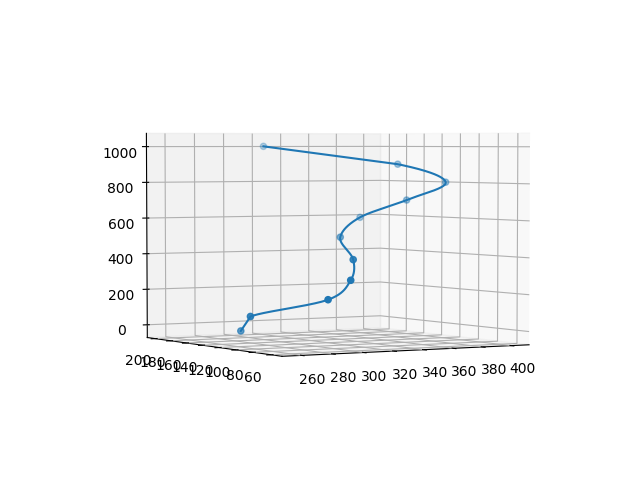

In [10]:
fig = plt.figure();
ax = fig.add_subplot(111, projection='3d');
x,y,z = zip(*spline_interp_centers);
ax.plot(x, y, z);
xm,ym,zm = zip(*manual_centers)
ax.scatter(xm,ym,zm, 'og')
plt.show();

In [50]:
target_zs = [z for z in range(manual_centers[0][2], manual_centers[-1][2]+1)];

Target z = 1, achieved point = [270.0, 135.0, 1.0]
Target z = 2, achieved point = [269.8797595190381, 134.66933867735472, 2.0020040080160317]
Target z = 3, achieved point = [269.7595190380762, 134.33867735470943, 3.004008016032064]
Target z = 4, achieved point = [269.6392785571142, 134.00801603206412, 4.006012024048096]
Target z = 5, achieved point = [269.5190380761523, 133.67735470941884, 5.008016032064128]
Target z = 6, achieved point = [269.3987975951904, 133.34669338677355, 6.01002004008016]
Target z = 7, achieved point = [269.2785571142285, 133.01603206412827, 7.012024048096192]
Target z = 8, achieved point = [269.1583166332665, 132.68537074148296, 8.014028056112224]
Target z = 9, achieved point = [269.0380761523046, 132.35470941883767, 9.016032064128256]
Target z = 10, achieved point = [268.9178356713427, 132.0240480961924, 10.01803607214429]
Target z = 11, achieved point = [268.7975951903808, 131.6933867735471, 11.02004008016032]
Target z = 12, achieved point = [268.677354709418

Target z = 374, achieved point = [307.0004463572358, 69.43154712155352, 373.9974415120787]
Target z = 375, achieved point = [307.1260659830525, 69.65699847882195, 374.9942229824369]
Target z = 376, achieved point = [307.25293970714347, 69.88597719574612, 375.9902874760463]
Target z = 377, achieved point = [307.3811014896732, 70.11852092804583, 376.98561868526605]
Target z = 378, achieved point = [307.5105852908066, 70.35466733144091, 377.9802003024551]
Target z = 379, achieved point = [307.64142507070846, 70.59445406165125, 378.9740160199726]
Target z = 380, achieved point = [307.77365478954346, 70.83791877439663, 379.96704953017775]
Target z = 381, achieved point = [307.9073084074764, 71.08509912539685, 380.9592845254294]
Target z = 382, achieved point = [308.0424198846722, 71.33603277037184, 381.95070469808684]
Target z = 383, achieved point = [308.1790231812954, 71.59075736504138, 382.9412937405091]
Target z = 384, achieved point = [308.31715225751094, 71.84931056512528, 383.9310353

Target z = 804, achieved point = [401.9828535899798, 120.16491688040036, 804.0216673653641]
Target z = 805, achieved point = [401.9674573372597, 120.22787925503145, 805.0304320859027]
Target z = 806, achieved point = [401.94726338457895, 120.29480659362173, 806.0399220648354]
Target z = 807, achieved point = [401.9222973467755, 120.36568085019738, 807.0501097775738]
Target z = 808, achieved point = [401.89258483868673, 120.44048397878457, 808.060967699529]
Target z = 809, achieved point = [401.8581514751506, 120.51919793340956, 809.0724683061127]
Target z = 810, achieved point = [401.81902287100456, 120.60180466809848, 810.0845840727359]
Target z = 811, achieved point = [401.7752246410865, 120.68828613687755, 811.0972874748102]
Target z = 812, achieved point = [401.73684113976697, 120.76024899355136, 811.9078547974707]
Target z = 813, achieved point = [401.6847021328501, 120.85365950783876, 812.9215465813937]
Target z = 814, achieved point = [401.6279652217065, 120.95089422748968, 813.

<IPython.core.display.Javascript object>


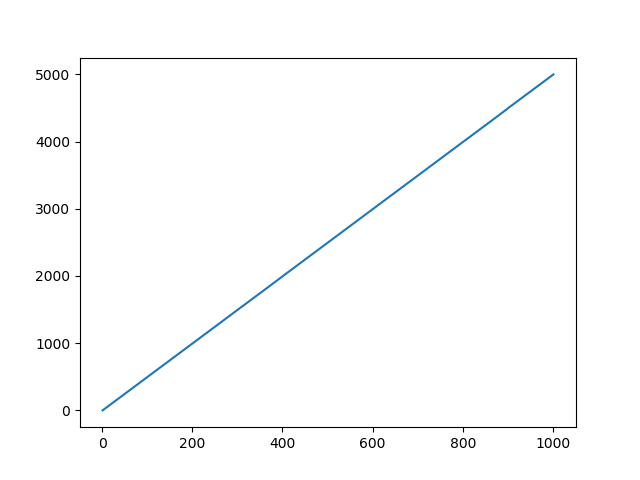

In [53]:
def new_resample_z(spline_points, target_zs):
    spline_zs = [z for _,_,z in spline_points];
    out_points = [];
    closest_idxs = [];
    for idx, z_target in enumerate(target_zs):
        lf = [abs(spline_z - z_target) for spline_z in spline_zs];
        # this might fail when spline has regions of decreasing z!
        closest_idx = lf.index(min(lf));
        print("Target z = {}, achieved point = {}".format(z_target, spline_points[closest_idx]));
        closest_idxs.append(closest_idx);
        out_points.append((spline_points[closest_idx][0], spline_points[closest_idx][1], z_target));
    return out_points, closest_idxs;

out_points, closest_idxs = new_resample_z(spline_interp_centers, target_zs)

fig, ax = plt.subplots(1, 1);
ax.plot(target_zs, closest_idxs)

<IPython.core.display.Javascript object>


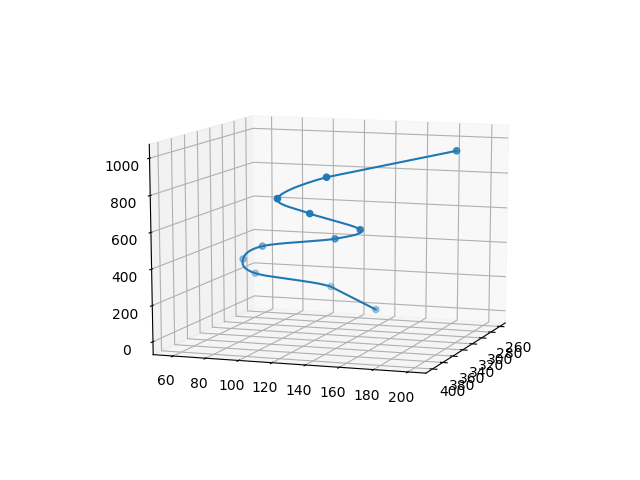

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d');
xo,yo,zo = zip(*out_points)
ax.plot(xo,yo,zo)
xm,ym,zm = zip(*manual_centers)
ax.scatter(xm,ym,zm, 'og')
plt.show();